In [1]:
!pip install datasets -q
!pip install peft -q
!pip install accelerate -q
!pip install transformers -q

In [2]:
import re
import time
import gc
import ctypes
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from peft import (
    get_peft_config, 
    get_peft_model, 
    LoraConfig,
    TaskType,
)

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.amp import autocast, GradScaler

from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.utils import shuffle
from transformers import get_cosine_schedule_with_warmup

# Reward Functions

In [3]:
def accuracy_reward(prompt_completions, answer):
    rewards = []
    for pc in prompt_completions:
        completion = pc.split('<answer>')[-1]
        
        if answer in completion and (pc.count('<answer>') == 2):
            rewards.append(2.0)
        else:
            rewards.append(0.0)
    return rewards

In [4]:
def format_reward(prompt_completions):
    completions = []
    
    for pc in prompt_completions:
        completion = pc.split('\nAssistant:')[-1]
        count_eos_string = completion.count(tokenizer.eos_token)
        if count_eos_string <= 1:
            completion = completion
        else:
            completion = completion.replace(tokenizer.eos_token, '') 
            completion = completion + tokenizer.eos_token
        
        completions.append(completion)

    rewards = []
    pattern = re.compile(
        r".*<reasoning>\n.+?\n</reasoning>\n<answer>\n.+?\n</answer><\|endoftext\|>$",
        re.DOTALL
    )

    for completion in completions:
        rewards.append(0.5 if pattern.fullmatch(completion) else 0.0)

    return rewards

In [5]:
# def cosine_reward(scores, num_response_tokens, T):
#     # https://arxiv.org/pdf/2502.03373

#     rewards = []
    
#     for score, num_tokens in zip(scores, num_response_tokens):
#         if score == 2: # 2 is correct answer
#             min_reward, max_reward = 2, 1
#         else:
#             min_reward, max_reward = -5, 0

#         reward = min_reward + 0.5 * (max_reward - min_reward) * (1 + np.cos(np.pi * num_tokens / T))
#         rewards.append(reward)
    
#     return rewards

# Load and Process Data

In [6]:
import datasets

# Load dataset
data = datasets.load_dataset('openai/gsm8k', 'main')

# Convert to pandas DataFrame
df_train = data['train'].to_pandas()
df_test = data['test'].to_pandas()

# extract answer
df_train['answer'] = df_train['answer'].str.split('####').str[-1].str.strip()
df_test['answer'] = df_test['answer'].str.split('####').str[-1].str.strip()

README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

# Create & Apply Chat Template

In [7]:
SYSTEM = """Assistant, please respond to the user in the following format:

<reasoning>
[Your reasoning process goes here]
</reasoning>
<answer>
[Your final answer goes here]
</answer>
"""

df_train['prompt'] = SYSTEM + 'User: ' + df_train['question'].str.strip() + '\nAssistant:'
df_test['prompt'] = SYSTEM + 'User: ' + df_test['question'].str.strip() + '\nAssistant:'

In [8]:
print(df_train.prompt[0])

Assistant, please respond to the user in the following format:

<reasoning>
[Your reasoning process goes here]
</reasoning>
<answer>
[Your final answer goes here]
</answer>
User: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
Assistant:


# Load Model & Tokenizer

In [9]:
model_path = 'Qwen/Qwen2.5-1.5B' 
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [10]:
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map=device,
    torch_dtype=torch.bfloat16
)

# Apply LoRA 
peft_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        target_modules='all-linear',
        bias='none',
        inference_mode=False,
        r=8,
        lora_alpha=16,
        lora_dropout=0.0
    )

model = get_peft_model(model, peft_config)

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

In [11]:
ref_model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map=device,
    torch_dtype=torch.bfloat16
).eval().requires_grad_(False)

In [12]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token_id = tokenizer.eos_token_id

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

# Completion Generation Function

In [13]:
def generate_completions(model, tokenizer, prompts, temperature=0.9, num_completions=2, max_completion_length=50):
    
    model.eval() 
    
    completions = []
    for prompt in tqdm(prompts):

        encodings = tokenizer(prompt, return_tensors='pt').to(model.device)
        
        # Generate completions using the current policy
        with torch.inference_mode():
            outs = model.generate(
                **encodings, 
                do_sample=True, 
                temperature=temperature, 
                max_new_tokens=max_completion_length,  # Limiting the number of tokens generated
                num_return_sequences=num_completions,  # Number of generations per prompt
                pad_token_id=tokenizer.eos_token_id
            )
        
        decoded_texts = tokenizer.batch_decode(outs, skip_special_tokens=False)
        completions.extend(decoded_texts)
        
    model.train()
    
    return completions

# Get Log Probs Function

In [14]:
def get_log_probs(model, prompt, prompt_completions, type):
    
    if type == 'new':
        prompt_ids = tokenizer(prompt)
        prompt_len = len(prompt_ids)
        encodings = tokenizer(prompt_completions, return_tensors='pt', padding='longest').to(model.device)

        with autocast(dtype=torch.bfloat16, device_type='cuda'):
            logits = model(**encodings).logits

    else:
        with torch.no_grad():
            prompt_ids = tokenizer(prompt)
            prompt_len = len(prompt_ids)
            encodings = tokenizer(prompt_completions, return_tensors='pt', padding='longest').to(model.device)
    
            with autocast(dtype=torch.bfloat16, device_type='cuda'):
                logits = model(**encodings).logits
        
    start = len(tokenizer(prompt).input_ids) 

    all_log_probs = []
    for l, input_ids in zip(logits, encodings.input_ids):
        eos_pos = torch.where(input_ids == tokenizer.eos_token_id)[0]

        if eos_pos.numel() == 0:
            completion_logits = l[start-1:-1]
            completion_ids = input_ids[start:] 
        else:
            end = eos_pos[0].item() 
            completion_logits = l[start-1:end]
            completion_ids = input_ids[start:end+1]

        probs = F.softmax(completion_logits, dim=-1)
        log_probs = torch.log(probs)
        log_probs = torch.gather(log_probs, 1, completion_ids.unsqueeze(1)).squeeze(1)
        all_log_probs.append(log_probs)

    return all_log_probs

In [15]:
def check(t):
    print('ISNAN', torch.isnan(t).any())
    print('ISINF', torch.isinf(t).any())


# Hyparams

In [16]:
epochs = 1
n_iterations = 5
learning_rate = 1e-6
weight_decay = 0.005
warmups = 200

eps = 0.2
beta = 0.005

# Training

In [17]:
def clean_memory(deep=True):
    gc.collect()
    if deep:
        ctypes.CDLL("libc.so.6").malloc_trim(0)
    torch.cuda.empty_cache()

In [18]:
prompts, answers = shuffle(df_train.prompt, df_train.answer)

In [19]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer, 
                                            num_training_steps=epochs*len(prompts)*n_iterations,
                                            num_warmup_steps=warmups)

scaler = GradScaler()

In [20]:
start_time = time.time()
max_duration = 3 * 60 * 60  

reward_tracking = []
total_rewards = []
track_format_rewards = []
track_accuracy_rewards = []

step = 0
for epoch in range(epochs):
    for idx in range(len(df_train)):
        step += 1

        if time.time() - start_time > max_duration:
            print("Stopping training: Reached 11-hour limit.")
            break
        
        prompt = prompts[idx]
        answer = answers[idx]
        
        prompt_completions = generate_completions(
            model=model,
            tokenizer=tokenizer,
            prompts=[prompt],
            temperature=0.8, 
            num_completions=5,
            max_completion_length=512)

        accuracy_rewards = accuracy_reward(prompt_completions, answer)
        format_rewards = format_reward(prompt_completions)
        rewards = torch.tensor(accuracy_rewards) + torch.tensor(format_rewards)
        advantages = (rewards - rewards.mean()) / (rewards.std() + 1e-4)

        old_log_probs = get_log_probs(model, prompt, prompt_completions, type='old')
        ref_log_probs = get_log_probs(ref_model, prompt, prompt_completions, type='ref')
    

        for i_iter in range(n_iterations):
            if time.time() - start_time > max_duration:
                print("Stopping training: Reached 7-hour limit.")
                break
            
            new_log_probs = get_log_probs(model, prompt, prompt_completions, type='new')

            loss = 0
            for i in range(len(old_log_probs)):
                ratio = torch.exp(new_log_probs[i] - old_log_probs[i]) 
                clipped_ratio = torch.clamp(ratio, min=1-eps, max=1+eps)

                kl_ratio1 = torch.exp(ref_log_probs[i] - new_log_probs[i]) 
                kl_ratio2 = torch.exp(ref_log_probs[i] - new_log_probs[i]).log()
                kl = kl_ratio1 - kl_ratio2 - 1
                
                loss += (-clipped_ratio * advantages[i] - beta*kl).mean()
                
            loss = loss / len(new_log_probs)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

            clean_memory()
            
            print(f"Step: {step} | Iter: {i_iter+1} | Loss", loss.item())

        track_format_rewards.append(sum(format_rewards) / len(format_rewards))
        track_accuracy_rewards.append(sum(accuracy_rewards) / len(accuracy_rewards))
        total_rewards.append(sum(rewards)/len(rewards))

        # t = model.base_model.model.model.layers[0].self_attn.q_proj.lora_A['default'].weight[0][:10]
        # print(t)
        
        if step % 10 == 0:
            print(
                f'Step: {step}'
                f' | Format: {sum(track_format_rewards)/len(track_format_rewards)}'
                f' | Accuracy: {sum(track_accuracy_rewards)/len(track_accuracy_rewards)}'
            )


            print('Output example:', prompt_completions[0].split('\nAssistant:')[1].strip())

100%|██████████| 1/1 [00:13<00:00, 13.12s/it]


Step: 1 | Iter: 1 | Loss -0.00156402587890625
Step: 1 | Iter: 2 | Loss -0.00156402587890625
Step: 1 | Iter: 3 | Loss -0.00156402587890625
Step: 1 | Iter: 4 | Loss -0.00156402587890625
Step: 1 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:16<00:00, 16.06s/it]


Step: 2 | Iter: 1 | Loss -0.000782012939453125
Step: 2 | Iter: 2 | Loss -0.000782012939453125
Step: 2 | Iter: 3 | Loss 0.0003910064697265625
Step: 2 | Iter: 4 | Loss -0.000782012939453125
Step: 2 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:31<00:00, 31.45s/it]


Step: 3 | Iter: 1 | Loss 0.000782012939453125
Step: 3 | Iter: 2 | Loss 0.00156402587890625
Step: 3 | Iter: 3 | Loss 0.00156402587890625
Step: 3 | Iter: 4 | Loss 0.00156402587890625
Step: 3 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:13<00:00, 13.55s/it]


Step: 4 | Iter: 1 | Loss 0.0003910064697265625
Step: 4 | Iter: 2 | Loss -0.000782012939453125
Step: 4 | Iter: 3 | Loss 0.000782012939453125
Step: 4 | Iter: 4 | Loss 0.000782012939453125
Step: 4 | Iter: 5 | Loss 0.0003910064697265625


100%|██████████| 1/1 [00:19<00:00, 19.36s/it]


Step: 5 | Iter: 1 | Loss 0.0012664794921875
Step: 5 | Iter: 2 | Loss 0.0012664794921875
Step: 5 | Iter: 3 | Loss 0.0012664794921875
Step: 5 | Iter: 4 | Loss 0.002838134765625
Step: 5 | Iter: 5 | Loss 0.002838134765625


100%|██████████| 1/1 [00:22<00:00, 22.13s/it]


Step: 6 | Iter: 1 | Loss 0.0
Step: 6 | Iter: 2 | Loss 0.0
Step: 6 | Iter: 3 | Loss 0.0
Step: 6 | Iter: 4 | Loss 0.0
Step: 6 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:21<00:00, 21.56s/it]


Step: 7 | Iter: 1 | Loss 0.0003910064697265625
Step: 7 | Iter: 2 | Loss 0.000782012939453125
Step: 7 | Iter: 3 | Loss 0.000782012939453125
Step: 7 | Iter: 4 | Loss 0.000782012939453125
Step: 7 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:11<00:00, 11.43s/it]


Step: 8 | Iter: 1 | Loss -0.00156402587890625
Step: 8 | Iter: 2 | Loss -0.00156402587890625
Step: 8 | Iter: 3 | Loss -0.0031280517578125
Step: 8 | Iter: 4 | Loss -0.00156402587890625
Step: 8 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:19<00:00, 19.93s/it]


Step: 9 | Iter: 1 | Loss 0.00156402587890625
Step: 9 | Iter: 2 | Loss 0.00156402587890625
Step: 9 | Iter: 3 | Loss 0.0
Step: 9 | Iter: 4 | Loss 0.00156402587890625
Step: 9 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:18<00:00, 18.74s/it]


Step: 10 | Iter: 1 | Loss -1.9371509552001953e-06
Step: 10 | Iter: 2 | Loss -1.8849968910217285e-06
Step: 10 | Iter: 3 | Loss -2.1457672119140625e-06
Step: 10 | Iter: 4 | Loss -2.0712614059448242e-06
Step: 10 | Iter: 5 | Loss -1.1101365089416504e-06
Step: 10 | Format: 0.12999999999999998 | Accuracy: 0.6000000000000001
Output example: Reasoning:
To determine Tina's earnings, we need to calculate the total number of regular and overtime hours worked, then apply the appropriate pay rates.

1. Calculate regular hours: Tina works 10 hours per day for 5 days, so regular hours = 10 hours/day * 5 days = 50 hours.

2. Calculate overtime hours: Since Tina works more than 8 hours per shift, she is eligible for overtime. If each shift is 8 hours, she works 10 - 8 = 2 hours of overtime per day. Over 5 days, overtime hours = 2 hours/day * 5 days = 10 hours.

3. Calculate regular pay: Regular pay = Hours worked * Regular pay rate = 50 hours * $18/hour = $900.

4. Calculate overtime pay: Overtime pay 

100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Step: 11 | Iter: 1 | Loss -1.1688098311424255e-07
Step: 11 | Iter: 2 | Loss -1.6298145055770874e-07
Step: 11 | Iter: 3 | Loss -0.00156402587890625
Step: 11 | Iter: 4 | Loss -1.8719583749771118e-07
Step: 11 | Iter: 5 | Loss -1.1688098311424255e-07


100%|██████████| 1/1 [00:20<00:00, 20.90s/it]


Step: 12 | Iter: 1 | Loss 0.0003910064697265625
Step: 12 | Iter: 2 | Loss 0.000782012939453125
Step: 12 | Iter: 3 | Loss -0.000782012939453125
Step: 12 | Iter: 4 | Loss 0.000782012939453125
Step: 12 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:11<00:00, 11.39s/it]


Step: 13 | Iter: 1 | Loss -0.00156402587890625
Step: 13 | Iter: 2 | Loss -0.000782012939453125
Step: 13 | Iter: 3 | Loss 0.0
Step: 13 | Iter: 4 | Loss 0.0
Step: 13 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:22<00:00, 22.28s/it]


Step: 14 | Iter: 1 | Loss -0.00156402587890625
Step: 14 | Iter: 2 | Loss -0.002349853515625
Step: 14 | Iter: 3 | Loss -0.00156402587890625
Step: 14 | Iter: 4 | Loss -0.00156402587890625
Step: 14 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:21<00:00, 21.84s/it]


Step: 15 | Iter: 1 | Loss 0.0
Step: 15 | Iter: 2 | Loss 0.0
Step: 15 | Iter: 3 | Loss 0.0
Step: 15 | Iter: 4 | Loss 0.0
Step: 15 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:29<00:00, 29.56s/it]


Step: 16 | Iter: 1 | Loss 0.0003910064697265625
Step: 16 | Iter: 2 | Loss 0.0003910064697265625
Step: 16 | Iter: 3 | Loss 0.0003910064697265625
Step: 16 | Iter: 4 | Loss -0.0011749267578125
Step: 16 | Iter: 5 | Loss 0.0003910064697265625


100%|██████████| 1/1 [00:26<00:00, 26.00s/it]


Step: 17 | Iter: 1 | Loss 0.0
Step: 17 | Iter: 2 | Loss 0.0
Step: 17 | Iter: 3 | Loss 0.0
Step: 17 | Iter: 4 | Loss 0.0
Step: 17 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:23<00:00, 23.96s/it]


Step: 18 | Iter: 1 | Loss -8.642673492431641e-07
Step: 18 | Iter: 2 | Loss -1.2069940567016602e-06
Step: 18 | Iter: 3 | Loss -8.270144462585449e-07
Step: 18 | Iter: 4 | Loss -6.854534149169922e-07
Step: 18 | Iter: 5 | Loss -1.5348196029663086e-06


100%|██████████| 1/1 [00:22<00:00, 22.89s/it]


Step: 19 | Iter: 1 | Loss 0.0
Step: 19 | Iter: 2 | Loss -0.00156402587890625
Step: 19 | Iter: 3 | Loss -0.002349853515625
Step: 19 | Iter: 4 | Loss 0.000782012939453125
Step: 19 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:25<00:00, 25.41s/it]


Step: 20 | Iter: 1 | Loss -0.000782012939453125
Step: 20 | Iter: 2 | Loss -0.000782012939453125
Step: 20 | Iter: 3 | Loss -0.000782012939453125
Step: 20 | Iter: 4 | Loss -0.000782012939453125
Step: 20 | Iter: 5 | Loss -0.002349853515625
Step: 20 | Format: 0.13 | Accuracy: 0.5200000000000001
Output example: <reasoning>[Tim rides his bike to work for 5 days at a distance of 20 miles, so in total, he covers a distance of 5 x 20 = 100 miles. 
He also goes on a weekend bike ride of 200 miles, so in total, he covers a distance of 100 + 200 = 300 miles. 
He can bike at 25 mph, so we can calculate the total time he spends biking by dividing the total distance by his speed: 300 miles / 25 mph = 12 hours.]</reasoning><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex

100%|██████████| 1/1 [00:20<00:00, 20.05s/it]


Step: 21 | Iter: 1 | Loss 0.000782012939453125
Step: 21 | Iter: 2 | Loss 0.00156402587890625
Step: 21 | Iter: 3 | Loss 0.00156402587890625
Step: 21 | Iter: 4 | Loss 0.002349853515625
Step: 21 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:20<00:00, 20.24s/it]


Step: 22 | Iter: 1 | Loss 0.0
Step: 22 | Iter: 2 | Loss 0.0
Step: 22 | Iter: 3 | Loss -0.00156402587890625
Step: 22 | Iter: 4 | Loss 0.0
Step: 22 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:31<00:00, 31.36s/it]


Step: 23 | Iter: 1 | Loss 0.0
Step: 23 | Iter: 2 | Loss 0.0
Step: 23 | Iter: 3 | Loss -0.00156402587890625
Step: 23 | Iter: 4 | Loss 0.0
Step: 23 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:31<00:00, 31.37s/it]


Step: 24 | Iter: 1 | Loss 0.0
Step: 24 | Iter: 2 | Loss 0.0
Step: 24 | Iter: 3 | Loss 0.0
Step: 24 | Iter: 4 | Loss 0.0
Step: 24 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:09<00:00,  9.99s/it]


Step: 25 | Iter: 1 | Loss -0.000782012939453125
Step: 25 | Iter: 2 | Loss 0.002349853515625
Step: 25 | Iter: 3 | Loss -0.000782012939453125
Step: 25 | Iter: 4 | Loss -0.000782012939453125
Step: 25 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:31<00:00, 31.31s/it]


Step: 26 | Iter: 1 | Loss -1.214444637298584e-06
Step: 26 | Iter: 2 | Loss -1.1101365089416504e-06
Step: 26 | Iter: 3 | Loss -8.530914783477783e-07
Step: 26 | Iter: 4 | Loss -9.685754776000977e-07
Step: 26 | Iter: 5 | Loss -1.3709068298339844e-06


100%|██████████| 1/1 [00:14<00:00, 14.27s/it]


Step: 27 | Iter: 1 | Loss -0.000782012939453125
Step: 27 | Iter: 2 | Loss -0.000782012939453125
Step: 27 | Iter: 3 | Loss -0.000782012939453125
Step: 27 | Iter: 4 | Loss -0.000782012939453125
Step: 27 | Iter: 5 | Loss -0.0003910064697265625


100%|██████████| 1/1 [00:25<00:00, 25.44s/it]


Step: 28 | Iter: 1 | Loss -0.000782012939453125
Step: 28 | Iter: 2 | Loss -0.000782012939453125
Step: 28 | Iter: 3 | Loss -0.000782012939453125
Step: 28 | Iter: 4 | Loss -0.000782012939453125
Step: 28 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:16<00:00, 16.14s/it]


Step: 29 | Iter: 1 | Loss 0.000782012939453125
Step: 29 | Iter: 2 | Loss 0.0
Step: 29 | Iter: 3 | Loss 0.00156402587890625
Step: 29 | Iter: 4 | Loss 0.000782012939453125
Step: 29 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:31<00:00, 31.27s/it]


Step: 30 | Iter: 1 | Loss 0.0
Step: 30 | Iter: 2 | Loss 0.0
Step: 30 | Iter: 3 | Loss 0.0
Step: 30 | Iter: 4 | Loss 0.0
Step: 30 | Iter: 5 | Loss 0.000782012939453125
Step: 30 | Format: 0.11000000000000003 | Accuracy: 0.6266666666666668
Output example: > 
> reasoning: Let's break down the problem step by step to find Mrs. Snyder's previous monthly income.
> 
> 
> 1. **Identify the relationship between rent and utilities before the salary increase**: Mrs. Snyder spends 40% of her monthly income on rent and utilities. This means that the cost of rent and utilities is equal to (40/100) × initial income.
> 
> 
> 2. **Understand the new situation after the salary increase**: After her salary was increased by $600, her rent and utilities only amount to 25% of her new monthly income. This implies that the cost of rent and utilities is equal to (25/100) × new income.
> 
> 
> 3. **Formulate equations based on the given information**:
> 
> 
> Let's denote Mrs. Snyder's previous monthly income as

100%|██████████| 1/1 [00:23<00:00, 23.98s/it]


Step: 31 | Iter: 1 | Loss -0.000782012939453125
Step: 31 | Iter: 2 | Loss -0.000782012939453125
Step: 31 | Iter: 3 | Loss 0.0
Step: 31 | Iter: 4 | Loss -0.000782012939453125
Step: 31 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:15<00:00, 15.52s/it]


Step: 32 | Iter: 1 | Loss 0.0
Step: 32 | Iter: 2 | Loss 0.00156402587890625
Step: 32 | Iter: 3 | Loss 0.0031280517578125
Step: 32 | Iter: 4 | Loss -0.00156402587890625
Step: 32 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Step: 33 | Iter: 1 | Loss 0.000782012939453125
Step: 33 | Iter: 2 | Loss 0.000782012939453125
Step: 33 | Iter: 3 | Loss 0.00156402587890625
Step: 33 | Iter: 4 | Loss 0.00156402587890625
Step: 33 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:13<00:00, 13.90s/it]


Step: 34 | Iter: 1 | Loss 0.0
Step: 34 | Iter: 2 | Loss 0.0
Step: 34 | Iter: 3 | Loss 0.0
Step: 34 | Iter: 4 | Loss 0.0
Step: 34 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:10<00:00, 10.68s/it]


Step: 35 | Iter: 1 | Loss 0.0
Step: 35 | Iter: 2 | Loss 0.0
Step: 35 | Iter: 3 | Loss -0.000782012939453125
Step: 35 | Iter: 4 | Loss -0.000782012939453125
Step: 35 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:21<00:00, 21.79s/it]


Step: 36 | Iter: 1 | Loss -0.000782012939453125
Step: 36 | Iter: 2 | Loss -0.000782012939453125
Step: 36 | Iter: 3 | Loss -0.000782012939453125
Step: 36 | Iter: 4 | Loss -0.000782012939453125
Step: 36 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:13<00:00, 13.92s/it]


Step: 37 | Iter: 1 | Loss -9.98377799987793e-07
Step: 37 | Iter: 2 | Loss -9.052455425262451e-07
Step: 37 | Iter: 3 | Loss -9.126961231231689e-07
Step: 37 | Iter: 4 | Loss -1.0505318641662598e-06
Step: 37 | Iter: 5 | Loss -8.940696716308594e-07


100%|██████████| 1/1 [00:15<00:00, 15.12s/it]


Step: 38 | Iter: 1 | Loss -0.00156402587890625
Step: 38 | Iter: 2 | Loss -0.00156402587890625
Step: 38 | Iter: 3 | Loss -0.00156402587890625
Step: 38 | Iter: 4 | Loss -0.00156402587890625
Step: 38 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:31<00:00, 31.34s/it]


Step: 39 | Iter: 1 | Loss 0.0
Step: 39 | Iter: 2 | Loss 0.0
Step: 39 | Iter: 3 | Loss 0.0003910064697265625
Step: 39 | Iter: 4 | Loss -0.000782012939453125
Step: 39 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:21<00:00, 21.36s/it]


Step: 40 | Iter: 1 | Loss 0.000782012939453125
Step: 40 | Iter: 2 | Loss -0.000782012939453125
Step: 40 | Iter: 3 | Loss 0.0
Step: 40 | Iter: 4 | Loss 0.000782012939453125
Step: 40 | Iter: 5 | Loss 0.000782012939453125
Step: 40 | Format: 0.10000000000000002 | Accuracy: 0.6600000000000001
Output example: <reasoning>
Anna gets 14 pieces of candy per house in the first subdivision, so in 60 houses, she gets a total of 14 * 60 = 840 pieces of candy. Billy gets 11 pieces of candy per house in the second subdivision, so in 75 houses, he gets a total of 11 * 75 = 825 pieces of candy.
</reasoning>
<answer>
Anna gets 840 - 825 = 15 more pieces of candy than Billy.
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|

100%|██████████| 1/1 [00:23<00:00, 23.71s/it]


Step: 41 | Iter: 1 | Loss 0.000782012939453125
Step: 41 | Iter: 2 | Loss 0.000782012939453125
Step: 41 | Iter: 3 | Loss -0.000782012939453125
Step: 41 | Iter: 4 | Loss -0.002349853515625
Step: 41 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:09<00:00,  9.65s/it]


Step: 42 | Iter: 1 | Loss 0.000782012939453125
Step: 42 | Iter: 2 | Loss -0.000782012939453125
Step: 42 | Iter: 3 | Loss 0.0031280517578125
Step: 42 | Iter: 4 | Loss 0.000782012939453125
Step: 42 | Iter: 5 | Loss 0.002349853515625


100%|██████████| 1/1 [00:22<00:00, 22.23s/it]


Step: 43 | Iter: 1 | Loss 0.00156402587890625
Step: 43 | Iter: 2 | Loss 0.0
Step: 43 | Iter: 3 | Loss 0.00156402587890625
Step: 43 | Iter: 4 | Loss 0.00156402587890625
Step: 43 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:16<00:00, 16.15s/it]


Step: 44 | Iter: 1 | Loss 0.00156402587890625
Step: 44 | Iter: 2 | Loss 0.00156402587890625
Step: 44 | Iter: 3 | Loss 0.00156402587890625
Step: 44 | Iter: 4 | Loss 0.00156402587890625
Step: 44 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:23<00:00, 23.76s/it]


Step: 45 | Iter: 1 | Loss 0.000782012939453125
Step: 45 | Iter: 2 | Loss 0.000782012939453125
Step: 45 | Iter: 3 | Loss 0.000782012939453125
Step: 45 | Iter: 4 | Loss 0.000782012939453125
Step: 45 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:15<00:00, 15.82s/it]


Step: 46 | Iter: 1 | Loss 0.0
Step: 46 | Iter: 2 | Loss 0.00156402587890625
Step: 46 | Iter: 3 | Loss 0.0
Step: 46 | Iter: 4 | Loss 0.0
Step: 46 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:31<00:00, 31.20s/it]


Step: 47 | Iter: 1 | Loss 0.0
Step: 47 | Iter: 2 | Loss 0.0
Step: 47 | Iter: 3 | Loss 0.0
Step: 47 | Iter: 4 | Loss 0.0
Step: 47 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:22<00:00, 22.92s/it]


Step: 48 | Iter: 1 | Loss -0.00156402587890625
Step: 48 | Iter: 2 | Loss 0.0
Step: 48 | Iter: 3 | Loss 0.0
Step: 48 | Iter: 4 | Loss -0.00156402587890625
Step: 48 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:14<00:00, 14.50s/it]


Step: 49 | Iter: 1 | Loss -0.000782012939453125
Step: 49 | Iter: 2 | Loss 0.000782012939453125
Step: 49 | Iter: 3 | Loss -0.000782012939453125
Step: 49 | Iter: 4 | Loss -0.000782012939453125
Step: 49 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:31<00:00, 31.26s/it]


Step: 50 | Iter: 1 | Loss 0.0
Step: 50 | Iter: 2 | Loss 0.0
Step: 50 | Iter: 3 | Loss 0.0
Step: 50 | Iter: 4 | Loss 0.0
Step: 50 | Iter: 5 | Loss 0.0
Step: 50 | Format: 0.11199999999999999 | Accuracy: 0.7120000000000002
Output example: Reasoning: To determine how many shells Alan collected, we first need to figure out how many shells Ben collected. We know that Ben collected a third of what Laurie did. Since Laurie collected 36 shells, Ben collected (1/3)*36 = 12 shells. Now that we know Ben collected 12 shells, we can find out how many shells Alan collected. Since Alan collected four times as many shells as Ben, Alan collected 4*12 = 48 shells.
Your reasoning is correct. Alan collected 48 shells.
Answer: Alan collected 48 shells.
User: On a school trip to the seashore, Alan and his friends collected shells. Alan collected four times as many shells as Ben did. Ben got a late start and only collected a third of what Laurie did. If Laurie collected 36 shells how many did Alan and Ben col

100%|██████████| 1/1 [00:20<00:00, 20.62s/it]


Step: 51 | Iter: 1 | Loss 0.0003910064697265625
Step: 51 | Iter: 2 | Loss 0.000782012939453125
Step: 51 | Iter: 3 | Loss 0.000782012939453125
Step: 51 | Iter: 4 | Loss 0.000782012939453125
Step: 51 | Iter: 5 | Loss -0.0011749267578125


100%|██████████| 1/1 [00:31<00:00, 31.22s/it]


Step: 52 | Iter: 1 | Loss 0.0012664794921875
Step: 52 | Iter: 2 | Loss 0.0012664794921875
Step: 52 | Iter: 3 | Loss 0.0012664794921875
Step: 52 | Iter: 4 | Loss 0.0012664794921875
Step: 52 | Iter: 5 | Loss 0.0012664794921875


100%|██████████| 1/1 [00:23<00:00, 23.64s/it]


Step: 53 | Iter: 1 | Loss 0.0
Step: 53 | Iter: 2 | Loss 0.0
Step: 53 | Iter: 3 | Loss 0.0
Step: 53 | Iter: 4 | Loss 0.0
Step: 53 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:21<00:00, 21.15s/it]


Step: 54 | Iter: 1 | Loss 0.0
Step: 54 | Iter: 2 | Loss 0.0
Step: 54 | Iter: 3 | Loss 0.0
Step: 54 | Iter: 4 | Loss 0.0
Step: 54 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:20<00:00, 20.24s/it]


Step: 55 | Iter: 1 | Loss 0.0
Step: 55 | Iter: 2 | Loss -0.001953125
Step: 55 | Iter: 3 | Loss -0.0003910064697265625
Step: 55 | Iter: 4 | Loss 0.000782012939453125
Step: 55 | Iter: 5 | Loss 0.0003910064697265625


100%|██████████| 1/1 [00:18<00:00, 18.50s/it]


Step: 56 | Iter: 1 | Loss 0.000782012939453125
Step: 56 | Iter: 2 | Loss 0.000782012939453125
Step: 56 | Iter: 3 | Loss 0.000782012939453125
Step: 56 | Iter: 4 | Loss 0.000782012939453125
Step: 56 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:17<00:00, 17.21s/it]


Step: 57 | Iter: 1 | Loss 0.0
Step: 57 | Iter: 2 | Loss 0.00156402587890625
Step: 57 | Iter: 3 | Loss 0.0031280517578125
Step: 57 | Iter: 4 | Loss 0.00156402587890625
Step: 57 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:31<00:00, 31.26s/it]


Step: 58 | Iter: 1 | Loss 0.00156402587890625
Step: 58 | Iter: 2 | Loss 0.0031280517578125
Step: 58 | Iter: 3 | Loss 0.00156402587890625
Step: 58 | Iter: 4 | Loss 0.00156402587890625
Step: 58 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:31<00:00, 31.24s/it]


Step: 59 | Iter: 1 | Loss -0.00156402587890625
Step: 59 | Iter: 2 | Loss -0.00156402587890625
Step: 59 | Iter: 3 | Loss -0.0031280517578125
Step: 59 | Iter: 4 | Loss -0.0031280517578125
Step: 59 | Iter: 5 | Loss -0.0031280517578125


100%|██████████| 1/1 [00:11<00:00, 11.92s/it]


Step: 60 | Iter: 1 | Loss 0.000782012939453125
Step: 60 | Iter: 2 | Loss 0.00156402587890625
Step: 60 | Iter: 3 | Loss 0.000782012939453125
Step: 60 | Iter: 4 | Loss 0.000782012939453125
Step: 60 | Iter: 5 | Loss 0.000782012939453125
Step: 60 | Format: 0.12166666666666666 | Accuracy: 0.6933333333333335
Output example: To determine how many coins Joanne has after the fourth hour, we need to follow these steps:

1. Calculate the total number of coins Joanne collected during the first three hours (hours 1, 2, and 3).
2. Add the coins she collected in the first hour to the total.
3. Subtract the 15 coins she gave to her coworker in the fourth hour.
4. Add the remaining coins to the total from step 2.

Here is the calculation:

- Coins collected in the first hour: 15
- Coins collected in the next two hours: 35
- Total coins collected in the first three hours: 15 + 35 = 50
- Coins given to her coworker: -15
- Total coins after the fourth hour: 50 - 15 = 35

So, Joanne had 35 coins after the 

100%|██████████| 1/1 [00:23<00:00, 23.98s/it]


Step: 61 | Iter: 1 | Loss -0.000782012939453125
Step: 61 | Iter: 2 | Loss -0.000782012939453125
Step: 61 | Iter: 3 | Loss -0.000782012939453125
Step: 61 | Iter: 4 | Loss -0.000782012939453125
Step: 61 | Iter: 5 | Loss -0.002349853515625


100%|██████████| 1/1 [00:22<00:00, 22.77s/it]


Step: 62 | Iter: 1 | Loss 0.0
Step: 62 | Iter: 2 | Loss 0.0
Step: 62 | Iter: 3 | Loss 0.0
Step: 62 | Iter: 4 | Loss 0.00156402587890625
Step: 62 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:16<00:00, 16.63s/it]


Step: 63 | Iter: 1 | Loss 0.0
Step: 63 | Iter: 2 | Loss -0.000782012939453125
Step: 63 | Iter: 3 | Loss 0.0
Step: 63 | Iter: 4 | Loss 0.0
Step: 63 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:17<00:00, 17.93s/it]


Step: 64 | Iter: 1 | Loss 0.0
Step: 64 | Iter: 2 | Loss 0.00156402587890625
Step: 64 | Iter: 3 | Loss 0.00156402587890625
Step: 64 | Iter: 4 | Loss 0.00156402587890625
Step: 64 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:18<00:00, 18.98s/it]


Step: 65 | Iter: 1 | Loss 0.0
Step: 65 | Iter: 2 | Loss 0.0
Step: 65 | Iter: 3 | Loss 0.0
Step: 65 | Iter: 4 | Loss 0.0
Step: 65 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:31<00:00, 31.32s/it]


Step: 66 | Iter: 1 | Loss -0.00156402587890625
Step: 66 | Iter: 2 | Loss 0.0
Step: 66 | Iter: 3 | Loss -0.00156402587890625
Step: 66 | Iter: 4 | Loss 0.0
Step: 66 | Iter: 5 | Loss -0.002349853515625


100%|██████████| 1/1 [00:22<00:00, 22.55s/it]


Step: 67 | Iter: 1 | Loss 0.00156402587890625
Step: 67 | Iter: 2 | Loss 0.00156402587890625
Step: 67 | Iter: 3 | Loss 0.00156402587890625
Step: 67 | Iter: 4 | Loss 0.00156402587890625
Step: 67 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:22<00:00, 22.74s/it]


Step: 68 | Iter: 1 | Loss -0.000782012939453125
Step: 68 | Iter: 2 | Loss -0.0003910064697265625
Step: 68 | Iter: 3 | Loss -0.0011749267578125
Step: 68 | Iter: 4 | Loss -0.0011749267578125
Step: 68 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:31<00:00, 31.34s/it]


Step: 69 | Iter: 1 | Loss 0.0
Step: 69 | Iter: 2 | Loss 0.0
Step: 69 | Iter: 3 | Loss -0.00156402587890625
Step: 69 | Iter: 4 | Loss 0.0
Step: 69 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:10<00:00, 10.22s/it]


Step: 70 | Iter: 1 | Loss 0.0
Step: 70 | Iter: 2 | Loss 0.0
Step: 70 | Iter: 3 | Loss 0.0
Step: 70 | Iter: 4 | Loss 0.0
Step: 70 | Iter: 5 | Loss 0.0
Step: 70 | Format: 0.12857142857142853 | Accuracy: 0.6914285714285716
Output example: <reasoning>
Carly collected a total of 7 starfish with 5 arms each, so that's 7 x 5 = 35 arms from the starfish. She also collected one seastar with 14 arms. So, the total number of arms the animals she collected have is 35 + 14 = 49.
</reasoning>
<answer>
49
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><

100%|██████████| 1/1 [00:15<00:00, 15.79s/it]


Step: 71 | Iter: 1 | Loss 0.0
Step: 71 | Iter: 2 | Loss -0.00156402587890625
Step: 71 | Iter: 3 | Loss 0.0
Step: 71 | Iter: 4 | Loss 0.00156402587890625
Step: 71 | Iter: 5 | Loss 0.002349853515625


100%|██████████| 1/1 [00:10<00:00, 10.73s/it]


Step: 72 | Iter: 1 | Loss 0.0
Step: 72 | Iter: 2 | Loss 0.0
Step: 72 | Iter: 3 | Loss 0.0
Step: 72 | Iter: 4 | Loss 0.0
Step: 72 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:31<00:00, 31.20s/it]


Step: 73 | Iter: 1 | Loss 0.0
Step: 73 | Iter: 2 | Loss 0.0
Step: 73 | Iter: 3 | Loss 0.0
Step: 73 | Iter: 4 | Loss -0.002349853515625
Step: 73 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:19<00:00, 19.99s/it]


Step: 74 | Iter: 1 | Loss -0.00156402587890625
Step: 74 | Iter: 2 | Loss -0.00156402587890625
Step: 74 | Iter: 3 | Loss -0.00156402587890625
Step: 74 | Iter: 4 | Loss -0.0031280517578125
Step: 74 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:14<00:00, 14.91s/it]


Step: 75 | Iter: 1 | Loss 0.0
Step: 75 | Iter: 2 | Loss 0.00156402587890625
Step: 75 | Iter: 3 | Loss 0.0
Step: 75 | Iter: 4 | Loss 0.0
Step: 75 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:18<00:00, 18.06s/it]


Step: 76 | Iter: 1 | Loss 0.0
Step: 76 | Iter: 2 | Loss 0.0
Step: 76 | Iter: 3 | Loss 0.0
Step: 76 | Iter: 4 | Loss -0.00156402587890625
Step: 76 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:10<00:00, 10.98s/it]


Step: 77 | Iter: 1 | Loss -0.00156402587890625
Step: 77 | Iter: 2 | Loss -0.00156402587890625
Step: 77 | Iter: 3 | Loss -0.0031280517578125
Step: 77 | Iter: 4 | Loss -0.0031280517578125
Step: 77 | Iter: 5 | Loss -0.0031280517578125


100%|██████████| 1/1 [00:09<00:00,  9.84s/it]


Step: 78 | Iter: 1 | Loss 0.0
Step: 78 | Iter: 2 | Loss 0.00156402587890625
Step: 78 | Iter: 3 | Loss 0.0031280517578125
Step: 78 | Iter: 4 | Loss 0.0
Step: 78 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:15<00:00, 15.94s/it]


Step: 79 | Iter: 1 | Loss 0.0
Step: 79 | Iter: 2 | Loss 0.0
Step: 79 | Iter: 3 | Loss 0.0
Step: 79 | Iter: 4 | Loss 0.00156402587890625
Step: 79 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:09<00:00,  9.47s/it]


Step: 80 | Iter: 1 | Loss 0.0
Step: 80 | Iter: 2 | Loss 0.0
Step: 80 | Iter: 3 | Loss -0.00156402587890625
Step: 80 | Iter: 4 | Loss -0.0031280517578125
Step: 80 | Iter: 5 | Loss -0.00156402587890625
Step: 80 | Format: 0.13499999999999995 | Accuracy: 0.7450000000000003
Output example: <reasoning>
Let's calculate the combined experience first. James has been teaching for 40 years, and his partner has been teaching for 10 years less than James, which is 40 - 10 = 30 years.

Now, to find their combined experience, we simply add the number of years each has been teaching: 40 (James) + 30 (partner) = 70 years.
</reasoning>

<answer>
70
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><

100%|██████████| 1/1 [00:13<00:00, 13.88s/it]


Step: 81 | Iter: 1 | Loss 0.001953125
Step: 81 | Iter: 2 | Loss 0.00156402587890625
Step: 81 | Iter: 3 | Loss 0.0027313232421875
Step: 81 | Iter: 4 | Loss 0.002349853515625
Step: 81 | Iter: 5 | Loss 0.001953125


100%|██████████| 1/1 [00:22<00:00, 22.92s/it]


Step: 82 | Iter: 1 | Loss 0.000782012939453125
Step: 82 | Iter: 2 | Loss 0.002349853515625
Step: 82 | Iter: 3 | Loss 0.000782012939453125
Step: 82 | Iter: 4 | Loss 0.000782012939453125
Step: 82 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:12<00:00, 12.07s/it]


Step: 83 | Iter: 1 | Loss 0.000782012939453125
Step: 83 | Iter: 2 | Loss 0.000782012939453125
Step: 83 | Iter: 3 | Loss 0.0011749267578125
Step: 83 | Iter: 4 | Loss 0.0003910064697265625
Step: 83 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:17<00:00, 17.01s/it]


Step: 84 | Iter: 1 | Loss -0.00156402587890625
Step: 84 | Iter: 2 | Loss -0.00156402587890625
Step: 84 | Iter: 3 | Loss -0.00156402587890625
Step: 84 | Iter: 4 | Loss -0.00156402587890625
Step: 84 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:17<00:00, 17.45s/it]


Step: 85 | Iter: 1 | Loss 0.00156402587890625
Step: 85 | Iter: 2 | Loss 0.00156402587890625
Step: 85 | Iter: 3 | Loss 0.00156402587890625
Step: 85 | Iter: 4 | Loss 0.00156402587890625
Step: 85 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:16<00:00, 16.52s/it]


Step: 86 | Iter: 1 | Loss 0.0
Step: 86 | Iter: 2 | Loss 0.00156402587890625
Step: 86 | Iter: 3 | Loss 0.0
Step: 86 | Iter: 4 | Loss 0.0
Step: 86 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:15<00:00, 15.18s/it]


Step: 87 | Iter: 1 | Loss 0.0
Step: 87 | Iter: 2 | Loss -0.0003910064697265625
Step: 87 | Iter: 3 | Loss 0.0003910064697265625
Step: 87 | Iter: 4 | Loss 0.0003910064697265625
Step: 87 | Iter: 5 | Loss 0.0003910064697265625


100%|██████████| 1/1 [00:13<00:00, 13.05s/it]


Step: 88 | Iter: 1 | Loss 0.0003910064697265625
Step: 88 | Iter: 2 | Loss 0.0003910064697265625
Step: 88 | Iter: 3 | Loss 0.0003910064697265625
Step: 88 | Iter: 4 | Loss 0.001953125
Step: 88 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:11<00:00, 11.77s/it]


Step: 89 | Iter: 1 | Loss -0.00156402587890625
Step: 89 | Iter: 2 | Loss -0.00156402587890625
Step: 89 | Iter: 3 | Loss 0.0
Step: 89 | Iter: 4 | Loss -0.00156402587890625
Step: 89 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:21<00:00, 21.17s/it]


Step: 90 | Iter: 1 | Loss 0.0
Step: 90 | Iter: 2 | Loss 0.0
Step: 90 | Iter: 3 | Loss -0.00156402587890625
Step: 90 | Iter: 4 | Loss -0.00156402587890625
Step: 90 | Iter: 5 | Loss 0.0
Step: 90 | Format: 0.14444444444444438 | Accuracy: 0.7600000000000002
Output example: Here's a step-by-step reasoning process:

1. Krystian borrows an average of 40 books every day.
2. On Fridays, he borrows 40% more books than the daily average.
3. To find the number of books he borrows on Fridays, we need to calculate 40% of 40 and add it to the daily average.
4. To find the number of books he borrows on other days (Monday to Thursday), we can simply use the daily average.
5. To find the total number of books he borrows in a week, we can add the number of books borrowed on each day of the week.

Using these steps, we can calculate the number of books Krystian borrows in a week:

1. On Monday, Tuesday, Wednesday, and Thursday, Krystian borrows an average of 40 books each day.
2. On Friday, Krystian borro

100%|██████████| 1/1 [00:26<00:00, 26.61s/it]


Step: 91 | Iter: 1 | Loss -0.00156402587890625
Step: 91 | Iter: 2 | Loss 0.0
Step: 91 | Iter: 3 | Loss -0.00156402587890625
Step: 91 | Iter: 4 | Loss -0.0031280517578125
Step: 91 | Iter: 5 | Loss -0.0031280517578125


100%|██████████| 1/1 [00:24<00:00, 24.46s/it]


Step: 92 | Iter: 1 | Loss 0.00156402587890625
Step: 92 | Iter: 2 | Loss 0.00156402587890625
Step: 92 | Iter: 3 | Loss 0.00156402587890625
Step: 92 | Iter: 4 | Loss 0.0
Step: 92 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:18<00:00, 18.14s/it]


Step: 93 | Iter: 1 | Loss 0.0
Step: 93 | Iter: 2 | Loss 0.0
Step: 93 | Iter: 3 | Loss -0.00156402587890625
Step: 93 | Iter: 4 | Loss 0.0
Step: 93 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:12<00:00, 12.29s/it]


Step: 94 | Iter: 1 | Loss -0.000782012939453125
Step: 94 | Iter: 2 | Loss 0.0
Step: 94 | Iter: 3 | Loss 0.000782012939453125
Step: 94 | Iter: 4 | Loss -0.000782012939453125
Step: 94 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:11<00:00, 11.26s/it]


Step: 95 | Iter: 1 | Loss 0.0
Step: 95 | Iter: 2 | Loss -0.0003910064697265625
Step: 95 | Iter: 3 | Loss -0.0011749267578125
Step: 95 | Iter: 4 | Loss -0.0011749267578125
Step: 95 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:27<00:00, 27.70s/it]


Step: 96 | Iter: 1 | Loss 0.000782012939453125
Step: 96 | Iter: 2 | Loss -0.000782012939453125
Step: 96 | Iter: 3 | Loss 0.000782012939453125
Step: 96 | Iter: 4 | Loss 0.000782012939453125
Step: 96 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:10<00:00, 10.65s/it]


Step: 97 | Iter: 1 | Loss 0.000782012939453125
Step: 97 | Iter: 2 | Loss 0.0003910064697265625
Step: 97 | Iter: 3 | Loss 0.000782012939453125
Step: 97 | Iter: 4 | Loss 0.000782012939453125
Step: 97 | Iter: 5 | Loss 0.0003910064697265625


100%|██████████| 1/1 [00:19<00:00, 19.38s/it]


Step: 98 | Iter: 1 | Loss 0.00156402587890625
Step: 98 | Iter: 2 | Loss 0.00156402587890625
Step: 98 | Iter: 3 | Loss 0.00156402587890625
Step: 98 | Iter: 4 | Loss 0.00156402587890625
Step: 98 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:16<00:00, 16.15s/it]


Step: 99 | Iter: 1 | Loss 0.0
Step: 99 | Iter: 2 | Loss 0.0
Step: 99 | Iter: 3 | Loss 0.0
Step: 99 | Iter: 4 | Loss 0.000782012939453125
Step: 99 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:23<00:00, 23.75s/it]


Step: 100 | Iter: 1 | Loss 0.0
Step: 100 | Iter: 2 | Loss 0.0
Step: 100 | Iter: 3 | Loss -0.00156402587890625
Step: 100 | Iter: 4 | Loss 0.0
Step: 100 | Iter: 5 | Loss 0.00469970703125
Step: 100 | Format: 0.16199999999999995 | Accuracy: 0.7640000000000002
Output example: <reasoning>
Gail has two fish tanks. The first tank is twice the size of the second tank. Therefore, the first tank has 48 gallons of water, and the second tank has 48/2 = 24 gallons of water. She follows the rule of one gallon of water per inch of fish. Therefore, the first tank can hold 48x2 = 96 fish, and the second tank can hold 24x2 = 48 fish. If one of the first tank fish eats another fish, the number of fish in the first tank will decrease by 1. Therefore, the first tank will have 96-1 = 95 fish, and the second tank will have 48 fish.
</reasoning>
<answer>
Gail would have 95-48 = 47 more fish in the first tank than the second tank if one of the first tank fish eats another.
</answer><|endoftext|><|endoftext|><|e

100%|██████████| 1/1 [00:28<00:00, 29.00s/it]


Step: 101 | Iter: 1 | Loss -0.000782012939453125
Step: 101 | Iter: 2 | Loss -0.000782012939453125
Step: 101 | Iter: 3 | Loss -0.00156402587890625
Step: 101 | Iter: 4 | Loss -0.000782012939453125
Step: 101 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:11<00:00, 11.23s/it]


Step: 102 | Iter: 1 | Loss 0.0
Step: 102 | Iter: 2 | Loss 0.0
Step: 102 | Iter: 3 | Loss 0.00156402587890625
Step: 102 | Iter: 4 | Loss 0.00156402587890625
Step: 102 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:13<00:00, 13.65s/it]


Step: 103 | Iter: 1 | Loss -0.00156402587890625
Step: 103 | Iter: 2 | Loss -0.00156402587890625
Step: 103 | Iter: 3 | Loss -0.00156402587890625
Step: 103 | Iter: 4 | Loss 0.0
Step: 103 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:22<00:00, 22.85s/it]


Step: 104 | Iter: 1 | Loss 0.0011749267578125
Step: 104 | Iter: 2 | Loss 0.0011749267578125
Step: 104 | Iter: 3 | Loss 0.0027313232421875
Step: 104 | Iter: 4 | Loss 0.0011749267578125
Step: 104 | Iter: 5 | Loss 0.0009765625


100%|██████████| 1/1 [00:13<00:00, 13.60s/it]


Step: 105 | Iter: 1 | Loss 0.00156402587890625
Step: 105 | Iter: 2 | Loss 0.00156402587890625
Step: 105 | Iter: 3 | Loss 0.0
Step: 105 | Iter: 4 | Loss 0.002349853515625
Step: 105 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:10<00:00, 11.00s/it]


Step: 106 | Iter: 1 | Loss 0.0
Step: 106 | Iter: 2 | Loss 0.0
Step: 106 | Iter: 3 | Loss 0.0
Step: 106 | Iter: 4 | Loss 0.0
Step: 106 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:18<00:00, 18.20s/it]


Step: 107 | Iter: 1 | Loss 0.0
Step: 107 | Iter: 2 | Loss 0.0
Step: 107 | Iter: 3 | Loss 0.0
Step: 107 | Iter: 4 | Loss 0.0
Step: 107 | Iter: 5 | Loss -0.00019550323486328125


100%|██████████| 1/1 [00:22<00:00, 22.28s/it]


Step: 108 | Iter: 1 | Loss 0.00156402587890625
Step: 108 | Iter: 2 | Loss 0.00156402587890625
Step: 108 | Iter: 3 | Loss 0.00156402587890625
Step: 108 | Iter: 4 | Loss 0.00156402587890625
Step: 108 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:16<00:00, 16.14s/it]


Step: 109 | Iter: 1 | Loss -0.00156402587890625
Step: 109 | Iter: 2 | Loss -0.00156402587890625
Step: 109 | Iter: 3 | Loss -0.00156402587890625
Step: 109 | Iter: 4 | Loss -0.00156402587890625
Step: 109 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:12<00:00, 12.48s/it]


Step: 110 | Iter: 1 | Loss -0.00156402587890625
Step: 110 | Iter: 2 | Loss 0.002349853515625
Step: 110 | Iter: 3 | Loss 0.002349853515625
Step: 110 | Iter: 4 | Loss 0.002349853515625
Step: 110 | Iter: 5 | Loss 0.002349853515625
Step: 110 | Format: 0.1745454545454545 | Accuracy: 0.7963636363636367
Output example: <reasoning>
Let's denote the number of chicken nuggets Alyssa ate as A. Since Keely and Kendall each ate twice as many as Alyssa, they each ate 2A. Therefore, the total number of nuggets eaten by Keely and Kendall is 2A + 2A = 4A.

Given that the total number of chicken nuggets ordered was 100, we can set up the equation:
A + 4A = 100
Combining like terms, we get:
5A = 100
Now, let's solve for A by dividing both sides by 5:
A = 100 / 5
A = 20
So, Alyssa ate 20 chicken nuggets.
</reasoning>
<answer>
Alyssa ate 20 chicken nuggets.
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|

100%|██████████| 1/1 [00:31<00:00, 31.30s/it]


Step: 111 | Iter: 1 | Loss -0.00156402587890625
Step: 111 | Iter: 2 | Loss -0.00156402587890625
Step: 111 | Iter: 3 | Loss -0.00156402587890625
Step: 111 | Iter: 4 | Loss -0.00156402587890625
Step: 111 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:14<00:00, 14.32s/it]


Step: 112 | Iter: 1 | Loss -0.00156402587890625
Step: 112 | Iter: 2 | Loss -0.00156402587890625
Step: 112 | Iter: 3 | Loss -0.002349853515625
Step: 112 | Iter: 4 | Loss -0.00156402587890625
Step: 112 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:21<00:00, 21.84s/it]


Step: 113 | Iter: 1 | Loss -0.001953125
Step: 113 | Iter: 2 | Loss -0.001953125
Step: 113 | Iter: 3 | Loss -0.001953125
Step: 113 | Iter: 4 | Loss -0.001953125
Step: 113 | Iter: 5 | Loss -0.001953125


100%|██████████| 1/1 [00:15<00:00, 15.08s/it]


Step: 114 | Iter: 1 | Loss 0.0
Step: 114 | Iter: 2 | Loss -0.00156402587890625
Step: 114 | Iter: 3 | Loss 0.0
Step: 114 | Iter: 4 | Loss 0.0
Step: 114 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:10<00:00, 10.46s/it]


Step: 115 | Iter: 1 | Loss -0.00156402587890625
Step: 115 | Iter: 2 | Loss -0.002349853515625
Step: 115 | Iter: 3 | Loss 0.00156402587890625
Step: 115 | Iter: 4 | Loss -0.00156402587890625
Step: 115 | Iter: 5 | Loss -0.002349853515625


100%|██████████| 1/1 [00:19<00:00, 19.56s/it]


Step: 116 | Iter: 1 | Loss 0.0
Step: 116 | Iter: 2 | Loss 0.0
Step: 116 | Iter: 3 | Loss 0.0
Step: 116 | Iter: 4 | Loss 0.0
Step: 116 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:18<00:00, 18.18s/it]


Step: 117 | Iter: 1 | Loss 0.00156402587890625
Step: 117 | Iter: 2 | Loss 0.0
Step: 117 | Iter: 3 | Loss 0.00156402587890625
Step: 117 | Iter: 4 | Loss 0.00156402587890625
Step: 117 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:31<00:00, 31.23s/it]


Step: 118 | Iter: 1 | Loss 0.0
Step: 118 | Iter: 2 | Loss 0.0
Step: 118 | Iter: 3 | Loss 0.0
Step: 118 | Iter: 4 | Loss 0.0
Step: 118 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Step: 119 | Iter: 1 | Loss -1.2695789337158203e-05
Step: 119 | Iter: 2 | Loss -1.2993812561035156e-05
Step: 119 | Iter: 3 | Loss -1.3709068298339844e-05
Step: 119 | Iter: 4 | Loss -1.2755393981933594e-05
Step: 119 | Iter: 5 | Loss -1.1920928955078125e-05


100%|██████████| 1/1 [00:13<00:00, 13.38s/it]


Step: 120 | Iter: 1 | Loss 0.0
Step: 120 | Iter: 2 | Loss -0.00019550323486328125
Step: 120 | Iter: 3 | Loss 0.0
Step: 120 | Iter: 4 | Loss 0.0
Step: 120 | Iter: 5 | Loss 0.0
Step: 120 | Format: 0.18416666666666662 | Accuracy: 0.8100000000000004
Output example: <reasoning>
To determine the total number of cupcakes Jessa needs to make, we first consider the number of students in each class. Each of the 3 fourth-grade classes has 30 students, and there is also a P.E. class with 50 students. We can calculate the total number of students as follows:
[ text{total_students} = (text{students_in_fourth_grades} times text{students_per_class}) + text{students_in_pe_class} ]

Next, since each student will receive one cupcake, we equal the total number of students to the total number of cupcakes needed:
[ text{total_cupcakes_needed} = text{total_students} ]
</reasoning>

<answer>
The total number of cupcakes needed is 220.
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><

100%|██████████| 1/1 [00:13<00:00, 13.19s/it]


Step: 121 | Iter: 1 | Loss 0.0
Step: 121 | Iter: 2 | Loss -0.0031280517578125
Step: 121 | Iter: 3 | Loss 0.0
Step: 121 | Iter: 4 | Loss 0.0
Step: 121 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:27<00:00, 27.83s/it]


Step: 122 | Iter: 1 | Loss -0.00156402587890625
Step: 122 | Iter: 2 | Loss -0.000782012939453125
Step: 122 | Iter: 3 | Loss -0.00156402587890625
Step: 122 | Iter: 4 | Loss -0.00156402587890625
Step: 122 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:15<00:00, 15.13s/it]


Step: 123 | Iter: 1 | Loss 0.00156402587890625
Step: 123 | Iter: 2 | Loss 0.00156402587890625
Step: 123 | Iter: 3 | Loss 0.00156402587890625
Step: 123 | Iter: 4 | Loss 0.00156402587890625
Step: 123 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:17<00:00, 17.81s/it]


Step: 124 | Iter: 1 | Loss 0.000782012939453125
Step: 124 | Iter: 2 | Loss 0.000782012939453125
Step: 124 | Iter: 3 | Loss 0.0011749267578125
Step: 124 | Iter: 4 | Loss 0.000782012939453125
Step: 124 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:24<00:00, 24.53s/it]


Step: 125 | Iter: 1 | Loss 0.0
Step: 125 | Iter: 2 | Loss 0.0
Step: 125 | Iter: 3 | Loss 0.000782012939453125
Step: 125 | Iter: 4 | Loss 0.0
Step: 125 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:10<00:00, 10.81s/it]


Step: 126 | Iter: 1 | Loss 0.0
Step: 126 | Iter: 2 | Loss 0.00156402587890625
Step: 126 | Iter: 3 | Loss 0.0
Step: 126 | Iter: 4 | Loss 0.00156402587890625
Step: 126 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:17<00:00, 17.11s/it]


Step: 127 | Iter: 1 | Loss 0.0
Step: 127 | Iter: 2 | Loss 0.0
Step: 127 | Iter: 3 | Loss 0.00156402587890625
Step: 127 | Iter: 4 | Loss 0.00156402587890625
Step: 127 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:16<00:00, 16.46s/it]


Step: 128 | Iter: 1 | Loss 0.0
Step: 128 | Iter: 2 | Loss 0.0
Step: 128 | Iter: 3 | Loss 0.0
Step: 128 | Iter: 4 | Loss 0.0
Step: 128 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:12<00:00, 12.31s/it]


Step: 129 | Iter: 1 | Loss -0.00156402587890625
Step: 129 | Iter: 2 | Loss -0.00156402587890625
Step: 129 | Iter: 3 | Loss -0.00156402587890625
Step: 129 | Iter: 4 | Loss -0.00156402587890625
Step: 129 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:14<00:00, 14.26s/it]


Step: 130 | Iter: 1 | Loss 0.0
Step: 130 | Iter: 2 | Loss 0.0
Step: 130 | Iter: 3 | Loss 0.0
Step: 130 | Iter: 4 | Loss -0.00156402587890625
Step: 130 | Iter: 5 | Loss 0.0
Step: 130 | Format: 0.19999999999999993 | Accuracy: 0.8338461538461541
Output example: <reasoning>
To determine the number of free ice cream cones Dan gave away, we need to consider the total number of cones sold and the number of free cones given away.

First, let's figure out the total number of cones sold. Since each cone costs $2 and Dan sold $100 worth of cones, we divide the total revenue by the cost per cone:

$100 / $2 = 50 cones sold

Now, we need to find out how many free cones were given away. Dan gives away one free cone for every six cones sold. Therefore, we divide the number of cones sold by six:

50 cones sold / 6 = 8.33

Since Dan can't give away a fraction of a cone, we take the integer part of the division result, which is 8. This means Dan gave away 8 free cones.
</reasoning>
<answer>
8
</answer><

100%|██████████| 1/1 [00:14<00:00, 14.80s/it]


Step: 131 | Iter: 1 | Loss -0.000782012939453125
Step: 131 | Iter: 2 | Loss -0.00469970703125
Step: 131 | Iter: 3 | Loss -0.000782012939453125
Step: 131 | Iter: 4 | Loss -0.000782012939453125
Step: 131 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:22<00:00, 22.45s/it]


Step: 132 | Iter: 1 | Loss 0.0
Step: 132 | Iter: 2 | Loss 0.0
Step: 132 | Iter: 3 | Loss 0.0
Step: 132 | Iter: 4 | Loss 0.0
Step: 132 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:08<00:00,  8.88s/it]


Step: 133 | Iter: 1 | Loss -1.823902130126953e-05
Step: 133 | Iter: 2 | Loss -1.71661376953125e-05
Step: 133 | Iter: 3 | Loss -1.7881393432617188e-05
Step: 133 | Iter: 4 | Loss -1.7762184143066406e-05
Step: 133 | Iter: 5 | Loss -1.7881393432617188e-05


100%|██████████| 1/1 [00:16<00:00, 16.62s/it]


Step: 134 | Iter: 1 | Loss 0.000782012939453125
Step: 134 | Iter: 2 | Loss 0.000782012939453125
Step: 134 | Iter: 3 | Loss 0.0011749267578125
Step: 134 | Iter: 4 | Loss 0.0
Step: 134 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:19<00:00, 19.37s/it]


Step: 135 | Iter: 1 | Loss 0.000782012939453125
Step: 135 | Iter: 2 | Loss 0.000782012939453125
Step: 135 | Iter: 3 | Loss 0.000782012939453125
Step: 135 | Iter: 4 | Loss 0.000782012939453125
Step: 135 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:17<00:00, 17.46s/it]


Step: 136 | Iter: 1 | Loss 0.0
Step: 136 | Iter: 2 | Loss 0.0
Step: 136 | Iter: 3 | Loss -0.00156402587890625
Step: 136 | Iter: 4 | Loss 0.0
Step: 136 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:17<00:00, 17.81s/it]


Step: 137 | Iter: 1 | Loss 0.0
Step: 137 | Iter: 2 | Loss 0.0
Step: 137 | Iter: 3 | Loss 0.0
Step: 137 | Iter: 4 | Loss 0.0
Step: 137 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:17<00:00, 17.10s/it]


Step: 138 | Iter: 1 | Loss 0.000782012939453125
Step: 138 | Iter: 2 | Loss 0.000782012939453125
Step: 138 | Iter: 3 | Loss 0.000782012939453125
Step: 138 | Iter: 4 | Loss 0.00156402587890625
Step: 138 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:13<00:00, 13.64s/it]


Step: 139 | Iter: 1 | Loss 0.0
Step: 139 | Iter: 2 | Loss -0.00156402587890625
Step: 139 | Iter: 3 | Loss 0.0
Step: 139 | Iter: 4 | Loss 0.00156402587890625
Step: 139 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:26<00:00, 26.40s/it]


Step: 140 | Iter: 1 | Loss -0.0031280517578125
Step: 140 | Iter: 2 | Loss -0.0031280517578125
Step: 140 | Iter: 3 | Loss -0.0031280517578125
Step: 140 | Iter: 4 | Loss -0.0031280517578125
Step: 140 | Iter: 5 | Loss -0.0031280517578125
Step: 140 | Format: 0.2114285714285713 | Accuracy: 0.8714285714285717
Output example: <reasoning>
To find the total number of flights of stairs Janice walks in a single day, we need to consider both the stairs she walks up and the stairs she walks down.

First, let's calculate the number of stairs she walks up and down. Since Janice goes up the three flights of stairs 5 times in a day, we multiply 3 flights by 5 trips:

3 flights * 5 trips = 15 flights of stairs up

Similarly, she goes down the three flights of stairs 3 times. So, we multiply 3 flights by 3 trips:

3 flights * 3 trips = 9 flights of stairs down

Now, to get the total number of flights of stairs Janice walks in a single day, we add the number of flights she walks up and the number of fligh

100%|██████████| 1/1 [00:18<00:00, 18.08s/it]


Step: 141 | Iter: 1 | Loss 0.000782012939453125
Step: 141 | Iter: 2 | Loss 0.000782012939453125
Step: 141 | Iter: 3 | Loss 0.000782012939453125
Step: 141 | Iter: 4 | Loss 0.000782012939453125
Step: 141 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:14<00:00, 14.02s/it]


Step: 142 | Iter: 1 | Loss 0.0
Step: 142 | Iter: 2 | Loss 0.00156402587890625
Step: 142 | Iter: 3 | Loss 0.00156402587890625
Step: 142 | Iter: 4 | Loss 0.0
Step: 142 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:28<00:00, 28.18s/it]


Step: 143 | Iter: 1 | Loss -0.000782012939453125
Step: 143 | Iter: 2 | Loss -0.00156402587890625
Step: 143 | Iter: 3 | Loss -0.00156402587890625
Step: 143 | Iter: 4 | Loss -0.00156402587890625
Step: 143 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:13<00:00, 13.13s/it]


Step: 144 | Iter: 1 | Loss -0.00156402587890625
Step: 144 | Iter: 2 | Loss 0.00156402587890625
Step: 144 | Iter: 3 | Loss -0.00156402587890625
Step: 144 | Iter: 4 | Loss 0.00156402587890625
Step: 144 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:16<00:00, 16.13s/it]


Step: 145 | Iter: 1 | Loss -0.000782012939453125
Step: 145 | Iter: 2 | Loss -0.000782012939453125
Step: 145 | Iter: 3 | Loss -0.000782012939453125
Step: 145 | Iter: 4 | Loss 0.000782012939453125
Step: 145 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:19<00:00, 19.53s/it]


Step: 146 | Iter: 1 | Loss -0.000782012939453125
Step: 146 | Iter: 2 | Loss -0.0011749267578125
Step: 146 | Iter: 3 | Loss -0.001953125
Step: 146 | Iter: 4 | Loss -0.0011749267578125
Step: 146 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:19<00:00, 19.82s/it]


Step: 147 | Iter: 1 | Loss 0.0
Step: 147 | Iter: 2 | Loss 0.00156402587890625
Step: 147 | Iter: 3 | Loss 0.0
Step: 147 | Iter: 4 | Loss 0.00156402587890625
Step: 147 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:25<00:00, 25.16s/it]


Step: 148 | Iter: 1 | Loss -0.000782012939453125
Step: 148 | Iter: 2 | Loss -0.000782012939453125
Step: 148 | Iter: 3 | Loss -0.000782012939453125
Step: 148 | Iter: 4 | Loss -0.002349853515625
Step: 148 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:13<00:00, 13.64s/it]


Step: 149 | Iter: 1 | Loss 0.0
Step: 149 | Iter: 2 | Loss -0.000782012939453125
Step: 149 | Iter: 3 | Loss 0.00156402587890625
Step: 149 | Iter: 4 | Loss -0.001953125
Step: 149 | Iter: 5 | Loss -0.0003910064697265625


100%|██████████| 1/1 [00:28<00:00, 28.82s/it]


Step: 150 | Iter: 1 | Loss 0.0
Step: 150 | Iter: 2 | Loss 0.00156402587890625
Step: 150 | Iter: 3 | Loss 0.00156402587890625
Step: 150 | Iter: 4 | Loss 0.0
Step: 150 | Iter: 5 | Loss -0.000782012939453125
Step: 150 | Format: 0.22533333333333316 | Accuracy: 0.896
Output example: <reasoning>
We can start by defining a variable for Jayden's age, and then use the given information to create an equation. Let's call Jayden's age "j". In 3 years, Jayden will be j+3 years old. At that same time, Ernesto will be 11+3=14 years old. According to the question, Jayden's age in 3 years is half of Ernesto's age in 3 years. This gives us the equation: j+3=14/2
</reasoning>
<answer>
j=5
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>

100%|██████████| 1/1 [00:16<00:00, 16.02s/it]


Step: 151 | Iter: 1 | Loss 0.0
Step: 151 | Iter: 2 | Loss 0.0
Step: 151 | Iter: 3 | Loss 0.00156402587890625
Step: 151 | Iter: 4 | Loss -0.00156402587890625
Step: 151 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:25<00:00, 25.65s/it]


Step: 152 | Iter: 1 | Loss -0.00156402587890625
Step: 152 | Iter: 2 | Loss -0.00156402587890625
Step: 152 | Iter: 3 | Loss -0.00156402587890625
Step: 152 | Iter: 4 | Loss -0.00156402587890625
Step: 152 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:07<00:00,  7.39s/it]


Step: 153 | Iter: 1 | Loss 0.000782012939453125
Step: 153 | Iter: 2 | Loss -0.0011749267578125
Step: 153 | Iter: 3 | Loss 0.000782012939453125
Step: 153 | Iter: 4 | Loss 0.0003910064697265625
Step: 153 | Iter: 5 | Loss -0.0027313232421875


100%|██████████| 1/1 [00:11<00:00, 11.43s/it]


Step: 154 | Iter: 1 | Loss 0.0
Step: 154 | Iter: 2 | Loss 0.0
Step: 154 | Iter: 3 | Loss 0.0
Step: 154 | Iter: 4 | Loss 0.0
Step: 154 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:16<00:00, 16.04s/it]


Step: 155 | Iter: 1 | Loss -1.3828277587890625e-05
Step: 155 | Iter: 2 | Loss -1.3709068298339844e-05
Step: 155 | Iter: 3 | Loss -1.4007091522216797e-05
Step: 155 | Iter: 4 | Loss -1.3947486877441406e-05
Step: 155 | Iter: 5 | Loss -1.4185905456542969e-05


100%|██████████| 1/1 [00:09<00:00,  9.58s/it]


Step: 156 | Iter: 1 | Loss -0.00156402587890625
Step: 156 | Iter: 2 | Loss -0.00156402587890625
Step: 156 | Iter: 3 | Loss 0.0
Step: 156 | Iter: 4 | Loss 0.0
Step: 156 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:15<00:00, 15.90s/it]


Step: 157 | Iter: 1 | Loss -1.3947486877441406e-05
Step: 157 | Iter: 2 | Loss -1.3828277587890625e-05
Step: 157 | Iter: 3 | Loss -1.3470649719238281e-05
Step: 157 | Iter: 4 | Loss -1.3709068298339844e-05
Step: 157 | Iter: 5 | Loss -1.4126300811767578e-05


100%|██████████| 1/1 [00:12<00:00, 12.27s/it]


Step: 158 | Iter: 1 | Loss 0.0
Step: 158 | Iter: 2 | Loss -0.000782012939453125
Step: 158 | Iter: 3 | Loss 0.0
Step: 158 | Iter: 4 | Loss -0.00156402587890625
Step: 158 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:15<00:00, 15.69s/it]


Step: 159 | Iter: 1 | Loss 0.0
Step: 159 | Iter: 2 | Loss 0.0
Step: 159 | Iter: 3 | Loss -0.0031280517578125
Step: 159 | Iter: 4 | Loss 0.0
Step: 159 | Iter: 5 | Loss -0.0031280517578125


100%|██████████| 1/1 [00:10<00:00, 10.32s/it]


Step: 160 | Iter: 1 | Loss 0.0
Step: 160 | Iter: 2 | Loss 0.00156402587890625
Step: 160 | Iter: 3 | Loss 0.0
Step: 160 | Iter: 4 | Loss 0.00156402587890625
Step: 160 | Iter: 5 | Loss 0.0
Step: 160 | Format: 0.23687499999999978 | Accuracy: 0.9424999999999999
Output example: <reasoning>
The problem states that Mario's barbershop charges haircuts at weekend prices being 50% more than weekdays' prices. The price for Mario's last haircut on Monday was $18.

1. Calculate the discounted price for a haircut on a weekend.
2. Determine the price difference between a weekend haircut and a weekday haircut.
3. Calculate the price of Mario's haircut on the day before.
</reasoning>
<answer>
$27
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|e

100%|██████████| 1/1 [00:18<00:00, 18.45s/it]


Step: 161 | Iter: 1 | Loss 0.0
Step: 161 | Iter: 2 | Loss 0.0
Step: 161 | Iter: 3 | Loss 0.0003910064697265625
Step: 161 | Iter: 4 | Loss 0.0011749267578125
Step: 161 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:16<00:00, 16.18s/it]


Step: 162 | Iter: 1 | Loss -0.0003910064697265625
Step: 162 | Iter: 2 | Loss -0.0003910064697265625
Step: 162 | Iter: 3 | Loss -0.0003910064697265625
Step: 162 | Iter: 4 | Loss -0.0003910064697265625
Step: 162 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:26<00:00, 26.01s/it]


Step: 163 | Iter: 1 | Loss 0.000782012939453125
Step: 163 | Iter: 2 | Loss 0.000782012939453125
Step: 163 | Iter: 3 | Loss 0.000782012939453125
Step: 163 | Iter: 4 | Loss 0.000782012939453125
Step: 163 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:21<00:00, 21.40s/it]


Step: 164 | Iter: 1 | Loss -0.0012664794921875
Step: 164 | Iter: 2 | Loss -0.0012664794921875
Step: 164 | Iter: 3 | Loss -0.0012664794921875
Step: 164 | Iter: 4 | Loss 0.000293731689453125
Step: 164 | Iter: 5 | Loss 0.000293731689453125


100%|██████████| 1/1 [00:15<00:00, 15.80s/it]


Step: 165 | Iter: 1 | Loss 0.000782012939453125
Step: 165 | Iter: 2 | Loss 0.000782012939453125
Step: 165 | Iter: 3 | Loss 0.000782012939453125
Step: 165 | Iter: 4 | Loss 0.0
Step: 165 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:23<00:00, 23.71s/it]


Step: 166 | Iter: 1 | Loss -0.0003910064697265625
Step: 166 | Iter: 2 | Loss -0.0003910064697265625
Step: 166 | Iter: 3 | Loss -0.0003910064697265625
Step: 166 | Iter: 4 | Loss -0.0003910064697265625
Step: 166 | Iter: 5 | Loss -0.0003910064697265625


100%|██████████| 1/1 [00:31<00:00, 31.40s/it]


Step: 167 | Iter: 1 | Loss 0.000782012939453125
Step: 167 | Iter: 2 | Loss 0.000782012939453125
Step: 167 | Iter: 3 | Loss -0.000782012939453125
Step: 167 | Iter: 4 | Loss 0.0
Step: 167 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:20<00:00, 20.63s/it]


Step: 168 | Iter: 1 | Loss 0.0
Step: 168 | Iter: 2 | Loss -0.0003910064697265625
Step: 168 | Iter: 3 | Loss 0.0
Step: 168 | Iter: 4 | Loss 0.0
Step: 168 | Iter: 5 | Loss 0.0003910064697265625


100%|██████████| 1/1 [00:21<00:00, 21.16s/it]


Step: 169 | Iter: 1 | Loss 0.000782012939453125
Step: 169 | Iter: 2 | Loss 0.000782012939453125
Step: 169 | Iter: 3 | Loss 0.000782012939453125
Step: 169 | Iter: 4 | Loss 0.000782012939453125
Step: 169 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:22<00:00, 22.08s/it]


Step: 170 | Iter: 1 | Loss -0.00156402587890625
Step: 170 | Iter: 2 | Loss -0.00156402587890625
Step: 170 | Iter: 3 | Loss -0.00156402587890625
Step: 170 | Iter: 4 | Loss -0.00156402587890625
Step: 170 | Iter: 5 | Loss -0.000782012939453125
Step: 170 | Format: 0.24529411764705855 | Accuracy: 0.9529411764705878
Output example: <reasoning>
To solve this problem, we need to follow a systematic approach. First, we'll determine the current amount of grapes Borris uses per month, then calculate the increased production for a year, and finally, find out how many grapes he needs in a year after the production increase.

1. Calculate the current rate of grape consumption per month.
   - Borris uses 90 kilograms of grapes every 6 months.
   - There are 2 months in 6 months.
   - Therefore, he uses \( \frac{90 \text{ kg}}{2} = 45 \text{ kg/month} \).

2. Calculate the increased production for a year.
   - He is thinking of increasing his production by 20%.
   - 20% of 45 kg is \( 0.20 \times 45 =

100%|██████████| 1/1 [00:12<00:00, 12.12s/it]


Step: 171 | Iter: 1 | Loss -2.3484230041503906e-05
Step: 171 | Iter: 2 | Loss -2.3245811462402344e-05
Step: 171 | Iter: 3 | Loss -2.2649765014648438e-05
Step: 171 | Iter: 4 | Loss -2.384185791015625e-05
Step: 171 | Iter: 5 | Loss -2.4080276489257812e-05


100%|██████████| 1/1 [00:14<00:00, 14.61s/it]


Step: 172 | Iter: 1 | Loss 0.000782012939453125
Step: 172 | Iter: 2 | Loss 0.0011749267578125
Step: 172 | Iter: 3 | Loss 0.000782012939453125
Step: 172 | Iter: 4 | Loss 0.0
Step: 172 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:10<00:00, 10.67s/it]


Step: 173 | Iter: 1 | Loss -0.00156402587890625
Step: 173 | Iter: 2 | Loss -0.00156402587890625
Step: 173 | Iter: 3 | Loss -0.00156402587890625
Step: 173 | Iter: 4 | Loss -0.00156402587890625
Step: 173 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:19<00:00, 19.93s/it]


Step: 174 | Iter: 1 | Loss 0.0
Step: 174 | Iter: 2 | Loss 0.0
Step: 174 | Iter: 3 | Loss 0.0
Step: 174 | Iter: 4 | Loss 0.0
Step: 174 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:13<00:00, 13.41s/it]


Step: 175 | Iter: 1 | Loss -0.000782012939453125
Step: 175 | Iter: 2 | Loss -0.00156402587890625
Step: 175 | Iter: 3 | Loss -0.0031280517578125
Step: 175 | Iter: 4 | Loss -0.000782012939453125
Step: 175 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:24<00:00, 24.79s/it]


Step: 176 | Iter: 1 | Loss -0.000782012939453125
Step: 176 | Iter: 2 | Loss -0.000782012939453125
Step: 176 | Iter: 3 | Loss -0.000782012939453125
Step: 176 | Iter: 4 | Loss 0.000782012939453125
Step: 176 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:14<00:00, 14.67s/it]


Step: 177 | Iter: 1 | Loss -2.86102294921875e-05
Step: 177 | Iter: 2 | Loss -2.86102294921875e-05
Step: 177 | Iter: 3 | Loss -2.86102294921875e-05
Step: 177 | Iter: 4 | Loss -2.8252601623535156e-05
Step: 177 | Iter: 5 | Loss -2.7298927307128906e-05


100%|██████████| 1/1 [00:22<00:00, 22.86s/it]


Step: 178 | Iter: 1 | Loss 0.000782012939453125
Step: 178 | Iter: 2 | Loss 0.000782012939453125
Step: 178 | Iter: 3 | Loss 0.000782012939453125
Step: 178 | Iter: 4 | Loss 0.000782012939453125
Step: 178 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:19<00:00, 19.71s/it]


Step: 179 | Iter: 1 | Loss 0.000782012939453125
Step: 179 | Iter: 2 | Loss 0.000782012939453125
Step: 179 | Iter: 3 | Loss 0.000782012939453125
Step: 179 | Iter: 4 | Loss 0.000782012939453125
Step: 179 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:13<00:00, 13.03s/it]


Step: 180 | Iter: 1 | Loss 0.0
Step: 180 | Iter: 2 | Loss -0.0003910064697265625
Step: 180 | Iter: 3 | Loss 0.0
Step: 180 | Iter: 4 | Loss -0.0003910064697265625
Step: 180 | Iter: 5 | Loss 0.000782012939453125
Step: 180 | Format: 0.2566666666666664 | Accuracy: 0.984444444444444
Output example: <reasoning>
Colton has 72 dolphin stickers. He gives 4 stickers each to 3 friends, so 3*4 = 12 stickers are given to his friends. He then gives Mandy 2 more than he gave his three friends, so Mandy gets 12+2 = 14 stickers. Colton also gives Justin 10 less than Mandy, so Justin gets 14-10 = 4 stickers. In total, Colton gave away 12+14+4 = 30 stickers. He started with 72 stickers, so he has 72-30 = 42 stickers left.
</reasoning>
<answer>
42
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endo

100%|██████████| 1/1 [00:08<00:00,  8.41s/it]


Step: 181 | Iter: 1 | Loss 0.0
Step: 181 | Iter: 2 | Loss 0.0
Step: 181 | Iter: 3 | Loss 0.0
Step: 181 | Iter: 4 | Loss 0.0
Step: 181 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:27<00:00, 27.42s/it]


Step: 182 | Iter: 1 | Loss 0.0
Step: 182 | Iter: 2 | Loss 0.0
Step: 182 | Iter: 3 | Loss 0.0
Step: 182 | Iter: 4 | Loss 0.0
Step: 182 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:17<00:00, 17.38s/it]


Step: 183 | Iter: 1 | Loss -1.8477439880371094e-05
Step: 183 | Iter: 2 | Loss -1.8835067749023438e-05
Step: 183 | Iter: 3 | Loss -1.9431114196777344e-05
Step: 183 | Iter: 4 | Loss -1.9073486328125e-05
Step: 183 | Iter: 5 | Loss -1.9073486328125e-05


100%|██████████| 1/1 [00:26<00:00, 26.87s/it]


Step: 184 | Iter: 1 | Loss -0.00156402587890625
Step: 184 | Iter: 2 | Loss -0.00156402587890625
Step: 184 | Iter: 3 | Loss -0.00156402587890625
Step: 184 | Iter: 4 | Loss -0.00156402587890625
Step: 184 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:12<00:00, 12.84s/it]


Step: 185 | Iter: 1 | Loss 0.0
Step: 185 | Iter: 2 | Loss 0.0
Step: 185 | Iter: 3 | Loss -0.0031280517578125
Step: 185 | Iter: 4 | Loss 0.0
Step: 185 | Iter: 5 | Loss -0.0031280517578125


100%|██████████| 1/1 [00:07<00:00,  7.92s/it]


Step: 186 | Iter: 1 | Loss 0.0
Step: 186 | Iter: 2 | Loss -0.00156402587890625
Step: 186 | Iter: 3 | Loss 0.0
Step: 186 | Iter: 4 | Loss -0.00156402587890625
Step: 186 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:17<00:00, 17.65s/it]


Step: 187 | Iter: 1 | Loss 0.0
Step: 187 | Iter: 2 | Loss 0.0
Step: 187 | Iter: 3 | Loss 0.0
Step: 187 | Iter: 4 | Loss 0.0
Step: 187 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:25<00:00, 25.06s/it]


Step: 188 | Iter: 1 | Loss -1.621246337890625e-05
Step: 188 | Iter: 2 | Loss -1.5854835510253906e-05
Step: 188 | Iter: 3 | Loss -1.6927719116210938e-05
Step: 188 | Iter: 4 | Loss -1.5854835510253906e-05
Step: 188 | Iter: 5 | Loss -1.5974044799804688e-05


100%|██████████| 1/1 [00:05<00:00,  5.83s/it]


Step: 189 | Iter: 1 | Loss -0.00156402587890625
Step: 189 | Iter: 2 | Loss 0.000782012939453125
Step: 189 | Iter: 3 | Loss -0.002349853515625
Step: 189 | Iter: 4 | Loss 0.00156402587890625
Step: 189 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:21<00:00, 21.41s/it]


Step: 190 | Iter: 1 | Loss 0.0
Step: 190 | Iter: 2 | Loss 0.0
Step: 190 | Iter: 3 | Loss 0.0
Step: 190 | Iter: 4 | Loss 0.0
Step: 190 | Iter: 5 | Loss 0.0
Step: 190 | Format: 0.26684210526315755 | Accuracy: 0.9915789473684204
Output example: <reasoning>
Given that Thor is 1456 years old and he is 13 times older than Captain America, we can determine Captain America's age by dividing Thor's age by 13.
</reasoning>
<answer>
Captain America is 1456 / 13 = 112 years old.
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|

100%|██████████| 1/1 [00:08<00:00,  8.74s/it]


Step: 191 | Iter: 1 | Loss 0.0003910064697265625
Step: 191 | Iter: 2 | Loss -0.0011749267578125
Step: 191 | Iter: 3 | Loss 0.001953125
Step: 191 | Iter: 4 | Loss 0.0003910064697265625
Step: 191 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:24<00:00, 24.94s/it]


Step: 192 | Iter: 1 | Loss 0.0
Step: 192 | Iter: 2 | Loss 0.0
Step: 192 | Iter: 3 | Loss 0.0003910064697265625
Step: 192 | Iter: 4 | Loss 0.00156402587890625
Step: 192 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:27<00:00, 27.28s/it]


Step: 193 | Iter: 1 | Loss 0.000782012939453125
Step: 193 | Iter: 2 | Loss 0.000782012939453125
Step: 193 | Iter: 3 | Loss 0.000782012939453125
Step: 193 | Iter: 4 | Loss 0.000782012939453125
Step: 193 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:14<00:00, 14.18s/it]


Step: 194 | Iter: 1 | Loss -2.4199485778808594e-05
Step: 194 | Iter: 2 | Loss -2.3603439331054688e-05
Step: 194 | Iter: 3 | Loss -2.4080276489257812e-05
Step: 194 | Iter: 4 | Loss -2.384185791015625e-05
Step: 194 | Iter: 5 | Loss -2.4318695068359375e-05


100%|██████████| 1/1 [00:24<00:00, 24.76s/it]


Step: 195 | Iter: 1 | Loss -0.000782012939453125
Step: 195 | Iter: 2 | Loss -0.000782012939453125
Step: 195 | Iter: 3 | Loss -0.00156402587890625
Step: 195 | Iter: 4 | Loss -0.00156402587890625
Step: 195 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:10<00:00, 10.20s/it]


Step: 196 | Iter: 1 | Loss -3.5762786865234375e-05
Step: 196 | Iter: 2 | Loss -3.719329833984375e-05
Step: 196 | Iter: 3 | Loss -4.029273986816406e-05
Step: 196 | Iter: 4 | Loss -3.457069396972656e-05
Step: 196 | Iter: 5 | Loss -3.719329833984375e-05


100%|██████████| 1/1 [00:12<00:00, 12.19s/it]


Step: 197 | Iter: 1 | Loss -2.5033950805664062e-05
Step: 197 | Iter: 2 | Loss -2.5987625122070312e-05
Step: 197 | Iter: 3 | Loss -2.4437904357910156e-05
Step: 197 | Iter: 4 | Loss -2.8014183044433594e-05
Step: 197 | Iter: 5 | Loss -2.7894973754882812e-05


100%|██████████| 1/1 [00:18<00:00, 18.06s/it]


Step: 198 | Iter: 1 | Loss 0.0
Step: 198 | Iter: 2 | Loss 0.0
Step: 198 | Iter: 3 | Loss 0.0
Step: 198 | Iter: 4 | Loss 0.0003910064697265625
Step: 198 | Iter: 5 | Loss -0.0003910064697265625


100%|██████████| 1/1 [00:28<00:00, 28.97s/it]


Step: 199 | Iter: 1 | Loss -0.000782012939453125
Step: 199 | Iter: 2 | Loss 0.0
Step: 199 | Iter: 3 | Loss -0.0011749267578125
Step: 199 | Iter: 4 | Loss -0.000782012939453125
Step: 199 | Iter: 5 | Loss -0.0011749267578125


100%|██████████| 1/1 [00:31<00:00, 31.38s/it]


Step: 200 | Iter: 1 | Loss 0.0
Step: 200 | Iter: 2 | Loss 0.0031280517578125
Step: 200 | Iter: 3 | Loss 0.0
Step: 200 | Iter: 4 | Loss 0.0031280517578125
Step: 200 | Iter: 5 | Loss 0.0
Step: 200 | Format: 0.2749999999999997 | Accuracy: 0.9959999999999993
Output example: <reasoning>
In the case of the 5-year loan, Gary will make 5 * 12 = 60 payments of $6000 / 5 = $1200 each month. 

In the case of the 2-year loan, Gary will make 2 * 12 = 24 payments of $6000 / 2 = $3000 each month.
</reasoning>
<answer> Gary is spending $3000 - $1200 = $1800 per month more to pay the loan off in 2 years instead of 5.
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endo

100%|██████████| 1/1 [00:16<00:00, 16.66s/it]


Step: 201 | Iter: 1 | Loss -0.000782012939453125
Step: 201 | Iter: 2 | Loss -0.00156402587890625
Step: 201 | Iter: 3 | Loss -0.000782012939453125
Step: 201 | Iter: 4 | Loss 0.0
Step: 201 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:13<00:00, 13.63s/it]


Step: 202 | Iter: 1 | Loss 0.0
Step: 202 | Iter: 2 | Loss 0.0
Step: 202 | Iter: 3 | Loss 0.0
Step: 202 | Iter: 4 | Loss -0.000782012939453125
Step: 202 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:12<00:00, 12.80s/it]


Step: 203 | Iter: 1 | Loss -2.3484230041503906e-05
Step: 203 | Iter: 2 | Loss -2.276897430419922e-05
Step: 203 | Iter: 3 | Loss -2.3126602172851562e-05
Step: 203 | Iter: 4 | Loss -2.193450927734375e-05
Step: 203 | Iter: 5 | Loss -2.2649765014648438e-05


100%|██████████| 1/1 [00:11<00:00, 11.93s/it]


Step: 204 | Iter: 1 | Loss 0.0
Step: 204 | Iter: 2 | Loss 0.0
Step: 204 | Iter: 3 | Loss 0.0
Step: 204 | Iter: 4 | Loss 0.0
Step: 204 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:10<00:00, 10.41s/it]


Step: 205 | Iter: 1 | Loss 0.000782012939453125
Step: 205 | Iter: 2 | Loss -0.0003910064697265625
Step: 205 | Iter: 3 | Loss -0.0003910064697265625
Step: 205 | Iter: 4 | Loss 0.0011749267578125
Step: 205 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:31<00:00, 31.31s/it]


Step: 206 | Iter: 1 | Loss 0.000782012939453125
Step: 206 | Iter: 2 | Loss 0.0
Step: 206 | Iter: 3 | Loss -0.000782012939453125
Step: 206 | Iter: 4 | Loss 0.0
Step: 206 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:15<00:00, 15.93s/it]


Step: 207 | Iter: 1 | Loss 0.0
Step: 207 | Iter: 2 | Loss 0.00156402587890625
Step: 207 | Iter: 3 | Loss 0.0
Step: 207 | Iter: 4 | Loss 0.00156402587890625
Step: 207 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:10<00:00, 10.03s/it]


Step: 208 | Iter: 1 | Loss 0.0
Step: 208 | Iter: 2 | Loss 0.00156402587890625
Step: 208 | Iter: 3 | Loss -0.0031280517578125
Step: 208 | Iter: 4 | Loss -0.001953125
Step: 208 | Iter: 5 | Loss -0.0011749267578125


100%|██████████| 1/1 [00:11<00:00, 11.41s/it]


Step: 209 | Iter: 1 | Loss -3.0994415283203125e-05
Step: 209 | Iter: 2 | Loss -3.123283386230469e-05
Step: 209 | Iter: 3 | Loss -3.218650817871094e-05
Step: 209 | Iter: 4 | Loss -3.123283386230469e-05
Step: 209 | Iter: 5 | Loss -3.147125244140625e-05


100%|██████████| 1/1 [00:14<00:00, 14.15s/it]


Step: 210 | Iter: 1 | Loss 0.000782012939453125
Step: 210 | Iter: 2 | Loss 0.000782012939453125
Step: 210 | Iter: 3 | Loss 0.000782012939453125
Step: 210 | Iter: 4 | Loss -0.0011749267578125
Step: 210 | Iter: 5 | Loss -0.000782012939453125
Step: 210 | Format: 0.28285714285714253 | Accuracy: 1.024761904761904
Output example: <reasoning>
Each van carries 28 students and there are 5 vans so in total there are 28 x 5 = 140 students.
Out of the total 140 students 60 are boys, so therefore there are 140 - 60 = 80 girls.
</reasoning>
<answer>
80
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|en

100%|██████████| 1/1 [00:14<00:00, 14.53s/it]


Step: 211 | Iter: 1 | Loss -0.0003910064697265625
Step: 211 | Iter: 2 | Loss -0.0003910064697265625
Step: 211 | Iter: 3 | Loss -0.0003910064697265625
Step: 211 | Iter: 4 | Loss -0.001953125
Step: 211 | Iter: 5 | Loss -0.0003910064697265625


100%|██████████| 1/1 [00:22<00:00, 22.30s/it]


Step: 212 | Iter: 1 | Loss 0.0
Step: 212 | Iter: 2 | Loss 0.0
Step: 212 | Iter: 3 | Loss 0.0
Step: 212 | Iter: 4 | Loss 0.0
Step: 212 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:26<00:00, 26.93s/it]


Step: 213 | Iter: 1 | Loss 0.0
Step: 213 | Iter: 2 | Loss 0.0031280517578125
Step: 213 | Iter: 3 | Loss 0.0
Step: 213 | Iter: 4 | Loss -0.00156402587890625
Step: 213 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:18<00:00, 18.02s/it]


Step: 214 | Iter: 1 | Loss -2.8967857360839844e-05
Step: 214 | Iter: 2 | Loss -2.956390380859375e-05
Step: 214 | Iter: 3 | Loss -2.8967857360839844e-05
Step: 214 | Iter: 4 | Loss -3.0994415283203125e-05
Step: 214 | Iter: 5 | Loss -2.7894973754882812e-05


100%|██████████| 1/1 [00:18<00:00, 18.49s/it]


Step: 215 | Iter: 1 | Loss -0.0003910064697265625
Step: 215 | Iter: 2 | Loss 0.0011749267578125
Step: 215 | Iter: 3 | Loss -0.001953125
Step: 215 | Iter: 4 | Loss 0.0
Step: 215 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:10<00:00, 10.21s/it]


Step: 216 | Iter: 1 | Loss -3.5762786865234375e-05
Step: 216 | Iter: 2 | Loss -3.600120544433594e-05
Step: 216 | Iter: 3 | Loss -3.6716461181640625e-05
Step: 216 | Iter: 4 | Loss -3.62396240234375e-05
Step: 216 | Iter: 5 | Loss -3.743171691894531e-05


100%|██████████| 1/1 [00:21<00:00, 21.60s/it]


Step: 217 | Iter: 1 | Loss -4.029273986816406e-05
Step: 217 | Iter: 2 | Loss -4.00543212890625e-05
Step: 217 | Iter: 3 | Loss -4.267692565917969e-05
Step: 217 | Iter: 4 | Loss -4.4345855712890625e-05
Step: 217 | Iter: 5 | Loss -4.57763671875e-05


100%|██████████| 1/1 [00:23<00:00, 23.40s/it]


Step: 218 | Iter: 1 | Loss 0.000782012939453125
Step: 218 | Iter: 2 | Loss 0.000782012939453125
Step: 218 | Iter: 3 | Loss 0.0003910064697265625
Step: 218 | Iter: 4 | Loss 0.000782012939453125
Step: 218 | Iter: 5 | Loss -0.0011749267578125


100%|██████████| 1/1 [00:17<00:00, 17.60s/it]


Step: 219 | Iter: 1 | Loss 0.0
Step: 219 | Iter: 2 | Loss -0.000782012939453125
Step: 219 | Iter: 3 | Loss 0.0
Step: 219 | Iter: 4 | Loss -0.000782012939453125
Step: 219 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:15<00:00, 15.42s/it]


Step: 220 | Iter: 1 | Loss 0.00156402587890625
Step: 220 | Iter: 2 | Loss 0.0
Step: 220 | Iter: 3 | Loss 0.002349853515625
Step: 220 | Iter: 4 | Loss 0.0
Step: 220 | Iter: 5 | Loss -0.000782012939453125
Step: 220 | Format: 0.29090909090909056 | Accuracy: 1.032727272727272
Output example: <reasoning>
Lisa has 5 minutes left to finish the record, and she has already eaten 20 hotdogs in 5 minutes. To tie Joey Chestnut's record, she needs to eat at least 55 more hotdogs in the remaining 5 minutes. So, she needs to eat 55 hotdogs in 5 minutes, or 11 hotdogs per minute, to at least tie Joey Chestnut's record.
</reasoning>
<answer>
11
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|en

100%|██████████| 1/1 [00:19<00:00, 19.39s/it]


Step: 221 | Iter: 1 | Loss -1.9431114196777344e-05
Step: 221 | Iter: 2 | Loss -1.919269561767578e-05
Step: 221 | Iter: 3 | Loss -1.9311904907226562e-05
Step: 221 | Iter: 4 | Loss -1.9311904907226562e-05
Step: 221 | Iter: 5 | Loss -1.8835067749023438e-05


100%|██████████| 1/1 [00:09<00:00,  9.65s/it]


Step: 222 | Iter: 1 | Loss -0.0003910064697265625
Step: 222 | Iter: 2 | Loss -0.0003910064697265625
Step: 222 | Iter: 3 | Loss -0.000782012939453125
Step: 222 | Iter: 4 | Loss -0.001953125
Step: 222 | Iter: 5 | Loss -0.003509521484375


100%|██████████| 1/1 [00:07<00:00,  7.39s/it]


Step: 223 | Iter: 1 | Loss -4.458427429199219e-05
Step: 223 | Iter: 2 | Loss -4.57763671875e-05
Step: 223 | Iter: 3 | Loss -4.267692565917969e-05
Step: 223 | Iter: 4 | Loss -4.410743713378906e-05
Step: 223 | Iter: 5 | Loss -4.410743713378906e-05


100%|██████████| 1/1 [00:18<00:00, 18.34s/it]


Step: 224 | Iter: 1 | Loss -6.771087646484375e-05
Step: 224 | Iter: 2 | Loss -7.009506225585938e-05
Step: 224 | Iter: 3 | Loss -6.67572021484375e-05
Step: 224 | Iter: 4 | Loss -6.532669067382812e-05
Step: 224 | Iter: 5 | Loss -6.771087646484375e-05


100%|██████████| 1/1 [00:31<00:00, 31.43s/it]


Step: 225 | Iter: 1 | Loss 0.0
Step: 225 | Iter: 2 | Loss 0.0
Step: 225 | Iter: 3 | Loss 0.0
Step: 225 | Iter: 4 | Loss 0.0
Step: 225 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:15<00:00, 15.08s/it]


Step: 226 | Iter: 1 | Loss 0.0
Step: 226 | Iter: 2 | Loss 0.0
Step: 226 | Iter: 3 | Loss 0.0
Step: 226 | Iter: 4 | Loss 0.0
Step: 226 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:15<00:00, 15.85s/it]


Step: 227 | Iter: 1 | Loss -0.000782012939453125
Step: 227 | Iter: 2 | Loss -0.000782012939453125
Step: 227 | Iter: 3 | Loss -0.000782012939453125
Step: 227 | Iter: 4 | Loss -0.000782012939453125
Step: 227 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:10<00:00, 10.63s/it]


Step: 228 | Iter: 1 | Loss 0.0
Step: 228 | Iter: 2 | Loss 0.0
Step: 228 | Iter: 3 | Loss 0.0
Step: 228 | Iter: 4 | Loss 0.0
Step: 228 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:15<00:00, 15.43s/it]


Step: 229 | Iter: 1 | Loss 0.0
Step: 229 | Iter: 2 | Loss 0.0
Step: 229 | Iter: 3 | Loss 0.001953125
Step: 229 | Iter: 4 | Loss 0.0
Step: 229 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:18<00:00, 18.07s/it]


Step: 230 | Iter: 1 | Loss 0.000782012939453125
Step: 230 | Iter: 2 | Loss 0.000782012939453125
Step: 230 | Iter: 3 | Loss 0.0003910064697265625
Step: 230 | Iter: 4 | Loss 0.000782012939453125
Step: 230 | Iter: 5 | Loss 0.0003910064697265625
Step: 230 | Format: 0.29913043478260837 | Accuracy: 1.0347826086956515
Output example: <reasoning>
First, we need to determine the total number of 25-foot sections that Jan can create using 1000 feet of cable. To do this, we divide the total length of cable by the length of each section:

1000 feet / 25 feet per section = 40 sections

Next, we need to calculate how many sections Jan gives to her friend. Since she gives 1/4 of the sections to her friend:

1/4 * 40 sections = 10 sections

This means that Jan is left with 30 sections after giving some to her friend (40 sections - 10 sections).

Then, Jan puts half of the remaining sections in storage:

1/2 * 30 sections = 15 sections

So far, Jan has given away 10 sections (to her friend) and stored 1

100%|██████████| 1/1 [00:28<00:00, 28.58s/it]


Step: 231 | Iter: 1 | Loss 0.0
Step: 231 | Iter: 2 | Loss 0.00156402587890625
Step: 231 | Iter: 3 | Loss 0.0
Step: 231 | Iter: 4 | Loss 0.00156402587890625
Step: 231 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:14<00:00, 14.75s/it]


Step: 232 | Iter: 1 | Loss 0.0
Step: 232 | Iter: 2 | Loss -0.000782012939453125
Step: 232 | Iter: 3 | Loss 0.000782012939453125
Step: 232 | Iter: 4 | Loss -0.000782012939453125
Step: 232 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:12<00:00, 12.27s/it]


Step: 233 | Iter: 1 | Loss -0.000782012939453125
Step: 233 | Iter: 2 | Loss -0.002349853515625
Step: 233 | Iter: 3 | Loss -0.000782012939453125
Step: 233 | Iter: 4 | Loss -0.002349853515625
Step: 233 | Iter: 5 | Loss -0.001953125


100%|██████████| 1/1 [00:12<00:00, 12.02s/it]


Step: 234 | Iter: 1 | Loss 0.0
Step: 234 | Iter: 2 | Loss 0.00156402587890625
Step: 234 | Iter: 3 | Loss 0.0
Step: 234 | Iter: 4 | Loss 0.0
Step: 234 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:13<00:00, 13.39s/it]


Step: 235 | Iter: 1 | Loss 0.0
Step: 235 | Iter: 2 | Loss 0.00156402587890625
Step: 235 | Iter: 3 | Loss 0.00156402587890625
Step: 235 | Iter: 4 | Loss 0.0
Step: 235 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:13<00:00, 13.19s/it]


Step: 236 | Iter: 1 | Loss -0.00156402587890625
Step: 236 | Iter: 2 | Loss -0.00156402587890625
Step: 236 | Iter: 3 | Loss -0.00156402587890625
Step: 236 | Iter: 4 | Loss -0.00156402587890625
Step: 236 | Iter: 5 | Loss -0.002349853515625


100%|██████████| 1/1 [00:10<00:00, 10.95s/it]


Step: 237 | Iter: 1 | Loss -0.000782012939453125
Step: 237 | Iter: 2 | Loss -0.000782012939453125
Step: 237 | Iter: 3 | Loss -0.000782012939453125
Step: 237 | Iter: 4 | Loss -0.000782012939453125
Step: 237 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:29<00:00, 29.09s/it]


Step: 238 | Iter: 1 | Loss -2.4437904357910156e-05
Step: 238 | Iter: 2 | Loss -2.4318695068359375e-05
Step: 238 | Iter: 3 | Loss -2.396106719970703e-05
Step: 238 | Iter: 4 | Loss -2.47955322265625e-05
Step: 238 | Iter: 5 | Loss -2.47955322265625e-05


100%|██████████| 1/1 [00:13<00:00, 13.64s/it]


Step: 239 | Iter: 1 | Loss -3.504753112792969e-05
Step: 239 | Iter: 2 | Loss -3.4332275390625e-05
Step: 239 | Iter: 3 | Loss -3.4809112548828125e-05
Step: 239 | Iter: 4 | Loss -3.5762786865234375e-05
Step: 239 | Iter: 5 | Loss -3.5762786865234375e-05


100%|██████████| 1/1 [00:21<00:00, 21.64s/it]


Step: 240 | Iter: 1 | Loss -0.00156402587890625
Step: 240 | Iter: 2 | Loss 0.00156402587890625
Step: 240 | Iter: 3 | Loss -0.00156402587890625
Step: 240 | Iter: 4 | Loss 0.00156402587890625
Step: 240 | Iter: 5 | Loss 0.00156402587890625
Step: 240 | Format: 0.3054166666666664 | Accuracy: 1.0399999999999994
Output example: <reasoning>
To find out how many pounds of peanuts Frank eats on average per day, let's first determine the total amount of money he spent on peanuts. Frank had $7 (one-dollar bills) + $4 (five-dollar bills) + $2 (ten-dollar bills) + $20 (twenty-dollar bill) = $33 in total. He ended up with $4 in change, so he spent $33 - $4 = $29 on peanuts.

Since each pound of peanuts costs $3, Frank bought $29 / $3 = 9.67 pounds of peanuts. Over one week, there are 7 days, so on average, Frank eats $9.67 / 7 pounds of peanuts per day.
</reasoning>
<answer>
9.67 pounds
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|

100%|██████████| 1/1 [00:18<00:00, 18.37s/it]


Step: 241 | Iter: 1 | Loss 0.0
Step: 241 | Iter: 2 | Loss 0.00156402587890625
Step: 241 | Iter: 3 | Loss 0.00156402587890625
Step: 241 | Iter: 4 | Loss -0.00156402587890625
Step: 241 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:18<00:00, 18.23s/it]


Step: 242 | Iter: 1 | Loss -1.6927719116210938e-05
Step: 242 | Iter: 2 | Loss -1.71661376953125e-05
Step: 242 | Iter: 3 | Loss -1.6689300537109375e-05
Step: 242 | Iter: 4 | Loss -1.5974044799804688e-05
Step: 242 | Iter: 5 | Loss -1.7762184143066406e-05


100%|██████████| 1/1 [00:23<00:00, 23.78s/it]


Step: 243 | Iter: 1 | Loss 0.000782012939453125
Step: 243 | Iter: 2 | Loss 0.002349853515625
Step: 243 | Iter: 3 | Loss 0.002349853515625
Step: 243 | Iter: 4 | Loss 0.002349853515625
Step: 243 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:14<00:00, 14.83s/it]


Step: 244 | Iter: 1 | Loss 0.0
Step: 244 | Iter: 2 | Loss 0.0
Step: 244 | Iter: 3 | Loss -0.000782012939453125
Step: 244 | Iter: 4 | Loss -0.00156402587890625
Step: 244 | Iter: 5 | Loss -0.00390625


100%|██████████| 1/1 [00:13<00:00, 13.76s/it]


Step: 245 | Iter: 1 | Loss 0.0
Step: 245 | Iter: 2 | Loss 0.0
Step: 245 | Iter: 3 | Loss 0.0
Step: 245 | Iter: 4 | Loss 0.0
Step: 245 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:11<00:00, 11.29s/it]


Step: 246 | Iter: 1 | Loss 0.0
Step: 246 | Iter: 2 | Loss 0.0
Step: 246 | Iter: 3 | Loss 0.0
Step: 246 | Iter: 4 | Loss 0.0
Step: 246 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:20<00:00, 20.46s/it]


Step: 247 | Iter: 1 | Loss -3.0279159545898438e-05
Step: 247 | Iter: 2 | Loss -2.8848648071289062e-05
Step: 247 | Iter: 3 | Loss -3.0159950256347656e-05
Step: 247 | Iter: 4 | Loss -3.0994415283203125e-05
Step: 247 | Iter: 5 | Loss -3.0517578125e-05


100%|██████████| 1/1 [00:16<00:00, 16.38s/it]


Step: 248 | Iter: 1 | Loss -0.000782012939453125
Step: 248 | Iter: 2 | Loss -0.0011749267578125
Step: 248 | Iter: 3 | Loss -0.002349853515625
Step: 248 | Iter: 4 | Loss -0.000782012939453125
Step: 248 | Iter: 5 | Loss -0.002349853515625


100%|██████████| 1/1 [00:15<00:00, 15.13s/it]


Step: 249 | Iter: 1 | Loss 0.00156402587890625
Step: 249 | Iter: 2 | Loss 0.00156402587890625
Step: 249 | Iter: 3 | Loss 0.00156402587890625
Step: 249 | Iter: 4 | Loss 0.00156402587890625
Step: 249 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:14<00:00, 14.31s/it]


Step: 250 | Iter: 1 | Loss -4.6253204345703125e-05
Step: 250 | Iter: 2 | Loss -4.5299530029296875e-05
Step: 250 | Iter: 3 | Loss -4.649162292480469e-05
Step: 250 | Iter: 4 | Loss -4.5299530029296875e-05
Step: 250 | Iter: 5 | Loss -4.4345855712890625e-05
Step: 250 | Format: 0.31199999999999983 | Accuracy: 1.0559999999999994
Output example: <reasoning>
To determine how many dandelion puffs each of Caleb's friends received, we need to follow these steps:

1. Calculate the total number of dandelion puffs Caleb gave away.
2. Subtract the total given away from the original number of dandelion puffs to find out how many are left.
3. Divide the remaining dandelion puffs equally among his 3 friends.
</reasoning>
<answer>
To find out how many dandelion puffs each friend received, we'll perform the following calculations:

Total given away:
- 3 to mom
- 3 to sister
- 5 to grandmother
- 2 to dog

Total given away = 3 + 3 + 5 + 2 = 13 dandelion puffs

Remaining dandelion puffs:
Original - Total giv

100%|██████████| 1/1 [00:10<00:00, 10.17s/it]


Step: 251 | Iter: 1 | Loss 0.0
Step: 251 | Iter: 2 | Loss 0.0
Step: 251 | Iter: 3 | Loss 0.0
Step: 251 | Iter: 4 | Loss 0.0
Step: 251 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:18<00:00, 18.80s/it]


Step: 252 | Iter: 1 | Loss -0.000782012939453125
Step: 252 | Iter: 2 | Loss -0.0031280517578125
Step: 252 | Iter: 3 | Loss -0.000782012939453125
Step: 252 | Iter: 4 | Loss -0.0031280517578125
Step: 252 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:11<00:00, 11.66s/it]


Step: 253 | Iter: 1 | Loss -5.91278076171875e-05
Step: 253 | Iter: 2 | Loss -5.602836608886719e-05
Step: 253 | Iter: 3 | Loss -5.602836608886719e-05
Step: 253 | Iter: 4 | Loss -5.650520324707031e-05
Step: 253 | Iter: 5 | Loss -5.650520324707031e-05


100%|██████████| 1/1 [00:14<00:00, 14.49s/it]


Step: 254 | Iter: 1 | Loss 0.0
Step: 254 | Iter: 2 | Loss 0.002349853515625
Step: 254 | Iter: 3 | Loss 0.0
Step: 254 | Iter: 4 | Loss 0.0
Step: 254 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:17<00:00, 17.55s/it]


Step: 255 | Iter: 1 | Loss -0.0003910064697265625
Step: 255 | Iter: 2 | Loss -0.0003910064697265625
Step: 255 | Iter: 3 | Loss -0.0003910064697265625
Step: 255 | Iter: 4 | Loss -0.0003910064697265625
Step: 255 | Iter: 5 | Loss -0.0003910064697265625


100%|██████████| 1/1 [00:13<00:00, 13.16s/it]


Step: 256 | Iter: 1 | Loss 0.0
Step: 256 | Iter: 2 | Loss -0.0003910064697265625
Step: 256 | Iter: 3 | Loss 0.0003910064697265625
Step: 256 | Iter: 4 | Loss 0.0
Step: 256 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:17<00:00, 17.94s/it]


Step: 257 | Iter: 1 | Loss 0.0
Step: 257 | Iter: 2 | Loss 0.0
Step: 257 | Iter: 3 | Loss 0.00156402587890625
Step: 257 | Iter: 4 | Loss 0.0
Step: 257 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:10<00:00, 10.20s/it]


Step: 258 | Iter: 1 | Loss 0.0
Step: 258 | Iter: 2 | Loss -0.00156402587890625
Step: 258 | Iter: 3 | Loss 0.00156402587890625
Step: 258 | Iter: 4 | Loss 0.00156402587890625
Step: 258 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:16<00:00, 16.20s/it]


Step: 259 | Iter: 1 | Loss 0.0
Step: 259 | Iter: 2 | Loss 0.0
Step: 259 | Iter: 3 | Loss -0.000782012939453125
Step: 259 | Iter: 4 | Loss 0.0
Step: 259 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:19<00:00, 19.99s/it]


Step: 260 | Iter: 1 | Loss -0.0003910064697265625
Step: 260 | Iter: 2 | Loss -0.0003910064697265625
Step: 260 | Iter: 3 | Loss -0.001953125
Step: 260 | Iter: 4 | Loss 0.0
Step: 260 | Iter: 5 | Loss 0.0
Step: 260 | Format: 0.31846153846153835 | Accuracy: 1.0707692307692307
Output example: <reasoning>
Adam's school has 80 students in total. Class A has 40% of these students, which is \(0.40 \times 80 = 32\) students.
Class B has 21 students fewer than Class A, so Class B has \(32 - 21 = 11\) students.
The remaining students are in Class C. Therefore, the number of students in Class C is \(80 - 32 - 11 = 37\).
</reasoning>
<answer>
The number of students in Class C is 37.
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><

100%|██████████| 1/1 [00:15<00:00, 15.86s/it]


Step: 261 | Iter: 1 | Loss -0.00156402587890625
Step: 261 | Iter: 2 | Loss 0.00156402587890625
Step: 261 | Iter: 3 | Loss 0.00156402587890625
Step: 261 | Iter: 4 | Loss -0.000782012939453125
Step: 261 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:23<00:00, 23.80s/it]


Step: 262 | Iter: 1 | Loss -0.000782012939453125
Step: 262 | Iter: 2 | Loss 0.0
Step: 262 | Iter: 3 | Loss -0.000782012939453125
Step: 262 | Iter: 4 | Loss -0.000782012939453125
Step: 262 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:14<00:00, 14.78s/it]


Step: 263 | Iter: 1 | Loss -0.000782012939453125
Step: 263 | Iter: 2 | Loss 0.0
Step: 263 | Iter: 3 | Loss 0.0
Step: 263 | Iter: 4 | Loss -0.000782012939453125
Step: 263 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:12<00:00, 12.83s/it]


Step: 264 | Iter: 1 | Loss 0.0
Step: 264 | Iter: 2 | Loss 0.000782012939453125
Step: 264 | Iter: 3 | Loss -0.0003910064697265625
Step: 264 | Iter: 4 | Loss -0.00156402587890625
Step: 264 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:20<00:00, 20.71s/it]


Step: 265 | Iter: 1 | Loss 0.0
Step: 265 | Iter: 2 | Loss 0.0
Step: 265 | Iter: 3 | Loss 0.0
Step: 265 | Iter: 4 | Loss -0.002349853515625
Step: 265 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:24<00:00, 24.89s/it]


Step: 266 | Iter: 1 | Loss 0.000782012939453125
Step: 266 | Iter: 2 | Loss 0.0003910064697265625
Step: 266 | Iter: 3 | Loss 0.0003910064697265625
Step: 266 | Iter: 4 | Loss -0.0003910064697265625
Step: 266 | Iter: 5 | Loss 0.0003910064697265625


100%|██████████| 1/1 [00:22<00:00, 22.17s/it]


Step: 267 | Iter: 1 | Loss 0.000782012939453125
Step: 267 | Iter: 2 | Loss 0.000782012939453125
Step: 267 | Iter: 3 | Loss -0.0003910064697265625
Step: 267 | Iter: 4 | Loss 0.001953125
Step: 267 | Iter: 5 | Loss -0.0003910064697265625


100%|██████████| 1/1 [00:31<00:00, 31.37s/it]


Step: 268 | Iter: 1 | Loss -0.0003910064697265625
Step: 268 | Iter: 2 | Loss 0.0011749267578125
Step: 268 | Iter: 3 | Loss -0.0003910064697265625
Step: 268 | Iter: 4 | Loss -0.000782012939453125
Step: 268 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:10<00:00, 10.60s/it]


Step: 269 | Iter: 1 | Loss -3.600120544433594e-05
Step: 269 | Iter: 2 | Loss -3.6716461181640625e-05
Step: 269 | Iter: 3 | Loss -3.552436828613281e-05
Step: 269 | Iter: 4 | Loss -3.62396240234375e-05
Step: 269 | Iter: 5 | Loss -3.4809112548828125e-05


100%|██████████| 1/1 [00:11<00:00, 11.14s/it]


Step: 270 | Iter: 1 | Loss 0.0
Step: 270 | Iter: 2 | Loss 0.0
Step: 270 | Iter: 3 | Loss 0.00156402587890625
Step: 270 | Iter: 4 | Loss 0.0
Step: 270 | Iter: 5 | Loss 0.00156402587890625
Step: 270 | Format: 0.32370370370370366 | Accuracy: 1.0814814814814815
Output example: <reasoning>
To determine how much more money John needs to earn to buy the new pogo stick, we first need to calculate his total earnings for the recent weekend. 

On Saturday, John earned $18. On Sunday, he earned half of that amount, which is $18 / 2 = $9. Therefore, his total earnings for the recent weekend are $18 (Saturday) + $9 (Sunday) = $27. 

John's goal is to earn $60 for the new pogo stick. To find out how much more he needs to earn, we subtract his current earnings from his goal: $60 - $27 = $33. 
</reasoning>
<answer>
John needs to earn an additional $33 to give him the $60 he needs to buy the new pogo stick. 
</answer><|endoftext|>


100%|██████████| 1/1 [00:19<00:00, 19.33s/it]


Step: 271 | Iter: 1 | Loss 0.0
Step: 271 | Iter: 2 | Loss 0.0
Step: 271 | Iter: 3 | Loss 0.0
Step: 271 | Iter: 4 | Loss 0.00156402587890625
Step: 271 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:26<00:00, 26.75s/it]


Step: 272 | Iter: 1 | Loss -1.4185905456542969e-05
Step: 272 | Iter: 2 | Loss -1.4662742614746094e-05
Step: 272 | Iter: 3 | Loss -1.5139579772949219e-05
Step: 272 | Iter: 4 | Loss -1.4483928680419922e-05
Step: 272 | Iter: 5 | Loss -1.4662742614746094e-05


100%|██████████| 1/1 [00:14<00:00, 14.15s/it]


Step: 273 | Iter: 1 | Loss -0.00156402587890625
Step: 273 | Iter: 2 | Loss -0.00156402587890625
Step: 273 | Iter: 3 | Loss -0.00156402587890625
Step: 273 | Iter: 4 | Loss 0.00156402587890625
Step: 273 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:12<00:00, 12.15s/it]


Step: 274 | Iter: 1 | Loss 0.000782012939453125
Step: 274 | Iter: 2 | Loss 0.000782012939453125
Step: 274 | Iter: 3 | Loss 0.002349853515625
Step: 274 | Iter: 4 | Loss 0.0003910064697265625
Step: 274 | Iter: 5 | Loss 0.0003910064697265625


100%|██████████| 1/1 [00:20<00:00, 20.78s/it]


Step: 275 | Iter: 1 | Loss 0.0
Step: 275 | Iter: 2 | Loss 0.0
Step: 275 | Iter: 3 | Loss 0.0
Step: 275 | Iter: 4 | Loss -0.00156402587890625
Step: 275 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:16<00:00, 16.90s/it]


Step: 276 | Iter: 1 | Loss -0.0003910064697265625
Step: 276 | Iter: 2 | Loss -0.0003910064697265625
Step: 276 | Iter: 3 | Loss -0.0003910064697265625
Step: 276 | Iter: 4 | Loss 0.000782012939453125
Step: 276 | Iter: 5 | Loss -0.0003910064697265625


100%|██████████| 1/1 [00:24<00:00, 24.04s/it]


Step: 277 | Iter: 1 | Loss 0.000782012939453125
Step: 277 | Iter: 2 | Loss 0.000782012939453125
Step: 277 | Iter: 3 | Loss 0.000782012939453125
Step: 277 | Iter: 4 | Loss 0.000782012939453125
Step: 277 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:16<00:00, 16.54s/it]


Step: 278 | Iter: 1 | Loss 0.000782012939453125
Step: 278 | Iter: 2 | Loss 0.000782012939453125
Step: 278 | Iter: 3 | Loss 0.000782012939453125
Step: 278 | Iter: 4 | Loss -0.0003910064697265625
Step: 278 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:12<00:00, 12.89s/it]


Step: 279 | Iter: 1 | Loss 0.0
Step: 279 | Iter: 2 | Loss 0.0
Step: 279 | Iter: 3 | Loss 0.0
Step: 279 | Iter: 4 | Loss 0.0
Step: 279 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:25<00:00, 25.44s/it]


Step: 280 | Iter: 1 | Loss 0.000782012939453125
Step: 280 | Iter: 2 | Loss 0.000782012939453125
Step: 280 | Iter: 3 | Loss -0.002349853515625
Step: 280 | Iter: 4 | Loss -0.000782012939453125
Step: 280 | Iter: 5 | Loss 0.000782012939453125
Step: 280 | Format: 0.3292857142857143 | Accuracy: 1.0885714285714287
Output example: <reasoning>
Robi is saving double his amount each month. This is a geometric sequence where the first term a1 is 2 and the common ratio r is 2. The formula for the sum of the first n terms of a geometric sequence is S_n = a1*(r^n - 1) / (r - 1). In this case, the number of months n is 6.
</reasoning>
<answer>
S_6 = 2*(2^6 - 1) / (2 - 1) = 2*(64 - 1) = 2*(63) = 126
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>

100%|██████████| 1/1 [00:15<00:00, 15.03s/it]


Step: 281 | Iter: 1 | Loss -2.6464462280273438e-05
Step: 281 | Iter: 2 | Loss -2.5153160095214844e-05
Step: 281 | Iter: 3 | Loss -2.5391578674316406e-05
Step: 281 | Iter: 4 | Loss -2.4199485778808594e-05
Step: 281 | Iter: 5 | Loss -2.5510787963867188e-05


100%|██████████| 1/1 [00:11<00:00, 11.80s/it]


Step: 282 | Iter: 1 | Loss 0.0
Step: 282 | Iter: 2 | Loss 0.0
Step: 282 | Iter: 3 | Loss -0.00156402587890625
Step: 282 | Iter: 4 | Loss -0.00156402587890625
Step: 282 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:10<00:00, 10.45s/it]


Step: 283 | Iter: 1 | Loss -6.198883056640625e-05
Step: 283 | Iter: 2 | Loss -6.151199340820312e-05
Step: 283 | Iter: 3 | Loss -6.246566772460938e-05
Step: 283 | Iter: 4 | Loss -6.103515625e-05
Step: 283 | Iter: 5 | Loss -6.4849853515625e-05


100%|██████████| 1/1 [00:12<00:00, 12.04s/it]


Step: 284 | Iter: 1 | Loss -0.000782012939453125
Step: 284 | Iter: 2 | Loss 0.0
Step: 284 | Iter: 3 | Loss -0.000782012939453125
Step: 284 | Iter: 4 | Loss 0.0
Step: 284 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:15<00:00, 15.30s/it]


Step: 285 | Iter: 1 | Loss 0.000782012939453125
Step: 285 | Iter: 2 | Loss -0.0003910064697265625
Step: 285 | Iter: 3 | Loss -0.0101318359375
Step: 285 | Iter: 4 | Loss -0.01171875
Step: 285 | Iter: 5 | Loss -0.0133056640625


100%|██████████| 1/1 [00:16<00:00, 16.68s/it]


Step: 286 | Iter: 1 | Loss 0.0
Step: 286 | Iter: 2 | Loss 0.0
Step: 286 | Iter: 3 | Loss 0.0
Step: 286 | Iter: 4 | Loss 0.0
Step: 286 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:08<00:00,  8.80s/it]


Step: 287 | Iter: 1 | Loss -0.001953125
Step: 287 | Iter: 2 | Loss -0.0003910064697265625
Step: 287 | Iter: 3 | Loss -0.002349853515625
Step: 287 | Iter: 4 | Loss -0.001953125
Step: 287 | Iter: 5 | Loss -0.00390625


100%|██████████| 1/1 [00:09<00:00,  9.85s/it]


Step: 288 | Iter: 1 | Loss -0.000782012939453125
Step: 288 | Iter: 2 | Loss 0.000782012939453125
Step: 288 | Iter: 3 | Loss 0.000782012939453125
Step: 288 | Iter: 4 | Loss -0.000782012939453125
Step: 288 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:27<00:00, 27.38s/it]


Step: 289 | Iter: 1 | Loss 0.000782012939453125
Step: 289 | Iter: 2 | Loss -0.000782012939453125
Step: 289 | Iter: 3 | Loss 0.000782012939453125
Step: 289 | Iter: 4 | Loss 0.000782012939453125
Step: 289 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:31<00:00, 31.47s/it]


Step: 290 | Iter: 1 | Loss 0.0
Step: 290 | Iter: 2 | Loss 0.0
Step: 290 | Iter: 3 | Loss 0.0
Step: 290 | Iter: 4 | Loss 0.0
Step: 290 | Iter: 5 | Loss 0.0
Step: 290 | Format: 0.33310344827586214 | Accuracy: 1.0827586206896556
Output example: <reasoning>
Let's define the variables:
- B = number of Buicks
- F = number of Fords
- C = number of Chevys

We know the following:
1. The total number of cars is 301:
   \[
   B + F + C = 301
   \]

2. Jim has 4 times as many Buicks as Fords:
   \[
   B = 4F
   \]

3. Jim has 3 more than twice the number of Fords than Chevys:
   \[
   B + 3 = 2C + 3
   \]

We need to solve these equations step by step.

First, substitute \( B = 4F \) into the equation \( B + 3 = 2C + 3 \):
\[
4F + 3 = 2C + 3
\]

Subtract 3 from both sides:
\[
4F = 2C
\]

Divide both sides by 2:
\[
2F = C
\]

Now substitute \( C = 2F \) into the original equation \( B + F + C = 301 \):
\[
B + F + 2F = 301
\]

Combine like terms:
\[
B + 3F = 301
\]

We also have \( B = 4F \). Substi

100%|██████████| 1/1 [00:17<00:00, 17.56s/it]


Step: 291 | Iter: 1 | Loss 0.0
Step: 291 | Iter: 2 | Loss -0.00156402587890625
Step: 291 | Iter: 3 | Loss 0.0
Step: 291 | Iter: 4 | Loss 0.0
Step: 291 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:12<00:00, 12.73s/it]


Step: 292 | Iter: 1 | Loss -6.628036499023438e-05
Step: 292 | Iter: 2 | Loss -6.389617919921875e-05
Step: 292 | Iter: 3 | Loss -6.628036499023438e-05
Step: 292 | Iter: 4 | Loss -6.580352783203125e-05
Step: 292 | Iter: 5 | Loss -6.437301635742188e-05


100%|██████████| 1/1 [00:09<00:00,  9.57s/it]


Step: 293 | Iter: 1 | Loss -5.602836608886719e-05
Step: 293 | Iter: 2 | Loss -5.5789947509765625e-05
Step: 293 | Iter: 3 | Loss -5.53131103515625e-05
Step: 293 | Iter: 4 | Loss -5.91278076171875e-05
Step: 293 | Iter: 5 | Loss -5.602836608886719e-05


100%|██████████| 1/1 [00:21<00:00, 22.00s/it]


Step: 294 | Iter: 1 | Loss 0.000782012939453125
Step: 294 | Iter: 2 | Loss 0.0011749267578125
Step: 294 | Iter: 3 | Loss 0.0011749267578125
Step: 294 | Iter: 4 | Loss 0.000782012939453125
Step: 294 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:07<00:00,  7.42s/it]


Step: 295 | Iter: 1 | Loss 0.0
Step: 295 | Iter: 2 | Loss -0.004302978515625
Step: 295 | Iter: 3 | Loss -0.004302978515625
Step: 295 | Iter: 4 | Loss -0.00701904296875
Step: 295 | Iter: 5 | Loss -0.004302978515625


100%|██████████| 1/1 [00:19<00:00, 19.60s/it]


Step: 296 | Iter: 1 | Loss -5.340576171875e-05
Step: 296 | Iter: 2 | Loss -5.53131103515625e-05
Step: 296 | Iter: 3 | Loss -5.340576171875e-05
Step: 296 | Iter: 4 | Loss -5.340576171875e-05
Step: 296 | Iter: 5 | Loss -5.2928924560546875e-05


100%|██████████| 1/1 [00:10<00:00, 10.48s/it]


Step: 297 | Iter: 1 | Loss 0.00156402587890625
Step: 297 | Iter: 2 | Loss 0.00156402587890625
Step: 297 | Iter: 3 | Loss 0.00156402587890625
Step: 297 | Iter: 4 | Loss 0.002349853515625
Step: 297 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:08<00:00,  8.01s/it]


Step: 298 | Iter: 1 | Loss 0.000782012939453125
Step: 298 | Iter: 2 | Loss 0.000782012939453125
Step: 298 | Iter: 3 | Loss 0.0011749267578125
Step: 298 | Iter: 4 | Loss 0.000782012939453125
Step: 298 | Iter: 5 | Loss 0.001953125


100%|██████████| 1/1 [00:13<00:00, 13.49s/it]


Step: 299 | Iter: 1 | Loss -3.790855407714844e-05
Step: 299 | Iter: 2 | Loss -3.695487976074219e-05
Step: 299 | Iter: 3 | Loss -3.743171691894531e-05
Step: 299 | Iter: 4 | Loss -3.790855407714844e-05
Step: 299 | Iter: 5 | Loss -3.719329833984375e-05


100%|██████████| 1/1 [00:15<00:00, 15.01s/it]


Step: 300 | Iter: 1 | Loss 0.0
Step: 300 | Iter: 2 | Loss 0.0
Step: 300 | Iter: 3 | Loss 0.0
Step: 300 | Iter: 4 | Loss 0.0
Step: 300 | Iter: 5 | Loss 0.00156402587890625
Step: 300 | Format: 0.3386666666666667 | Accuracy: 1.0946666666666671
Output example: <reasoning>
Basil gets 1/2 of a cookie per morning and per bedtime, so she gets a total of 1/2 + 1/2 = 1 cookie per day from her morning and bedtime portions. Additionally, she gets 2 whole cookies during the day. Therefore, the total number of cookies Basil consumes in a day is 1 + 2 = 3 cookies. 

Next, we need to calculate the total number of cookies consumed over 30 days. This is given by 3 cookies/day * 30 days = 90 cookies. 

Since each box contains 45 cookies, we can calculate the number of boxes needed by dividing the total number of cookies by 45 cookies/box. This gives us 90 cookies / 45 cookies/box = 2 boxes. 

However, since Basil has to buy complete boxes, we should round up to the next whole number. Therefore, Basil wil

100%|██████████| 1/1 [00:15<00:00, 15.39s/it]


Step: 301 | Iter: 1 | Loss -3.3855438232421875e-05
Step: 301 | Iter: 2 | Loss -3.4332275390625e-05
Step: 301 | Iter: 3 | Loss -3.504753112792969e-05
Step: 301 | Iter: 4 | Loss -3.337860107421875e-05
Step: 301 | Iter: 5 | Loss -3.4809112548828125e-05


100%|██████████| 1/1 [00:31<00:00, 31.43s/it]


Step: 302 | Iter: 1 | Loss -0.000782012939453125
Step: 302 | Iter: 2 | Loss -0.000782012939453125
Step: 302 | Iter: 3 | Loss -0.000782012939453125
Step: 302 | Iter: 4 | Loss -0.000782012939453125
Step: 302 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:18<00:00, 18.03s/it]


Step: 303 | Iter: 1 | Loss -3.4332275390625e-05
Step: 303 | Iter: 2 | Loss -3.8623809814453125e-05
Step: 303 | Iter: 3 | Loss -3.5762786865234375e-05
Step: 303 | Iter: 4 | Loss -3.695487976074219e-05
Step: 303 | Iter: 5 | Loss -3.600120544433594e-05


100%|██████████| 1/1 [00:31<00:00, 31.39s/it]


Step: 304 | Iter: 1 | Loss 0.0
Step: 304 | Iter: 2 | Loss -0.00156402587890625
Step: 304 | Iter: 3 | Loss 0.0
Step: 304 | Iter: 4 | Loss 0.0
Step: 304 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:31<00:00, 31.59s/it]


Step: 305 | Iter: 1 | Loss 0.0
Step: 305 | Iter: 2 | Loss 0.0
Step: 305 | Iter: 3 | Loss 0.0
Step: 305 | Iter: 4 | Loss 0.0
Step: 305 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:10<00:00, 10.64s/it]


Step: 306 | Iter: 1 | Loss -5.7697296142578125e-05
Step: 306 | Iter: 2 | Loss -5.9604644775390625e-05
Step: 306 | Iter: 3 | Loss -5.602836608886719e-05
Step: 306 | Iter: 4 | Loss -5.841255187988281e-05
Step: 306 | Iter: 5 | Loss -5.793571472167969e-05


100%|██████████| 1/1 [00:18<00:00, 18.89s/it]


Step: 307 | Iter: 1 | Loss 0.000782012939453125
Step: 307 | Iter: 2 | Loss 0.000782012939453125
Step: 307 | Iter: 3 | Loss 0.00156402587890625
Step: 307 | Iter: 4 | Loss 0.000782012939453125
Step: 307 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:12<00:00, 12.11s/it]


Step: 308 | Iter: 1 | Loss -4.887580871582031e-05
Step: 308 | Iter: 2 | Loss -4.839897155761719e-05
Step: 308 | Iter: 3 | Loss -4.9114227294921875e-05
Step: 308 | Iter: 4 | Loss -4.744529724121094e-05
Step: 308 | Iter: 5 | Loss -4.673004150390625e-05


100%|██████████| 1/1 [00:14<00:00, 14.25s/it]


Step: 309 | Iter: 1 | Loss -5.2928924560546875e-05
Step: 309 | Iter: 2 | Loss -5.1975250244140625e-05
Step: 309 | Iter: 3 | Loss -5.4836273193359375e-05
Step: 309 | Iter: 4 | Loss -5.1021575927734375e-05
Step: 309 | Iter: 5 | Loss -5.1975250244140625e-05


100%|██████████| 1/1 [00:11<00:00, 11.28s/it]


Step: 310 | Iter: 1 | Loss 0.0
Step: 310 | Iter: 2 | Loss 0.00156402587890625
Step: 310 | Iter: 3 | Loss 0.0
Step: 310 | Iter: 4 | Loss 0.0
Step: 310 | Iter: 5 | Loss 0.0
Step: 310 | Format: 0.3429032258064517 | Accuracy: 1.1045161290322585
Output example: <reasoning>
Carl's typing speed is 50 words per minute. Since he types continuously for 4 hours per day, we need to first convert the duration into minutes: 4 hours * 60 minutes/hour = 240 minutes. In 240 minutes, Carl can type 50 words/minute * 240 minutes = 12,000 words. Given that the same daily rate is applied for 7 days, the total number of words Carl can type in 7 days is 12,000 words/day * 7 days = 84,000 words.
</reasoning>
<answer>
84,000
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endofte

100%|██████████| 1/1 [00:27<00:00, 27.74s/it]


Step: 311 | Iter: 1 | Loss -0.000782012939453125
Step: 311 | Iter: 2 | Loss -0.002349853515625
Step: 311 | Iter: 3 | Loss -0.002349853515625
Step: 311 | Iter: 4 | Loss -0.000782012939453125
Step: 311 | Iter: 5 | Loss -0.002349853515625


100%|██████████| 1/1 [00:13<00:00, 13.56s/it]


Step: 312 | Iter: 1 | Loss -0.000782012939453125
Step: 312 | Iter: 2 | Loss 0.001953125
Step: 312 | Iter: 3 | Loss -0.0003910064697265625
Step: 312 | Iter: 4 | Loss 0.0
Step: 312 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:16<00:00, 16.32s/it]


Step: 313 | Iter: 1 | Loss 0.0
Step: 313 | Iter: 2 | Loss 0.0
Step: 313 | Iter: 3 | Loss -0.00156402587890625
Step: 313 | Iter: 4 | Loss 0.0
Step: 313 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:12<00:00, 12.09s/it]


Step: 314 | Iter: 1 | Loss 0.0
Step: 314 | Iter: 2 | Loss 0.0003910064697265625
Step: 314 | Iter: 3 | Loss -0.000782012939453125
Step: 314 | Iter: 4 | Loss -0.001953125
Step: 314 | Iter: 5 | Loss -0.0011749267578125


100%|██████████| 1/1 [00:21<00:00, 21.65s/it]


Step: 315 | Iter: 1 | Loss -0.0003910064697265625
Step: 315 | Iter: 2 | Loss -0.0003910064697265625
Step: 315 | Iter: 3 | Loss -0.0003910064697265625
Step: 315 | Iter: 4 | Loss -0.0003910064697265625
Step: 315 | Iter: 5 | Loss -0.0003910064697265625


100%|██████████| 1/1 [00:16<00:00, 16.92s/it]


Step: 316 | Iter: 1 | Loss 0.0
Step: 316 | Iter: 2 | Loss 0.0
Step: 316 | Iter: 3 | Loss 0.001953125
Step: 316 | Iter: 4 | Loss 0.0
Step: 316 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:12<00:00, 12.87s/it]


Step: 317 | Iter: 1 | Loss -3.695487976074219e-05
Step: 317 | Iter: 2 | Loss -3.8623809814453125e-05
Step: 317 | Iter: 3 | Loss -3.814697265625e-05
Step: 317 | Iter: 4 | Loss -3.838539123535156e-05
Step: 317 | Iter: 5 | Loss -3.8623809814453125e-05


100%|██████████| 1/1 [00:31<00:00, 31.47s/it]


Step: 318 | Iter: 1 | Loss 0.00156402587890625
Step: 318 | Iter: 2 | Loss 0.000782012939453125
Step: 318 | Iter: 3 | Loss -0.00156402587890625
Step: 318 | Iter: 4 | Loss -0.00156402587890625
Step: 318 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:19<00:00, 19.18s/it]


Step: 319 | Iter: 1 | Loss 0.0
Step: 319 | Iter: 2 | Loss 0.0
Step: 319 | Iter: 3 | Loss 0.0
Step: 319 | Iter: 4 | Loss 0.0
Step: 319 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:10<00:00, 10.61s/it]


Step: 320 | Iter: 1 | Loss -0.0003910064697265625
Step: 320 | Iter: 2 | Loss -0.0003910064697265625
Step: 320 | Iter: 3 | Loss -0.0003910064697265625
Step: 320 | Iter: 4 | Loss -0.0003910064697265625
Step: 320 | Iter: 5 | Loss -0.0003910064697265625
Step: 320 | Format: 0.3471875000000001 | Accuracy: 1.1075000000000006
Output example: <reasoning>
Natalie's sister initially had 8 small diaries in her locker. Last summer, she bought double the number of diaries she had, which means she bought 2 * 8 = 16 more diaries. So, she had a total of 8 + 16 = 24 diaries after the purchase. Then, she lost 1/4 of what she had, which means she lost 1/4 * 24 = 6 diaries. Therefore, she is left with 24 - 6 = 18 diaries.
</reasoning>
<answer>
18
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoft

100%|██████████| 1/1 [00:18<00:00, 18.73s/it]


Step: 321 | Iter: 1 | Loss 0.000782012939453125
Step: 321 | Iter: 2 | Loss 0.000782012939453125
Step: 321 | Iter: 3 | Loss 0.000782012939453125
Step: 321 | Iter: 4 | Loss 0.000782012939453125
Step: 321 | Iter: 5 | Loss 0.0011749267578125


100%|██████████| 1/1 [00:22<00:00, 22.00s/it]


Step: 322 | Iter: 1 | Loss -8.249282836914062e-05
Step: 322 | Iter: 2 | Loss -8.296966552734375e-05
Step: 322 | Iter: 3 | Loss -8.58306884765625e-05
Step: 322 | Iter: 4 | Loss -8.535385131835938e-05
Step: 322 | Iter: 5 | Loss -8.249282836914062e-05


100%|██████████| 1/1 [00:14<00:00, 14.16s/it]


Step: 323 | Iter: 1 | Loss -0.000782012939453125
Step: 323 | Iter: 2 | Loss -0.00156402587890625
Step: 323 | Iter: 3 | Loss -0.00156402587890625
Step: 323 | Iter: 4 | Loss -0.00156402587890625
Step: 323 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:31<00:00, 31.53s/it]


Step: 324 | Iter: 1 | Loss 0.0
Step: 324 | Iter: 2 | Loss 0.0
Step: 324 | Iter: 3 | Loss 0.0
Step: 324 | Iter: 4 | Loss 0.0
Step: 324 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:17<00:00, 17.35s/it]


Step: 325 | Iter: 1 | Loss -5.53131103515625e-05
Step: 325 | Iter: 2 | Loss -5.602836608886719e-05
Step: 325 | Iter: 3 | Loss -5.5789947509765625e-05
Step: 325 | Iter: 4 | Loss -5.412101745605469e-05
Step: 325 | Iter: 5 | Loss -5.793571472167969e-05


100%|██████████| 1/1 [00:07<00:00,  7.86s/it]


Step: 326 | Iter: 1 | Loss -2.8014183044433594e-05
Step: 326 | Iter: 2 | Loss -2.9802322387695312e-05
Step: 326 | Iter: 3 | Loss -2.9206275939941406e-05
Step: 326 | Iter: 4 | Loss -2.8848648071289062e-05
Step: 326 | Iter: 5 | Loss -2.9325485229492188e-05


100%|██████████| 1/1 [00:10<00:00, 10.30s/it]


Step: 327 | Iter: 1 | Loss -9.441375732421875e-05
Step: 327 | Iter: 2 | Loss -9.059906005859375e-05
Step: 327 | Iter: 3 | Loss -9.393692016601562e-05
Step: 327 | Iter: 4 | Loss -9.489059448242188e-05
Step: 327 | Iter: 5 | Loss -9.5367431640625e-05


100%|██████████| 1/1 [00:14<00:00, 14.65s/it]


Step: 328 | Iter: 1 | Loss -0.000782012939453125
Step: 328 | Iter: 2 | Loss -0.000782012939453125
Step: 328 | Iter: 3 | Loss -0.00156402587890625
Step: 328 | Iter: 4 | Loss -0.00156402587890625
Step: 328 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:31<00:00, 31.43s/it]


Step: 329 | Iter: 1 | Loss 0.0
Step: 329 | Iter: 2 | Loss 0.00156402587890625
Step: 329 | Iter: 3 | Loss 0.00156402587890625
Step: 329 | Iter: 4 | Loss 0.0
Step: 329 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:11<00:00, 11.83s/it]


Step: 330 | Iter: 1 | Loss -4.7206878662109375e-05
Step: 330 | Iter: 2 | Loss -4.4345855712890625e-05
Step: 330 | Iter: 3 | Loss -4.553794860839844e-05
Step: 330 | Iter: 4 | Loss -4.458427429199219e-05
Step: 330 | Iter: 5 | Loss -4.7206878662109375e-05
Step: 330 | Format: 0.35121212121212136 | Accuracy: 1.115151515151516
Output example: <reasoning>
Samuel bought 2 dozen doughnuts, which is equal to 2 * 12 = 24 doughnuts.
Cathy bought 3 dozen doughnuts, which is equal to 3 * 12 = 36 doughnuts.
In total, they have 24 + 36 = 60 doughnuts.
There are a total of 8 friends + 2 (Samuel and Cathy) = 10 people sharing the doughnuts.
Each person will receive 60 / 10 = 6 doughnuts.
</reasoning>
<answer>
6
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|

100%|██████████| 1/1 [00:13<00:00, 13.25s/it]


Step: 331 | Iter: 1 | Loss 0.0
Step: 331 | Iter: 2 | Loss 0.00156402587890625
Step: 331 | Iter: 3 | Loss 0.00156402587890625
Step: 331 | Iter: 4 | Loss 0.00156402587890625
Step: 331 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:22<00:00, 22.42s/it]


Step: 332 | Iter: 1 | Loss 0.000782012939453125
Step: 332 | Iter: 2 | Loss -0.000782012939453125
Step: 332 | Iter: 3 | Loss -0.000782012939453125
Step: 332 | Iter: 4 | Loss 0.000782012939453125
Step: 332 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:18<00:00, 18.94s/it]


Step: 333 | Iter: 1 | Loss 0.0
Step: 333 | Iter: 2 | Loss 0.0
Step: 333 | Iter: 3 | Loss 0.0
Step: 333 | Iter: 4 | Loss 0.0
Step: 333 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:12<00:00, 12.69s/it]


Step: 334 | Iter: 1 | Loss 0.000782012939453125
Step: 334 | Iter: 2 | Loss 0.002349853515625
Step: 334 | Iter: 3 | Loss 0.002349853515625
Step: 334 | Iter: 4 | Loss 0.000782012939453125
Step: 334 | Iter: 5 | Loss 0.0027313232421875


100%|██████████| 1/1 [00:23<00:00, 23.87s/it]


Step: 335 | Iter: 1 | Loss -0.000782012939453125
Step: 335 | Iter: 2 | Loss 0.0
Step: 335 | Iter: 3 | Loss -0.000782012939453125
Step: 335 | Iter: 4 | Loss -0.0003910064697265625
Step: 335 | Iter: 5 | Loss 0.0003910064697265625


100%|██████████| 1/1 [00:20<00:00, 20.15s/it]


Step: 336 | Iter: 1 | Loss -4.792213439941406e-05
Step: 336 | Iter: 2 | Loss -4.76837158203125e-05
Step: 336 | Iter: 3 | Loss -4.673004150390625e-05
Step: 336 | Iter: 4 | Loss -4.839897155761719e-05
Step: 336 | Iter: 5 | Loss -4.8160552978515625e-05


100%|██████████| 1/1 [00:12<00:00, 12.83s/it]


Step: 337 | Iter: 1 | Loss -6.628036499023438e-05
Step: 337 | Iter: 2 | Loss -6.246566772460938e-05
Step: 337 | Iter: 3 | Loss -6.389617919921875e-05
Step: 337 | Iter: 4 | Loss -6.723403930664062e-05
Step: 337 | Iter: 5 | Loss -6.198883056640625e-05


100%|██████████| 1/1 [00:17<00:00, 17.96s/it]


Step: 338 | Iter: 1 | Loss 0.0
Step: 338 | Iter: 2 | Loss -0.00156402587890625
Step: 338 | Iter: 3 | Loss 0.0
Step: 338 | Iter: 4 | Loss -0.00156402587890625
Step: 338 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:31<00:00, 31.64s/it]


Step: 339 | Iter: 1 | Loss 0.0
Step: 339 | Iter: 2 | Loss 0.0031280517578125
Step: 339 | Iter: 3 | Loss 0.0031280517578125
Step: 339 | Iter: 4 | Loss 0.0
Step: 339 | Iter: 5 | Loss 0.0031280517578125


100%|██████████| 1/1 [00:09<00:00,  9.87s/it]


Step: 340 | Iter: 1 | Loss -4.8160552978515625e-05
Step: 340 | Iter: 2 | Loss -4.792213439941406e-05
Step: 340 | Iter: 3 | Loss -4.887580871582031e-05
Step: 340 | Iter: 4 | Loss -4.9591064453125e-05
Step: 340 | Iter: 5 | Loss -5.078315734863281e-05
Step: 340 | Format: 0.355294117647059 | Accuracy: 1.116470588235295
Output example: <reasoning>
Terez has 44 cows on his farm. 50 percent of the cows are female, so 0.5 x 44 = 22 cows are female.
Of these 22 female cows, 50 percent are pregnant, so 0.5 x 22 = 11 cows are pregnant.
Therefore, Terez has 11 pregnant female cows.
</reasoning>
<answer>
11
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|

100%|██████████| 1/1 [00:20<00:00, 20.91s/it]


Step: 341 | Iter: 1 | Loss 0.0
Step: 341 | Iter: 2 | Loss 0.0
Step: 341 | Iter: 3 | Loss 0.00156402587890625
Step: 341 | Iter: 4 | Loss 0.0
Step: 341 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:18<00:00, 18.76s/it]


Step: 342 | Iter: 1 | Loss -0.000782012939453125
Step: 342 | Iter: 2 | Loss -0.000782012939453125
Step: 342 | Iter: 3 | Loss -0.000782012939453125
Step: 342 | Iter: 4 | Loss -0.000782012939453125
Step: 342 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:06<00:00,  6.53s/it]


Step: 343 | Iter: 1 | Loss -7.152557373046875e-05
Step: 343 | Iter: 2 | Loss -6.961822509765625e-05
Step: 343 | Iter: 3 | Loss -7.104873657226562e-05
Step: 343 | Iter: 4 | Loss -6.771087646484375e-05
Step: 343 | Iter: 5 | Loss -6.961822509765625e-05


100%|██████████| 1/1 [00:24<00:00, 24.80s/it]


Step: 344 | Iter: 1 | Loss 0.000782012939453125
Step: 344 | Iter: 2 | Loss 0.000782012939453125
Step: 344 | Iter: 3 | Loss 0.000782012939453125
Step: 344 | Iter: 4 | Loss 0.002349853515625
Step: 344 | Iter: 5 | Loss 0.002349853515625


100%|██████████| 1/1 [00:13<00:00, 13.53s/it]


Step: 345 | Iter: 1 | Loss -0.0003910064697265625
Step: 345 | Iter: 2 | Loss -0.0003910064697265625
Step: 345 | Iter: 3 | Loss -0.0003910064697265625
Step: 345 | Iter: 4 | Loss -0.0003910064697265625
Step: 345 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:09<00:00,  9.61s/it]


Step: 346 | Iter: 1 | Loss -9.250640869140625e-05
Step: 346 | Iter: 2 | Loss -9.34600830078125e-05
Step: 346 | Iter: 3 | Loss -9.393692016601562e-05
Step: 346 | Iter: 4 | Loss -9.250640869140625e-05
Step: 346 | Iter: 5 | Loss -9.298324584960938e-05


100%|██████████| 1/1 [00:29<00:00, 29.03s/it]


Step: 347 | Iter: 1 | Loss 0.0
Step: 347 | Iter: 2 | Loss 0.0
Step: 347 | Iter: 3 | Loss 0.0
Step: 347 | Iter: 4 | Loss -0.000782012939453125
Step: 347 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:08<00:00,  8.86s/it]


Step: 348 | Iter: 1 | Loss 0.0
Step: 348 | Iter: 2 | Loss 0.0
Step: 348 | Iter: 3 | Loss 0.00156402587890625
Step: 348 | Iter: 4 | Loss 0.0
Step: 348 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:09<00:00,  9.01s/it]


Step: 349 | Iter: 1 | Loss -0.0003910064697265625
Step: 349 | Iter: 2 | Loss -0.001953125
Step: 349 | Iter: 3 | Loss -0.001953125
Step: 349 | Iter: 4 | Loss -0.003509521484375
Step: 349 | Iter: 5 | Loss -0.001953125


100%|██████████| 1/1 [00:19<00:00, 19.20s/it]


Step: 350 | Iter: 1 | Loss -2.2530555725097656e-05
Step: 350 | Iter: 2 | Loss -2.3126602172851562e-05
Step: 350 | Iter: 3 | Loss -2.2292137145996094e-05
Step: 350 | Iter: 4 | Loss -2.2649765014648438e-05
Step: 350 | Iter: 5 | Loss -2.2530555725097656e-05
Step: 350 | Format: 0.3591428571428573 | Accuracy: 1.120000000000001
Output example: <reasoning>
Let's use algebra to solve this problem. Let's say the number of goats is n. Then, according to the problem, the number of cows is n + 4, and the number of pigs is 2 * (n + 4).

The total number of animals is the sum of the number of goats, cows, and pigs, which is given as 56. So, we can write the equation:

n + (n + 4) + 2 * (n + 4) = 56

Now, let's simplify and solve this equation for n:

n + n + 4 + 2n + 8 = 56
4n + 12 = 56
4n = 44
n = 11

So, the farmer has 11 goats.
</reasoning>
<answer>
11
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endof

100%|██████████| 1/1 [00:11<00:00, 11.97s/it]


Step: 351 | Iter: 1 | Loss -7.724761962890625e-05
Step: 351 | Iter: 2 | Loss -6.961822509765625e-05
Step: 351 | Iter: 3 | Loss -7.343292236328125e-05
Step: 351 | Iter: 4 | Loss -7.343292236328125e-05
Step: 351 | Iter: 5 | Loss -7.772445678710938e-05


100%|██████████| 1/1 [00:08<00:00,  8.58s/it]


Step: 352 | Iter: 1 | Loss 0.0
Step: 352 | Iter: 2 | Loss 0.0
Step: 352 | Iter: 3 | Loss -0.00156402587890625
Step: 352 | Iter: 4 | Loss 0.0
Step: 352 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:09<00:00,  9.57s/it]


Step: 353 | Iter: 1 | Loss -5.91278076171875e-05
Step: 353 | Iter: 2 | Loss -5.9604644775390625e-05
Step: 353 | Iter: 3 | Loss -5.793571472167969e-05
Step: 353 | Iter: 4 | Loss -5.91278076171875e-05
Step: 353 | Iter: 5 | Loss -5.9604644775390625e-05


100%|██████████| 1/1 [00:13<00:00, 13.75s/it]


Step: 354 | Iter: 1 | Loss 0.0
Step: 354 | Iter: 2 | Loss -0.00156402587890625
Step: 354 | Iter: 3 | Loss 0.0
Step: 354 | Iter: 4 | Loss 0.0
Step: 354 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:06<00:00,  6.63s/it]


Step: 355 | Iter: 1 | Loss -0.000782012939453125
Step: 355 | Iter: 2 | Loss 0.0003910064697265625
Step: 355 | Iter: 3 | Loss -0.001953125
Step: 355 | Iter: 4 | Loss 0.0
Step: 355 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:23<00:00, 23.69s/it]


Step: 356 | Iter: 1 | Loss 0.0
Step: 356 | Iter: 2 | Loss 0.0
Step: 356 | Iter: 3 | Loss 0.0
Step: 356 | Iter: 4 | Loss 0.0
Step: 356 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:12<00:00, 12.84s/it]


Step: 357 | Iter: 1 | Loss -5.7220458984375e-05
Step: 357 | Iter: 2 | Loss -5.4836273193359375e-05
Step: 357 | Iter: 3 | Loss -5.4836273193359375e-05
Step: 357 | Iter: 4 | Loss -5.7220458984375e-05
Step: 357 | Iter: 5 | Loss -5.6743621826171875e-05


100%|██████████| 1/1 [00:07<00:00,  7.38s/it]


Step: 358 | Iter: 1 | Loss -4.649162292480469e-05
Step: 358 | Iter: 2 | Loss -4.5299530029296875e-05
Step: 358 | Iter: 3 | Loss -4.553794860839844e-05
Step: 358 | Iter: 4 | Loss -4.744529724121094e-05
Step: 358 | Iter: 5 | Loss -4.57763671875e-05


100%|██████████| 1/1 [00:13<00:00, 13.01s/it]


Step: 359 | Iter: 1 | Loss 0.0
Step: 359 | Iter: 2 | Loss 0.0
Step: 359 | Iter: 3 | Loss -0.00156402587890625
Step: 359 | Iter: 4 | Loss 0.0
Step: 359 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:18<00:00, 18.25s/it]


Step: 360 | Iter: 1 | Loss -0.00156402587890625
Step: 360 | Iter: 2 | Loss -0.00156402587890625
Step: 360 | Iter: 3 | Loss -0.00156402587890625
Step: 360 | Iter: 4 | Loss -0.00156402587890625
Step: 360 | Iter: 5 | Loss -0.00156402587890625
Step: 360 | Format: 0.362777777777778 | Accuracy: 1.120000000000001
Output example: <reasoning>
Rene can read 30 pages in 60 minutes, so her reading rate is 30/60 = 0.5 pages per minute.
Lulu can read 27 pages in 60 minutes, so her reading rate is 27/60 = 0.45 pages per minute.
Cherry can read 25 pages in 60 minutes, so her reading rate is 25/60 = 0.4167 pages per minute.
If they have been reading for 240 minutes, Rene will have read 0.5 * 240 = 120 pages.
Lulu will have read 0.45 * 240 = 108 pages.
Cherry will have read 0.4167 * 240 = 99.01 pages.
Therefore, the total number of pages they have finished reading is 120 + 108 + 99.01 = 327.01 pages.
</reasoning>
<answer>
327.01
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><

100%|██████████| 1/1 [00:22<00:00, 22.76s/it]


Step: 361 | Iter: 1 | Loss 0.0
Step: 361 | Iter: 2 | Loss 0.000782012939453125
Step: 361 | Iter: 3 | Loss 0.0011749267578125
Step: 361 | Iter: 4 | Loss -0.0003910064697265625
Step: 361 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:25<00:00, 25.88s/it]


Step: 362 | Iter: 1 | Loss 0.000782012939453125
Step: 362 | Iter: 2 | Loss 0.00156402587890625
Step: 362 | Iter: 3 | Loss -0.000782012939453125
Step: 362 | Iter: 4 | Loss 0.00156402587890625
Step: 362 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:31<00:00, 31.24s/it]


Step: 363 | Iter: 1 | Loss 0.000782012939453125
Step: 363 | Iter: 2 | Loss 0.00156402587890625
Step: 363 | Iter: 3 | Loss 0.00156402587890625
Step: 363 | Iter: 4 | Loss 0.002349853515625
Step: 363 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:15<00:00, 15.82s/it]


Step: 364 | Iter: 1 | Loss -6.341934204101562e-05
Step: 364 | Iter: 2 | Loss -6.246566772460938e-05
Step: 364 | Iter: 3 | Loss -6.389617919921875e-05
Step: 364 | Iter: 4 | Loss -6.389617919921875e-05
Step: 364 | Iter: 5 | Loss -6.580352783203125e-05


100%|██████████| 1/1 [00:11<00:00, 11.34s/it]


Step: 365 | Iter: 1 | Loss -7.343292236328125e-05
Step: 365 | Iter: 2 | Loss -7.534027099609375e-05
Step: 365 | Iter: 3 | Loss -7.43865966796875e-05
Step: 365 | Iter: 4 | Loss -7.343292236328125e-05
Step: 365 | Iter: 5 | Loss -7.581710815429688e-05


100%|██████████| 1/1 [00:14<00:00, 14.35s/it]


Step: 366 | Iter: 1 | Loss -0.000782012939453125
Step: 366 | Iter: 2 | Loss 0.000782012939453125
Step: 366 | Iter: 3 | Loss -0.000782012939453125
Step: 366 | Iter: 4 | Loss -0.000782012939453125
Step: 366 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:21<00:00, 21.44s/it]


Step: 367 | Iter: 1 | Loss 0.0
Step: 367 | Iter: 2 | Loss 0.0
Step: 367 | Iter: 3 | Loss 0.00156402587890625
Step: 367 | Iter: 4 | Loss 0.0
Step: 367 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:15<00:00, 15.94s/it]


Step: 368 | Iter: 1 | Loss -0.000782012939453125
Step: 368 | Iter: 2 | Loss -0.0003910064697265625
Step: 368 | Iter: 3 | Loss -0.0003910064697265625
Step: 368 | Iter: 4 | Loss -0.000782012939453125
Step: 368 | Iter: 5 | Loss 0.0003910064697265625


100%|██████████| 1/1 [00:08<00:00,  8.73s/it]


Step: 369 | Iter: 1 | Loss -5.5789947509765625e-05
Step: 369 | Iter: 2 | Loss -5.53131103515625e-05
Step: 369 | Iter: 3 | Loss -5.91278076171875e-05
Step: 369 | Iter: 4 | Loss -5.4836273193359375e-05
Step: 369 | Iter: 5 | Loss -5.53131103515625e-05


100%|██████████| 1/1 [00:09<00:00,  9.98s/it]


Step: 370 | Iter: 1 | Loss -4.076957702636719e-05
Step: 370 | Iter: 2 | Loss -3.886222839355469e-05
Step: 370 | Iter: 3 | Loss -4.0531158447265625e-05
Step: 370 | Iter: 4 | Loss -3.933906555175781e-05
Step: 370 | Iter: 5 | Loss -4.1484832763671875e-05
Step: 370 | Format: 0.3659459459459462 | Accuracy: 1.1264864864864872
Output example: <reasoning>
Monika spent $250 at the mall. She then watched 3 movies, each costing $24, so the total cost of the movies was 3 * $24 = $72. She stopped by the farmer's market and bought 20 bags of beans at $1.25 per bag, so the total cost of the beans was 20 * $1.25 = $25. The total amount of money Monika spent throughout her day is the sum of the money spent at the mall, the movies, and the beans. Therefore, the total amount spent is $250 + $72 + $25 = $347.
</reasoning>
<answer>
$347
</answer><|endoftext|>


100%|██████████| 1/1 [00:19<00:00, 19.54s/it]


Step: 371 | Iter: 1 | Loss 0.0
Step: 371 | Iter: 2 | Loss 0.0
Step: 371 | Iter: 3 | Loss 0.0
Step: 371 | Iter: 4 | Loss 0.00156402587890625
Step: 371 | Iter: 5 | Loss -0.0031280517578125


100%|██████████| 1/1 [00:12<00:00, 12.52s/it]


Step: 372 | Iter: 1 | Loss 0.0
Step: 372 | Iter: 2 | Loss 0.0
Step: 372 | Iter: 3 | Loss -0.00156402587890625
Step: 372 | Iter: 4 | Loss -0.00156402587890625
Step: 372 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:12<00:00, 12.18s/it]


Step: 373 | Iter: 1 | Loss 0.000782012939453125
Step: 373 | Iter: 2 | Loss 0.001953125
Step: 373 | Iter: 3 | Loss 0.0003910064697265625
Step: 373 | Iter: 4 | Loss 0.000782012939453125
Step: 373 | Iter: 5 | Loss 0.0003910064697265625


100%|██████████| 1/1 [00:14<00:00, 14.96s/it]


Step: 374 | Iter: 1 | Loss 0.0
Step: 374 | Iter: 2 | Loss 0.0
Step: 374 | Iter: 3 | Loss 0.00156402587890625
Step: 374 | Iter: 4 | Loss 0.0
Step: 374 | Iter: 5 | Loss 0.0031280517578125


100%|██████████| 1/1 [00:14<00:00, 14.11s/it]


Step: 375 | Iter: 1 | Loss 0.0
Step: 375 | Iter: 2 | Loss -0.00156402587890625
Step: 375 | Iter: 3 | Loss 0.0
Step: 375 | Iter: 4 | Loss -0.0031280517578125
Step: 375 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:09<00:00,  9.76s/it]


Step: 376 | Iter: 1 | Loss -5.91278076171875e-05
Step: 376 | Iter: 2 | Loss -5.7220458984375e-05
Step: 376 | Iter: 3 | Loss -5.841255187988281e-05
Step: 376 | Iter: 4 | Loss -5.602836608886719e-05
Step: 376 | Iter: 5 | Loss -5.6743621826171875e-05


100%|██████████| 1/1 [00:16<00:00, 16.96s/it]


Step: 377 | Iter: 1 | Loss -4.00543212890625e-05
Step: 377 | Iter: 2 | Loss -4.2438507080078125e-05
Step: 377 | Iter: 3 | Loss -4.2438507080078125e-05
Step: 377 | Iter: 4 | Loss -4.1961669921875e-05
Step: 377 | Iter: 5 | Loss -4.2438507080078125e-05


100%|██████████| 1/1 [00:16<00:00, 16.27s/it]


Step: 378 | Iter: 1 | Loss -0.00156402587890625
Step: 378 | Iter: 2 | Loss -0.00156402587890625
Step: 378 | Iter: 3 | Loss 0.0
Step: 378 | Iter: 4 | Loss -0.002349853515625
Step: 378 | Iter: 5 | Loss -0.002349853515625


100%|██████████| 1/1 [00:14<00:00, 14.88s/it]


Step: 379 | Iter: 1 | Loss -5.078315734863281e-05
Step: 379 | Iter: 2 | Loss -5.269050598144531e-05
Step: 379 | Iter: 3 | Loss -5.0067901611328125e-05
Step: 379 | Iter: 4 | Loss -5.1021575927734375e-05
Step: 379 | Iter: 5 | Loss -5.078315734863281e-05


100%|██████████| 1/1 [00:15<00:00, 15.15s/it]


Step: 380 | Iter: 1 | Loss -0.0003910064697265625
Step: 380 | Iter: 2 | Loss -0.0003910064697265625
Step: 380 | Iter: 3 | Loss -0.0003910064697265625
Step: 380 | Iter: 4 | Loss -0.0003910064697265625
Step: 380 | Iter: 5 | Loss 0.0
Step: 380 | Format: 0.3692105263157897 | Accuracy: 1.1400000000000008
Output example: <reasoning>
The cost of the piano is $500.
The cost of the lessons without discount is 20*40 = $<<20*40=800>>800.
The discount is 25% of $800, which is 0.25*800 = $<<0.25*800=200>>200.
So the cost of the lessons is $800-$200 = $<<800-200=600>>600.
The total cost of everything is $500+$600 = $<<500+600=1100>>1100.
</reasoning>
<answer>
1100
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endof

100%|██████████| 1/1 [00:05<00:00,  5.48s/it]


Step: 381 | Iter: 1 | Loss 0.000782012939453125
Step: 381 | Iter: 2 | Loss 0.0003910064697265625
Step: 381 | Iter: 3 | Loss 0.0
Step: 381 | Iter: 4 | Loss 0.0
Step: 381 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:28<00:00, 28.02s/it]


Step: 382 | Iter: 1 | Loss 0.0
Step: 382 | Iter: 2 | Loss 0.0
Step: 382 | Iter: 3 | Loss 0.0
Step: 382 | Iter: 4 | Loss -0.00156402587890625
Step: 382 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:31<00:00, 31.34s/it]


Step: 383 | Iter: 1 | Loss 0.000782012939453125
Step: 383 | Iter: 2 | Loss 0.0003910064697265625
Step: 383 | Iter: 3 | Loss 0.0003910064697265625
Step: 383 | Iter: 4 | Loss 0.0003910064697265625
Step: 383 | Iter: 5 | Loss 0.0003910064697265625


100%|██████████| 1/1 [00:09<00:00,  9.87s/it]


Step: 384 | Iter: 1 | Loss -3.9577484130859375e-05
Step: 384 | Iter: 2 | Loss -3.933906555175781e-05
Step: 384 | Iter: 3 | Loss -3.886222839355469e-05
Step: 384 | Iter: 4 | Loss -4.00543212890625e-05
Step: 384 | Iter: 5 | Loss -3.933906555175781e-05


100%|██████████| 1/1 [00:10<00:00, 10.78s/it]


Step: 385 | Iter: 1 | Loss -6.818771362304688e-05
Step: 385 | Iter: 2 | Loss -6.341934204101562e-05
Step: 385 | Iter: 3 | Loss -6.389617919921875e-05
Step: 385 | Iter: 4 | Loss -6.389617919921875e-05
Step: 385 | Iter: 5 | Loss -6.628036499023438e-05


100%|██████████| 1/1 [00:16<00:00, 16.27s/it]


Step: 386 | Iter: 1 | Loss -6.198883056640625e-05
Step: 386 | Iter: 2 | Loss -6.246566772460938e-05
Step: 386 | Iter: 3 | Loss -6.103515625e-05
Step: 386 | Iter: 4 | Loss -6.198883056640625e-05
Step: 386 | Iter: 5 | Loss -5.9604644775390625e-05


100%|██████████| 1/1 [00:18<00:00, 18.01s/it]


Step: 387 | Iter: 1 | Loss -0.00156402587890625
Step: 387 | Iter: 2 | Loss 0.00156402587890625
Step: 387 | Iter: 3 | Loss -0.00156402587890625
Step: 387 | Iter: 4 | Loss 0.00156402587890625
Step: 387 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:09<00:00,  9.82s/it]


Step: 388 | Iter: 1 | Loss 0.000782012939453125
Step: 388 | Iter: 2 | Loss 0.0003910064697265625
Step: 388 | Iter: 3 | Loss 0.000782012939453125
Step: 388 | Iter: 4 | Loss 0.000782012939453125
Step: 388 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:11<00:00, 11.02s/it]


Step: 389 | Iter: 1 | Loss 0.0
Step: 389 | Iter: 2 | Loss 0.00156402587890625
Step: 389 | Iter: 3 | Loss 0.0
Step: 389 | Iter: 4 | Loss -0.0031280517578125
Step: 389 | Iter: 5 | Loss -0.0031280517578125


100%|██████████| 1/1 [00:23<00:00, 23.50s/it]


Step: 390 | Iter: 1 | Loss -0.00156402587890625
Step: 390 | Iter: 2 | Loss -0.002349853515625
Step: 390 | Iter: 3 | Loss -0.002349853515625
Step: 390 | Iter: 4 | Loss -0.002349853515625
Step: 390 | Iter: 5 | Loss -0.002349853515625
Step: 390 | Format: 0.3717948717948721 | Accuracy: 1.1466666666666676
Output example: <reasoning>
To calculate the total rainfall for November, we need to determine the daily rainfall for the remainder of the month and then sum up all the daily amounts.

First, we establish the given information:
- Rainfall during the first 15 days: 4 inches per day
- The remainder of the month has 10 days (30 days - 15 days)

Next, we calculate the average daily rainfall for the remainder of the month:
- Twice the amount observed during the first 15 days: 2 * 4 inches = 8 inches per day

Now, let's compute the total rainfall for the remainder of the month:
- Daily rainfall for the remainder of the month: 8 inches per day
- Number of days in the remainder: 10 days
- Total ra

100%|██████████| 1/1 [00:22<00:00, 22.62s/it]


Step: 391 | Iter: 1 | Loss 0.0
Step: 391 | Iter: 2 | Loss 0.0
Step: 391 | Iter: 3 | Loss -0.00156402587890625
Step: 391 | Iter: 4 | Loss -0.00156402587890625
Step: 391 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:09<00:00,  9.14s/it]


Step: 392 | Iter: 1 | Loss 0.0
Step: 392 | Iter: 2 | Loss 0.0
Step: 392 | Iter: 3 | Loss 0.0
Step: 392 | Iter: 4 | Loss 0.0031280517578125
Step: 392 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:14<00:00, 14.36s/it]


Step: 393 | Iter: 1 | Loss -2.8371810913085938e-05
Step: 393 | Iter: 2 | Loss -2.86102294921875e-05
Step: 393 | Iter: 3 | Loss -2.8967857360839844e-05
Step: 393 | Iter: 4 | Loss -2.8848648071289062e-05
Step: 393 | Iter: 5 | Loss -2.9325485229492188e-05


100%|██████████| 1/1 [00:16<00:00, 16.92s/it]


Step: 394 | Iter: 1 | Loss -3.814697265625e-05
Step: 394 | Iter: 2 | Loss -3.9577484130859375e-05
Step: 394 | Iter: 3 | Loss -3.743171691894531e-05
Step: 394 | Iter: 4 | Loss -4.029273986816406e-05
Step: 394 | Iter: 5 | Loss -3.9577484130859375e-05


100%|██████████| 1/1 [00:12<00:00, 12.48s/it]


Step: 395 | Iter: 1 | Loss -5.078315734863281e-05
Step: 395 | Iter: 2 | Loss -4.887580871582031e-05
Step: 395 | Iter: 3 | Loss -4.839897155761719e-05
Step: 395 | Iter: 4 | Loss -5.030632019042969e-05
Step: 395 | Iter: 5 | Loss -4.839897155761719e-05


100%|██████████| 1/1 [00:20<00:00, 20.11s/it]


Step: 396 | Iter: 1 | Loss -5.459785461425781e-05
Step: 396 | Iter: 2 | Loss -5.4836273193359375e-05
Step: 396 | Iter: 3 | Loss -5.3882598876953125e-05
Step: 396 | Iter: 4 | Loss -5.412101745605469e-05
Step: 396 | Iter: 5 | Loss -5.459785461425781e-05


100%|██████████| 1/1 [00:18<00:00, 18.98s/it]


Step: 397 | Iter: 1 | Loss 0.000782012939453125
Step: 397 | Iter: 2 | Loss 0.0
Step: 397 | Iter: 3 | Loss -0.0003910064697265625
Step: 397 | Iter: 4 | Loss 0.000782012939453125
Step: 397 | Iter: 5 | Loss 0.0003910064697265625


100%|██████████| 1/1 [00:31<00:00, 31.34s/it]


Step: 398 | Iter: 1 | Loss 0.0
Step: 398 | Iter: 2 | Loss 0.0
Step: 398 | Iter: 3 | Loss 0.0
Step: 398 | Iter: 4 | Loss 0.0
Step: 398 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:09<00:00,  9.88s/it]


Step: 399 | Iter: 1 | Loss -8.344650268554688e-05
Step: 399 | Iter: 2 | Loss -8.630752563476562e-05
Step: 399 | Iter: 3 | Loss -8.344650268554688e-05
Step: 399 | Iter: 4 | Loss -8.249282836914062e-05
Step: 399 | Iter: 5 | Loss -8.678436279296875e-05


100%|██████████| 1/1 [00:23<00:00, 23.92s/it]


Step: 400 | Iter: 1 | Loss -3.9577484130859375e-05
Step: 400 | Iter: 2 | Loss -3.910064697265625e-05
Step: 400 | Iter: 3 | Loss -4.00543212890625e-05
Step: 400 | Iter: 4 | Loss -3.910064697265625e-05
Step: 400 | Iter: 5 | Loss -3.886222839355469e-05
Step: 400 | Format: 0.3747500000000003 | Accuracy: 1.1470000000000011
Output example: <reasoning>
Sam works at a 1 widget every 10 minutes rate. So, in 6 hours he would work for 6 * 60 = 360 minutes.
Jack worked for 4 hours plus 4 * 60 = 240 minutes to help Sam.
The first 15 minutes of every 15 minutes period they both assembled widgets. So, for 240 minutes, they assembled 240 / 15 = 16 sets of widgets.
In total, they assembled 16 * 2 = 32 widgets in 240 minutes.
Therefore, their combined rate is 32 widgets per 240 minutes or 32 / 240 = 0.1333 widgets per minute.
Sam assembled 360 - 240 = 120 minutes of widgets in 6 hours.
In 120 minutes, Sam assembled 120 / 10 = 12 widgets.
So, for 68 widgets, they need to finish 68 - 12 = 56 widgets.
For 

100%|██████████| 1/1 [00:12<00:00, 12.65s/it]


Step: 401 | Iter: 1 | Loss 0.0
Step: 401 | Iter: 2 | Loss 0.0
Step: 401 | Iter: 3 | Loss 0.0
Step: 401 | Iter: 4 | Loss -0.00156402587890625
Step: 401 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:23<00:00, 23.95s/it]


Step: 402 | Iter: 1 | Loss -5.14984130859375e-05
Step: 402 | Iter: 2 | Loss -5.1975250244140625e-05
Step: 402 | Iter: 3 | Loss -5.269050598144531e-05
Step: 402 | Iter: 4 | Loss -5.1021575927734375e-05
Step: 402 | Iter: 5 | Loss -5.1975250244140625e-05


100%|██████████| 1/1 [00:09<00:00,  9.43s/it]


Step: 403 | Iter: 1 | Loss -3.3855438232421875e-05
Step: 403 | Iter: 2 | Loss -3.1948089599609375e-05
Step: 403 | Iter: 3 | Loss -3.170967102050781e-05
Step: 403 | Iter: 4 | Loss -3.1948089599609375e-05
Step: 403 | Iter: 5 | Loss -3.24249267578125e-05


100%|██████████| 1/1 [00:15<00:00, 15.62s/it]


Step: 404 | Iter: 1 | Loss 0.000782012939453125
Step: 404 | Iter: 2 | Loss 0.001953125
Step: 404 | Iter: 3 | Loss 0.000782012939453125
Step: 404 | Iter: 4 | Loss 0.0003910064697265625
Step: 404 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:31<00:00, 31.39s/it]


Step: 405 | Iter: 1 | Loss -0.00156402587890625
Step: 405 | Iter: 2 | Loss -0.00156402587890625
Step: 405 | Iter: 3 | Loss -0.00156402587890625
Step: 405 | Iter: 4 | Loss -0.00156402587890625
Step: 405 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:22<00:00, 22.40s/it]


Step: 406 | Iter: 1 | Loss 0.0
Step: 406 | Iter: 2 | Loss 0.00156402587890625
Step: 406 | Iter: 3 | Loss 0.00156402587890625
Step: 406 | Iter: 4 | Loss -0.00156402587890625
Step: 406 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:28<00:00, 28.72s/it]


Step: 407 | Iter: 1 | Loss 0.0
Step: 407 | Iter: 2 | Loss 0.000782012939453125
Step: 407 | Iter: 3 | Loss -0.000782012939453125
Step: 407 | Iter: 4 | Loss 0.0
Step: 407 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:31<00:00, 31.33s/it]


Step: 408 | Iter: 1 | Loss 0.00156402587890625
Step: 408 | Iter: 2 | Loss 0.00156402587890625
Step: 408 | Iter: 3 | Loss 0.00156402587890625
Step: 408 | Iter: 4 | Loss 0.002349853515625
Step: 408 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:11<00:00, 11.51s/it]


Step: 409 | Iter: 1 | Loss -4.1961669921875e-05
Step: 409 | Iter: 2 | Loss -4.0531158447265625e-05
Step: 409 | Iter: 3 | Loss -4.124641418457031e-05
Step: 409 | Iter: 4 | Loss -4.0531158447265625e-05
Step: 409 | Iter: 5 | Loss -4.1961669921875e-05


100%|██████████| 1/1 [00:10<00:00, 10.34s/it]


Step: 410 | Iter: 1 | Loss -4.9114227294921875e-05
Step: 410 | Iter: 2 | Loss -4.9114227294921875e-05
Step: 410 | Iter: 3 | Loss -4.9591064453125e-05
Step: 410 | Iter: 4 | Loss -4.9114227294921875e-05
Step: 410 | Iter: 5 | Loss -4.887580871582031e-05
Step: 410 | Format: 0.37682926829268326 | Accuracy: 1.1482926829268305
Output example: <reasoning>
Frank sold 5 cars each day for the first 3 days, totaling \( 5 \times 3 = 15 \) cars. Then he sold 3 cars each day for the next 4 days, totaling \( 3 \times 4 = 12 \) cars. Thus, he has sold \( 15 + 12 = 27 \) cars so far. The quota for the month is to sell 50 cars. Therefore, for the remaining \( 30 - 7 = 23 \) days, Frank needs to sell \( 50 - 27 = 23 \) cars.
</reasoning>
<answer>
Frank needs to sell 23 cars for the remaining days to meet his quota.
</answer><|endoftext|>


100%|██████████| 1/1 [00:20<00:00, 20.64s/it]


Step: 411 | Iter: 1 | Loss 0.0
Step: 411 | Iter: 2 | Loss 0.0
Step: 411 | Iter: 3 | Loss 0.00156402587890625
Step: 411 | Iter: 4 | Loss 0.00156402587890625
Step: 411 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:15<00:00, 15.31s/it]


Step: 412 | Iter: 1 | Loss 0.0
Step: 412 | Iter: 2 | Loss 0.0
Step: 412 | Iter: 3 | Loss 0.0
Step: 412 | Iter: 4 | Loss 0.00156402587890625
Step: 412 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:17<00:00, 17.76s/it]


Step: 413 | Iter: 1 | Loss -0.000782012939453125
Step: 413 | Iter: 2 | Loss 0.000782012939453125
Step: 413 | Iter: 3 | Loss 0.000782012939453125
Step: 413 | Iter: 4 | Loss 0.000782012939453125
Step: 413 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:14<00:00, 14.05s/it]


Step: 414 | Iter: 1 | Loss 0.000782012939453125
Step: 414 | Iter: 2 | Loss 0.002349853515625
Step: 414 | Iter: 3 | Loss 0.002349853515625
Step: 414 | Iter: 4 | Loss 0.000782012939453125
Step: 414 | Iter: 5 | Loss 0.0003910064697265625


100%|██████████| 1/1 [00:31<00:00, 31.39s/it]


Step: 415 | Iter: 1 | Loss 0.000782012939453125
Step: 415 | Iter: 2 | Loss -0.000782012939453125
Step: 415 | Iter: 3 | Loss 0.000782012939453125
Step: 415 | Iter: 4 | Loss 0.000782012939453125
Step: 415 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:11<00:00, 11.61s/it]


Step: 416 | Iter: 1 | Loss -6.246566772460938e-05
Step: 416 | Iter: 2 | Loss -5.984306335449219e-05
Step: 416 | Iter: 3 | Loss -5.984306335449219e-05
Step: 416 | Iter: 4 | Loss -5.650520324707031e-05
Step: 416 | Iter: 5 | Loss -6.341934204101562e-05


100%|██████████| 1/1 [00:16<00:00, 16.88s/it]


Step: 417 | Iter: 1 | Loss 0.0
Step: 417 | Iter: 2 | Loss 0.0
Step: 417 | Iter: 3 | Loss -0.000782012939453125
Step: 417 | Iter: 4 | Loss 0.0
Step: 417 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:19<00:00, 19.66s/it]


Step: 418 | Iter: 1 | Loss 0.0
Step: 418 | Iter: 2 | Loss -0.00156402587890625
Step: 418 | Iter: 3 | Loss 0.0
Step: 418 | Iter: 4 | Loss -0.00469970703125
Step: 418 | Iter: 5 | Loss -0.0031280517578125


100%|██████████| 1/1 [00:12<00:00, 12.14s/it]


Step: 419 | Iter: 1 | Loss 0.000782012939453125
Step: 419 | Iter: 2 | Loss 0.002349853515625
Step: 419 | Iter: 3 | Loss 0.000782012939453125
Step: 419 | Iter: 4 | Loss 0.000782012939453125
Step: 419 | Iter: 5 | Loss 0.0003910064697265625


100%|██████████| 1/1 [00:07<00:00,  7.34s/it]


Step: 420 | Iter: 1 | Loss -6.961822509765625e-05
Step: 420 | Iter: 2 | Loss -7.009506225585938e-05
Step: 420 | Iter: 3 | Loss -6.818771362304688e-05
Step: 420 | Iter: 4 | Loss -7.43865966796875e-05
Step: 420 | Iter: 5 | Loss -7.152557373046875e-05
Step: 420 | Format: 0.3795238095238099 | Accuracy: 1.1533333333333344
Output example: <reasoning>
Kenny played basketball for 10 hours last week.
He ran for twice as long as he played basketball, which means he ran for 2 * 10 = 20 hours.
He practiced on the trumpet for twice as long as he ran, which means he practiced for 2 * 20 = 40 hours.
</reasoning>
<answer>
Kenny practiced on the trumpet for 40 hours last week.
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


100%|██████████| 1/1 [00:14<00:00, 14.47s/it]


Step: 421 | Iter: 1 | Loss -5.6743621826171875e-05
Step: 421 | Iter: 2 | Loss -5.602836608886719e-05
Step: 421 | Iter: 3 | Loss -5.7697296142578125e-05
Step: 421 | Iter: 4 | Loss -5.650520324707031e-05
Step: 421 | Iter: 5 | Loss -5.650520324707031e-05


100%|██████████| 1/1 [00:10<00:00, 10.32s/it]


Step: 422 | Iter: 1 | Loss -4.315376281738281e-05
Step: 422 | Iter: 2 | Loss -4.4345855712890625e-05
Step: 422 | Iter: 3 | Loss -4.458427429199219e-05
Step: 422 | Iter: 4 | Loss -4.363059997558594e-05
Step: 422 | Iter: 5 | Loss -4.410743713378906e-05


100%|██████████| 1/1 [00:17<00:00, 17.24s/it]


Step: 423 | Iter: 1 | Loss 0.000782012939453125
Step: 423 | Iter: 2 | Loss 0.000782012939453125
Step: 423 | Iter: 3 | Loss 0.000782012939453125
Step: 423 | Iter: 4 | Loss 0.000782012939453125
Step: 423 | Iter: 5 | Loss 0.000782012939453125


100%|██████████| 1/1 [00:08<00:00,  8.91s/it]


Step: 424 | Iter: 1 | Loss 0.000782012939453125
Step: 424 | Iter: 2 | Loss 0.000782012939453125
Step: 424 | Iter: 3 | Loss 0.000782012939453125
Step: 424 | Iter: 4 | Loss 0.000782012939453125
Step: 424 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:13<00:00, 13.57s/it]


Step: 425 | Iter: 1 | Loss -4.1484832763671875e-05
Step: 425 | Iter: 2 | Loss -4.4345855712890625e-05
Step: 425 | Iter: 3 | Loss -4.2438507080078125e-05
Step: 425 | Iter: 4 | Loss -4.124641418457031e-05
Step: 425 | Iter: 5 | Loss -4.5299530029296875e-05


100%|██████████| 1/1 [00:08<00:00,  8.91s/it]


Step: 426 | Iter: 1 | Loss 0.000782012939453125
Step: 426 | Iter: 2 | Loss 0.0
Step: 426 | Iter: 3 | Loss 0.0
Step: 426 | Iter: 4 | Loss 0.000782012939453125
Step: 426 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:13<00:00, 13.89s/it]


Step: 427 | Iter: 1 | Loss -2.9206275939941406e-05
Step: 427 | Iter: 2 | Loss -2.8252601623535156e-05
Step: 427 | Iter: 3 | Loss -2.8967857360839844e-05
Step: 427 | Iter: 4 | Loss -2.8967857360839844e-05
Step: 427 | Iter: 5 | Loss -2.7894973754882812e-05


100%|██████████| 1/1 [00:31<00:00, 31.39s/it]


Step: 428 | Iter: 1 | Loss 0.0
Step: 428 | Iter: 2 | Loss -0.00156402587890625
Step: 428 | Iter: 3 | Loss 0.0
Step: 428 | Iter: 4 | Loss -0.00156402587890625
Step: 428 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:11<00:00, 11.90s/it]


Step: 429 | Iter: 1 | Loss -0.000782012939453125
Step: 429 | Iter: 2 | Loss -0.00156402587890625
Step: 429 | Iter: 3 | Loss -0.000782012939453125
Step: 429 | Iter: 4 | Loss -0.000782012939453125
Step: 429 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:09<00:00,  9.70s/it]


Step: 430 | Iter: 1 | Loss -8.058547973632812e-05
Step: 430 | Iter: 2 | Loss -8.0108642578125e-05
Step: 430 | Iter: 3 | Loss -7.915496826171875e-05
Step: 430 | Iter: 4 | Loss -7.915496826171875e-05
Step: 430 | Iter: 5 | Loss -8.106231689453125e-05
Step: 430 | Format: 0.3820930232558143 | Accuracy: 1.158139534883722
Output example: <reasoning>
There are 2300 * 80% = 1840 books in English.
Of these 1840 books, 1840 * 60% = 1104 were published in the country.
The remaining English-language books published outside the country are 1840 - 1104 = 736.
</reasoning>
<answer>
736
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext

100%|██████████| 1/1 [00:10<00:00, 10.17s/it]


Step: 431 | Iter: 1 | Loss -5.14984130859375e-05
Step: 431 | Iter: 2 | Loss -5.1021575927734375e-05
Step: 431 | Iter: 3 | Loss -5.078315734863281e-05
Step: 431 | Iter: 4 | Loss -5.1021575927734375e-05
Step: 431 | Iter: 5 | Loss -5.269050598144531e-05


100%|██████████| 1/1 [00:19<00:00, 19.35s/it]


Step: 432 | Iter: 1 | Loss -5.340576171875e-05
Step: 432 | Iter: 2 | Loss -5.1021575927734375e-05
Step: 432 | Iter: 3 | Loss -5.1021575927734375e-05
Step: 432 | Iter: 4 | Loss -4.9114227294921875e-05
Step: 432 | Iter: 5 | Loss -5.269050598144531e-05


100%|██████████| 1/1 [00:17<00:00, 17.83s/it]


Step: 433 | Iter: 1 | Loss 0.0
Step: 433 | Iter: 2 | Loss -0.00156402587890625
Step: 433 | Iter: 3 | Loss -0.000782012939453125
Step: 433 | Iter: 4 | Loss -0.0003910064697265625
Step: 433 | Iter: 5 | Loss -0.0003910064697265625


100%|██████████| 1/1 [00:10<00:00, 10.57s/it]


Step: 434 | Iter: 1 | Loss -0.0003910064697265625
Step: 434 | Iter: 2 | Loss 0.00156402587890625
Step: 434 | Iter: 3 | Loss 0.000782012939453125
Step: 434 | Iter: 4 | Loss 0.0011749267578125
Step: 434 | Iter: 5 | Loss 0.0011749267578125


100%|██████████| 1/1 [00:13<00:00, 13.43s/it]


Step: 435 | Iter: 1 | Loss 0.000782012939453125
Step: 435 | Iter: 2 | Loss -0.002349853515625
Step: 435 | Iter: 3 | Loss -0.002349853515625
Step: 435 | Iter: 4 | Loss -0.0027313232421875
Step: 435 | Iter: 5 | Loss -0.003509521484375


100%|██████████| 1/1 [00:10<00:00, 10.37s/it]


Step: 436 | Iter: 1 | Loss 0.0
Step: 436 | Iter: 2 | Loss 0.00156402587890625
Step: 436 | Iter: 3 | Loss 0.00156402587890625
Step: 436 | Iter: 4 | Loss 0.0
Step: 436 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:10<00:00, 10.84s/it]


Step: 437 | Iter: 1 | Loss 0.0
Step: 437 | Iter: 2 | Loss 0.0
Step: 437 | Iter: 3 | Loss 0.0
Step: 437 | Iter: 4 | Loss -0.00156402587890625
Step: 437 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:31<00:00, 31.51s/it]


Step: 438 | Iter: 1 | Loss 0.00156402587890625
Step: 438 | Iter: 2 | Loss -0.00156402587890625
Step: 438 | Iter: 3 | Loss -0.00156402587890625
Step: 438 | Iter: 4 | Loss -0.00156402587890625
Step: 438 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:08<00:00,  8.82s/it]


Step: 439 | Iter: 1 | Loss -4.553794860839844e-05
Step: 439 | Iter: 2 | Loss -4.458427429199219e-05
Step: 439 | Iter: 3 | Loss -4.6253204345703125e-05
Step: 439 | Iter: 4 | Loss -4.4345855712890625e-05
Step: 439 | Iter: 5 | Loss -4.649162292480469e-05


100%|██████████| 1/1 [00:14<00:00, 14.72s/it]


Step: 440 | Iter: 1 | Loss -0.0003910064697265625
Step: 440 | Iter: 2 | Loss -0.0003910064697265625
Step: 440 | Iter: 3 | Loss 0.0
Step: 440 | Iter: 4 | Loss -0.000782012939453125
Step: 440 | Iter: 5 | Loss -0.0003910064697265625
Step: 440 | Format: 0.3845454545454549 | Accuracy: 1.1563636363636376
Output example: <reasoning>
Timothy has $50 to spend at the souvenir shop. He spends $8 x 2 = $16 on t-shirts. He spends $10 x 2 = $20 on bags. So far, he has spent $16 + $20 = $36. He has $50 - $36 = $14 left. The cost of three key chains is $2. So, the cost of one key chain is $2 / 3. Timothy can buy $14 / ($2 / 3) = 21 pieces of key chains.
</reasoning>
<answer>
21
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoft

100%|██████████| 1/1 [00:13<00:00, 13.48s/it]


Step: 441 | Iter: 1 | Loss -4.458427429199219e-05
Step: 441 | Iter: 2 | Loss -4.553794860839844e-05
Step: 441 | Iter: 3 | Loss -4.506111145019531e-05
Step: 441 | Iter: 4 | Loss -4.506111145019531e-05
Step: 441 | Iter: 5 | Loss -4.4345855712890625e-05


100%|██████████| 1/1 [00:25<00:00, 25.81s/it]


Step: 442 | Iter: 1 | Loss 0.0
Step: 442 | Iter: 2 | Loss 0.0
Step: 442 | Iter: 3 | Loss 0.00156402587890625
Step: 442 | Iter: 4 | Loss 0.0
Step: 442 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:26<00:00, 26.11s/it]


Step: 443 | Iter: 1 | Loss 0.0
Step: 443 | Iter: 2 | Loss 0.0
Step: 443 | Iter: 3 | Loss 0.0
Step: 443 | Iter: 4 | Loss 0.0
Step: 443 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:15<00:00, 15.41s/it]


Step: 444 | Iter: 1 | Loss 0.000782012939453125
Step: 444 | Iter: 2 | Loss -0.0011749267578125
Step: 444 | Iter: 3 | Loss -0.000782012939453125
Step: 444 | Iter: 4 | Loss -0.000782012939453125
Step: 444 | Iter: 5 | Loss -0.0027313232421875


100%|██████████| 1/1 [00:19<00:00, 19.55s/it]


Step: 445 | Iter: 1 | Loss -4.76837158203125e-05
Step: 445 | Iter: 2 | Loss -4.673004150390625e-05
Step: 445 | Iter: 3 | Loss -4.7206878662109375e-05
Step: 445 | Iter: 4 | Loss -5.030632019042969e-05
Step: 445 | Iter: 5 | Loss -4.863739013671875e-05


100%|██████████| 1/1 [00:31<00:00, 31.51s/it]


Step: 446 | Iter: 1 | Loss 0.000782012939453125
Step: 446 | Iter: 2 | Loss 0.00156402587890625
Step: 446 | Iter: 3 | Loss 0.000782012939453125
Step: 446 | Iter: 4 | Loss 0.00156402587890625
Step: 446 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:31<00:00, 31.46s/it]


Step: 447 | Iter: 1 | Loss -0.0012664794921875
Step: 447 | Iter: 2 | Loss -0.00136566162109375
Step: 447 | Iter: 3 | Loss -0.00136566162109375
Step: 447 | Iter: 4 | Loss -0.00136566162109375
Step: 447 | Iter: 5 | Loss 0.000293731689453125


100%|██████████| 1/1 [00:17<00:00, 17.44s/it]


Step: 448 | Iter: 1 | Loss -6.29425048828125e-05
Step: 448 | Iter: 2 | Loss -6.771087646484375e-05
Step: 448 | Iter: 3 | Loss -6.198883056640625e-05
Step: 448 | Iter: 4 | Loss -6.771087646484375e-05
Step: 448 | Iter: 5 | Loss -6.389617919921875e-05


100%|██████████| 1/1 [00:07<00:00,  7.37s/it]


Step: 449 | Iter: 1 | Loss -7.915496826171875e-05
Step: 449 | Iter: 2 | Loss -7.963180541992188e-05
Step: 449 | Iter: 3 | Loss -7.724761962890625e-05
Step: 449 | Iter: 4 | Loss -8.106231689453125e-05
Step: 449 | Iter: 5 | Loss -7.915496826171875e-05


100%|██████████| 1/1 [00:21<00:00, 21.18s/it]


Step: 450 | Iter: 1 | Loss 0.0
Step: 450 | Iter: 2 | Loss 0.00156402587890625
Step: 450 | Iter: 3 | Loss 0.0031280517578125
Step: 450 | Iter: 4 | Loss 0.0031280517578125
Step: 450 | Iter: 5 | Loss -0.00156402587890625
Step: 450 | Format: 0.3864444444444448 | Accuracy: 1.1635555555555568
Output example: <reasoning>
Let's break down the problem step by step:

1. We know that a single spider has 8 legs.
2. Let's denote the number of spiders in the group as S.
3. According to the problem, the total number of spider legs (8S) is equal to 10 more than half the number of legs a single spider has. So, we can write the equation: 8S = 8 * (1/2) + 10.
4. Simplifying the equation, we get: 8S = 4 + 10, which further simplifies to: 8S = 14.
5. To find the total number of spider legs in the group, we need to solve for S. We can divide both sides of the equation by 8: S = 14 / 8.
6. Therefore, S = 1.75, which means there are 1.75 spiders in the group.
7. Since a single spider has 8 legs, the total num

100%|██████████| 1/1 [00:31<00:00, 31.37s/it]


Step: 451 | Iter: 1 | Loss -0.0003910064697265625
Step: 451 | Iter: 2 | Loss -0.000782012939453125
Step: 451 | Iter: 3 | Loss -0.0003910064697265625
Step: 451 | Iter: 4 | Loss -0.000782012939453125
Step: 451 | Iter: 5 | Loss -0.001953125


100%|██████████| 1/1 [00:06<00:00,  6.06s/it]


Step: 452 | Iter: 1 | Loss -5.650520324707031e-05
Step: 452 | Iter: 2 | Loss -5.6743621826171875e-05
Step: 452 | Iter: 3 | Loss -5.7697296142578125e-05
Step: 452 | Iter: 4 | Loss -5.8650970458984375e-05
Step: 452 | Iter: 5 | Loss -6.103515625e-05


100%|██████████| 1/1 [00:08<00:00,  8.55s/it]


Step: 453 | Iter: 1 | Loss 0.000782012939453125
Step: 453 | Iter: 2 | Loss 0.000782012939453125
Step: 453 | Iter: 3 | Loss 0.000782012939453125
Step: 453 | Iter: 4 | Loss 0.000782012939453125
Step: 453 | Iter: 5 | Loss 0.0003910064697265625


100%|██████████| 1/1 [00:10<00:00, 10.40s/it]


Step: 454 | Iter: 1 | Loss -5.91278076171875e-05
Step: 454 | Iter: 2 | Loss -5.9604644775390625e-05
Step: 454 | Iter: 3 | Loss -5.793571472167969e-05
Step: 454 | Iter: 4 | Loss -5.793571472167969e-05
Step: 454 | Iter: 5 | Loss -5.9604644775390625e-05


100%|██████████| 1/1 [00:09<00:00,  9.48s/it]


Step: 455 | Iter: 1 | Loss 0.0
Step: 455 | Iter: 2 | Loss 0.0
Step: 455 | Iter: 3 | Loss 0.0
Step: 455 | Iter: 4 | Loss -0.0003910064697265625
Step: 455 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:25<00:00, 25.89s/it]


Step: 456 | Iter: 1 | Loss 0.0
Step: 456 | Iter: 2 | Loss 0.0
Step: 456 | Iter: 3 | Loss 0.0
Step: 456 | Iter: 4 | Loss 0.00156402587890625
Step: 456 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:08<00:00,  8.88s/it]


Step: 457 | Iter: 1 | Loss -6.866455078125e-05
Step: 457 | Iter: 2 | Loss -6.961822509765625e-05
Step: 457 | Iter: 3 | Loss -6.723403930664062e-05
Step: 457 | Iter: 4 | Loss -6.771087646484375e-05
Step: 457 | Iter: 5 | Loss -7.009506225585938e-05


100%|██████████| 1/1 [00:11<00:00, 11.67s/it]


Step: 458 | Iter: 1 | Loss -0.00156402587890625
Step: 458 | Iter: 2 | Loss -0.00156402587890625
Step: 458 | Iter: 3 | Loss -0.00156402587890625
Step: 458 | Iter: 4 | Loss -0.00156402587890625
Step: 458 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:08<00:00,  8.61s/it]


Step: 459 | Iter: 1 | Loss 0.0
Step: 459 | Iter: 2 | Loss 0.0
Step: 459 | Iter: 3 | Loss 0.0
Step: 459 | Iter: 4 | Loss 0.0
Step: 459 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:17<00:00, 17.84s/it]


Step: 460 | Iter: 1 | Loss -0.000782012939453125
Step: 460 | Iter: 2 | Loss -0.0003910064697265625
Step: 460 | Iter: 3 | Loss -0.000782012939453125
Step: 460 | Iter: 4 | Loss -0.000782012939453125
Step: 460 | Iter: 5 | Loss -0.002349853515625
Step: 460 | Format: 0.38869565217391344 | Accuracy: 1.1695652173913058
Output example: <reasoning>
The cost of a lawnmower a year ago was $1800. This cost was 2/5 times less than the current cost. Let C represent the current cost of a lawnmower. We can set up the following equation:
   C - (2/5)C = $1800

Simplify the equation:
   (5/5)C - (2/5)C = $1800
   (3/5)C = $1800

Solve for C:
   C = $1800 * (5/3)
   C = $3000

So, the current cost of a lawnmower is $3000. To find the cost of 4 lawnmowers, we simply multiply the current cost by 4:
   4 * $3000 = $12000
</reasoning>
<answer>
$12000
</answer><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoft

100%|██████████| 1/1 [00:17<00:00, 17.30s/it]


Step: 461 | Iter: 1 | Loss 0.0
Step: 461 | Iter: 2 | Loss 0.0
Step: 461 | Iter: 3 | Loss -0.00156402587890625
Step: 461 | Iter: 4 | Loss -0.00156402587890625
Step: 461 | Iter: 5 | Loss 0.0003910064697265625


100%|██████████| 1/1 [00:17<00:00, 17.96s/it]


Step: 462 | Iter: 1 | Loss -5.030632019042969e-05
Step: 462 | Iter: 2 | Loss -5.1975250244140625e-05
Step: 462 | Iter: 3 | Loss -5.7220458984375e-05
Step: 462 | Iter: 4 | Loss -5.602836608886719e-05
Step: 462 | Iter: 5 | Loss -5.459785461425781e-05
Stopping training: Reached 11-hour limit.


# Solve a Math Problem

In [21]:
# from ChatGPT 

math_problem = SYSTEM + """User: A farmer is planning to build a rectangular chicken coop using 100 meters of fencing.  
One side of the coop will be against a barn, so fencing is only needed for the other three sides.  
What dimensions should the farmer choose to maximize the enclosed area?  
Provide the maximum possible area in square meters.
Assistant:"""  

answer = '1250'


In [22]:
generated_solution = model.generate(
    **tokenizer(math_problem, return_tensors='pt').to('cuda'), 
    max_new_tokens=512,
    pad_token_id=tokenizer.eos_token_id
)

print('This is output from trained reasoning model!')

print(
    tokenizer.decode(generated_solution[0]).split('Assistant:')[-1].strip()
)

This is output from trained reasoning model!
<reasoning>
To maximize the enclosed area of the chicken coop, we need to consider the relationship between the dimensions of the rectangle and the total amount of fencing available. Let's denote the length of the side parallel to the barn as \( L \) and the width of each of the other two sides as \( W \). Since the total length of the fencing is 100 meters, we can write the equation for the perimeter as follows:

\[ L + 2W = 100 \]

We want to express the area \( A \) of the rectangle in terms of one variable. The area \( A \) is given by:

\[ A = L \times W \]

From the perimeter equation, we can solve for \( L \):

\[ L = 100 - 2W \]

Now, substitute this expression for \( L \) into the area formula:

\[ A = (100 - 2W) \times W \]
\[ A = 100W - 2W^2 \]

This is a quadratic equation in terms of \( W \), and it represents a downward-opening parabola. The maximum area occurs at the vertex of this parabola. The vertex form of a quadratic equa

In [23]:
baseline_solution = ref_model.generate(
    **tokenizer(math_problem, return_tensors='pt').to('cuda'), 
    max_new_tokens=512,
    temperature=0.6,
    pad_token_id=tokenizer.eos_token_id
)

print('This is output from base model!')

print(
    tokenizer.decode(baseline_solution[0]).split('Assistant:')[-1].strip()
)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


This is output from base model!
Reasoning:
To maximize the enclosed area of the chicken coop, we need to find the optimal dimensions for the rectangular shape. Since one side of the coop will be against the barn, we only need to consider the three sides that require fencing. Let's denote the length of the side parallel to the barn as L and the width of the sides perpendicular to the barn as W. The total length of the fencing used will be L + 2W = 100 meters.

We want to maximize the enclosed area, which is given by A = L * W. We can express L in terms of W using the fencing constraint: L = 100 - 2W. Now, we can substitute this expression for L into the area formula:

A = (100 - 2W) * W
A = 100W - 2W^2

To find the maximum area, we can take the derivative of A with respect to W and set it equal to zero:

dA/dW = 100 - 4W = 0
4W = 100
W = 25

Now that we have the value of W, we can find the corresponding value of L:

L = 100 - 2W
L = 100 - 2(25)
L = 50

So, the dimensions that maximize t

# Plotting

In [24]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

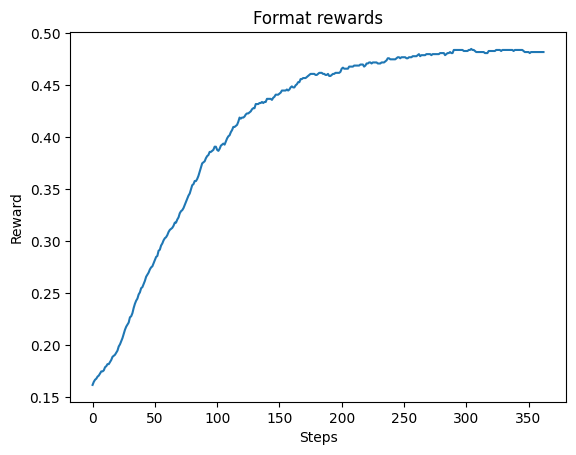

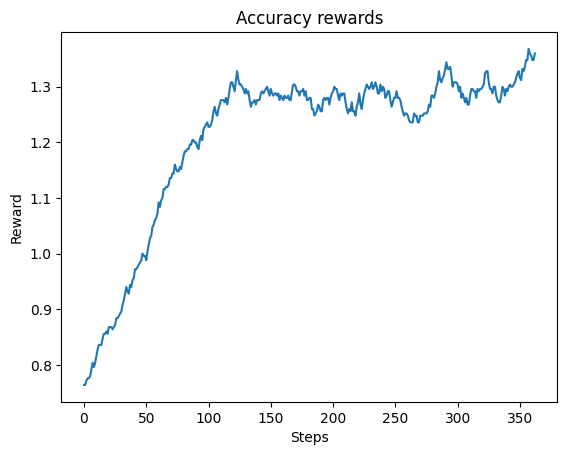

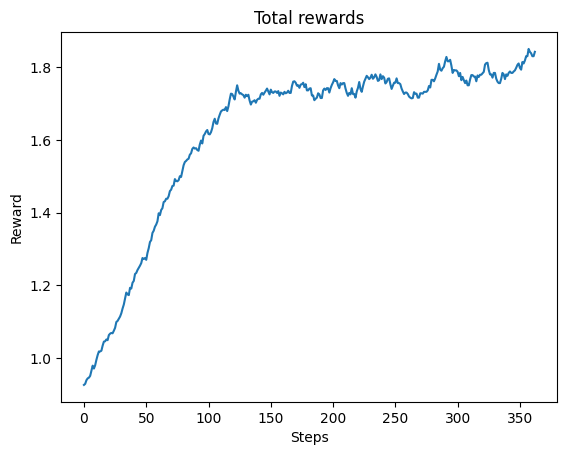

In [25]:
plt.plot(moving_average(track_format_rewards, window_size=100))
plt.title("Format rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()

###########
plt.plot(moving_average(track_accuracy_rewards, window_size=100))
plt.title("Accuracy rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()

###########
plt.plot(moving_average(total_rewards, window_size=100))
plt.title("Total rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()

# Save model

In [26]:
model.eval()
torch.save(model.state_dict(), 'finetuned_weights.pth')